# Bài tập nhóm lần 3

> Calculate the winter rain and the harvest rain (in millimeters). Add summer heat in the vineyard (in degrees centigrade). Subtract 12.145. And what do you have? A very, very passionate argument over wine.

> Tạm dịch: "Tính lượng mưa mùa đông và lượng mưa thu hoạch (tính bằng milimét). Thêm sức nóng mùa hè trong vườn nho (tính bằng độ C). Trừ 12,145. Và bạn có gì? Một cuộc tranh cãi rất sôi nổi về rượu vang." 

Theo "Wine Equation Puts Some Noses Out of Joint," The New York Times, 04/03/1990


## Import các thứ

In [1]:
library(dplyr)
library(tidyr)
library(car)
library(MASS)
library(leaps)
library(Metrics)
library(lmtest)
library(ggplot2)
library(clusterSim)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: cluster



## Hàm phụ trợ

In [2]:
remove_high_vif <- function(regr_variable, data, threshold = 5) {  
    library(car)
    library(dplyr)
    
    stop <- FALSE
    while(stop == FALSE) {
        # Tính VIF cho các biến độc lập
        model <- lm(as.formula(paste(regr_variable, "~ .")), data = data)
        vif_values <- vif(model)
        # Tìm các biến có VIF cao hơn ngưỡng
        high_vif <- which(vif_values > threshold)
        
        if (length(high_vif) > 0) {
            # Loại bỏ các biến có VIF cao
            remove_index <- which.max(high_vif)
            rm_names <- names(data[, !names(data) %in% regr_variable])
            rm_name <- rm_names[remove_index]
            data <- data[, !names(data) %in% rm_name]
        } else {
            stop <- TRUE
        }
    }
    return(data)
}

## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
raw_data = read.table("./data/wine.csv", header=TRUE, sep=",", stringsAsFactors = FALSE)
str(raw_data)

'data.frame':	27 obs. of  7 variables:
 $ Year       : int  1952 1953 1955 1957 1958 1959 1960 1961 1962 1963 ...
 $ Price      : num  7.5 8.04 7.69 6.98 6.78 ...
 $ WinterRain : int  600 690 502 420 582 485 763 830 697 608 ...
 $ AGST       : num  17.1 16.7 17.1 16.1 16.4 ...
 $ HarvestRain: int  160 80 130 110 187 187 290 38 52 155 ...
 $ Age        : int  31 30 28 26 25 24 23 22 21 20 ...
 $ FrancePop  : num  43184 43495 44218 45152 45654 ...


## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [4]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 506 dòng và 14 cột
dim(raw_data)

[1] 27  7

Ta thấy dữ liệu có 27 quan trắc và 7 thuộc tính

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [5]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- table(raw_data[duplicated(raw_data), ])
duplicates # Không có dữ liệu trùng lặp

Year,Price,WinterRain,AGST,HarvestRain,Age,FrancePop
<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>


Ta thấy dữ liệu không trùng lặp

### Mỗi cột mang ý nghĩa gì?

In [6]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

'data.frame':	27 obs. of  7 variables:
 $ Year       : int  1952 1953 1955 1957 1958 1959 1960 1961 1962 1963 ...
 $ Price      : num  7.5 8.04 7.69 6.98 6.78 ...
 $ WinterRain : int  600 690 502 420 582 485 763 830 697 608 ...
 $ AGST       : num  17.1 16.7 17.1 16.1 16.4 ...
 $ HarvestRain: int  160 80 130 110 187 187 290 38 52 155 ...
 $ Age        : int  31 30 28 26 25 24 23 22 21 20 ...
 $ FrancePop  : num  43184 43495 44218 45152 45654 ...


Thông tin bộ dữ liệu: Wines (Bordeaux)
- Year: năm mà nho được thu hoạch để làm rượu vang.
- Price: logarit của giá thị trường trung bình đối với rượu nho Bordeaux theo các cuộc đấu giá năm 1990–1991. Đây là một phép biến đổi phi tuyến của phản hồi được thực hiện để tuyến tính hóa phản hồi.
- WinterRain: lượng mưa mùa đông(in mm).
- AGST: Nhiệt độ trung bình mùa sinh trưởng (in Celsius degrees).
- HarvestRain: thu hoạch lượng mưa (in mm).
- Age: Tuổi của rượu được đo bằng số năm lưu trữ trong thùng.
- FrancePop: dân số Pháp vào năm Year (in thousands).

### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

Các cột đều có kiểu dữ liệu phù hợp

### Các cột với kiểu dữ liệu số phân bố như thế nào?

In [7]:
# Function to calculate missing ratio
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

In [8]:
# Function to calculate median
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

In [9]:
# Function to calculate lower quartile
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

In [10]:
# Function to calculate upper quartile
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [11]:
# Select numerical columns
num_col_info_df <- as.data.frame(raw_data)  %>%
  select_if(is.numeric)

# Aggregating statistics
num_col_info_df <- num_col_info_df %>%
  reframe(
    missing_ratio = sapply(., missing_ratio),
    min = sapply(., min, na.rm = TRUE),
    lower_quartile = sapply(., lower_quartile),
    median = sapply(., median_custom),
    upper_quartile = sapply(., upper_quartile),
    max = sapply(., max, na.rm = TRUE)
  )

  print(num_col_info_df)

  missing_ratio        min lower_quartile  median upper_quartile        max
1             0  1952.0000         1960.5  1967.0         1973.5  1980.0000
2             0     6.2049            6.5     7.0            7.4     8.4937
3             0   376.0000          543.5   600.0          705.5   830.0000
4             0    14.9833           16.1    16.4           17.0    17.6500
5             0    38.0000           88.0   123.0          185.5   292.0000
6             0     3.0000            9.5    16.0           22.5    31.0000
7             0 43183.5690        46856.0 50650.4        53511.2 55110.2360


Nhận xét:
- Các thuộc tính không có missing values
- 

Kiểm tra lại với hàm summary của R

In [12]:
summary(raw_data)

      Year          Price         WinterRain         AGST        HarvestRain   
 Min.   :1952   Min.   :6.205   Min.   :376.0   Min.   :14.98   Min.   : 38.0  
 1st Qu.:1960   1st Qu.:6.508   1st Qu.:543.5   1st Qu.:16.15   1st Qu.: 88.0  
 Median :1967   Median :6.984   Median :600.0   Median :16.42   Median :123.0  
 Mean   :1967   Mean   :7.042   Mean   :608.4   Mean   :16.48   Mean   :144.8  
 3rd Qu.:1974   3rd Qu.:7.441   3rd Qu.:705.5   3rd Qu.:17.01   3rd Qu.:185.5  
 Max.   :1980   Max.   :8.494   Max.   :830.0   Max.   :17.65   Max.   :292.0  
      Age          FrancePop    
 Min.   : 3.00   Min.   :43184  
 1st Qu.: 9.50   1st Qu.:46856  
 Median :16.00   Median :50650  
 Mean   :16.19   Mean   :50085  
 3rd Qu.:22.50   3rd Qu.:53511  
 Max.   :31.00   Max.   :55110  

Warning message in applyDefaults(diagonal, defaults = list(method = "adaptiveDensity"), :
“unnamed diag arguments, will be ignored”
Warning message in plot.window(...):
“"reg.line" is not a graphical parameter”
Warning message in plot.window(...):
“"spread" is not a graphical parameter”
Warning message in plot.window(...):
“"span" is not a graphical parameter”
Warning message in plot.window(...):
“"levels" is not a graphical parameter”
Warning message in plot.window(...):
“"id.n" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"reg.line" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"spread" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"span" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"levels" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"id.n" is not a graphical parameter”
Warning message in title(...):
“"reg.line" is not a graphical parameter”

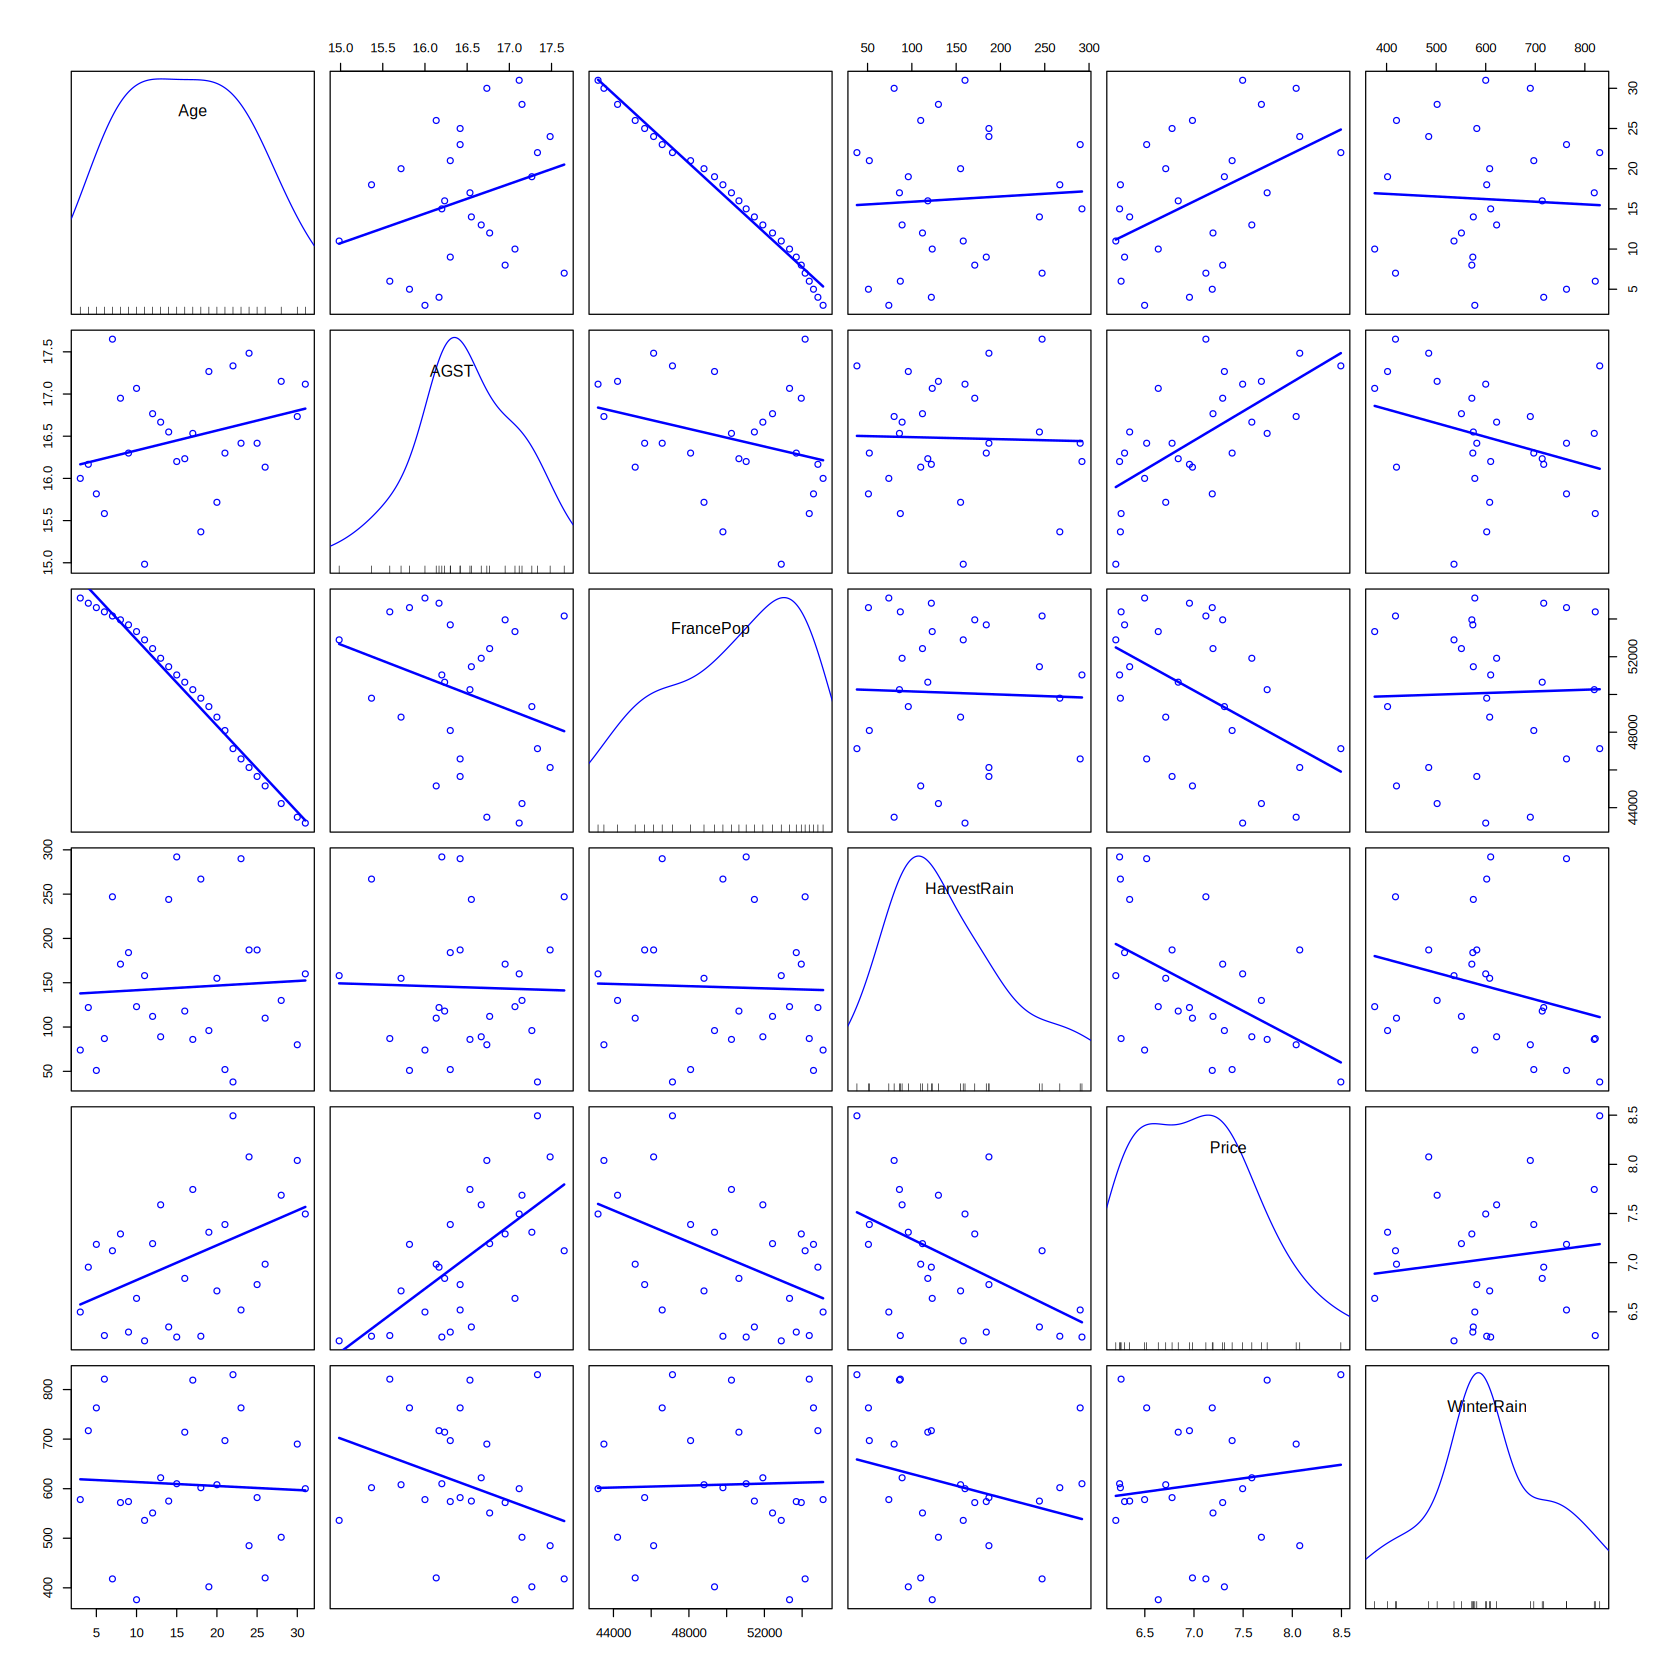

In [13]:
# Set plot size
options(repr.plot.width=14, repr.plot.height=14)

# Create the scatterplot matrix
scatterplotMatrix(~ Age + AGST + FrancePop + HarvestRain + Price + WinterRain,
                  reg.line = lm, smooth = FALSE, spread = FALSE, span = 0.5,
                  ellipse = FALSE, levels = c(.5, .9), id.n = 2,
                  diagonal = 'histogram', data = raw_data)

Nhận xét:
- Ta có thể thấy các biến `Age`, `AGST` và `WinterRain` có mối quan hệ tuyến tính thuận với biến `Price`.
- Ta có thể thấy các biến `FrancePop`, và `HarvestRain` có mối quan hệ tuyến tính nghịch với biến `Price`.
- Phân phối của biến `FrancePop` lệch trái, còn `Price` và `Harvest` thì lệch phải. Còn các biến khác tương đối chuẩn (có dạng bell shape)

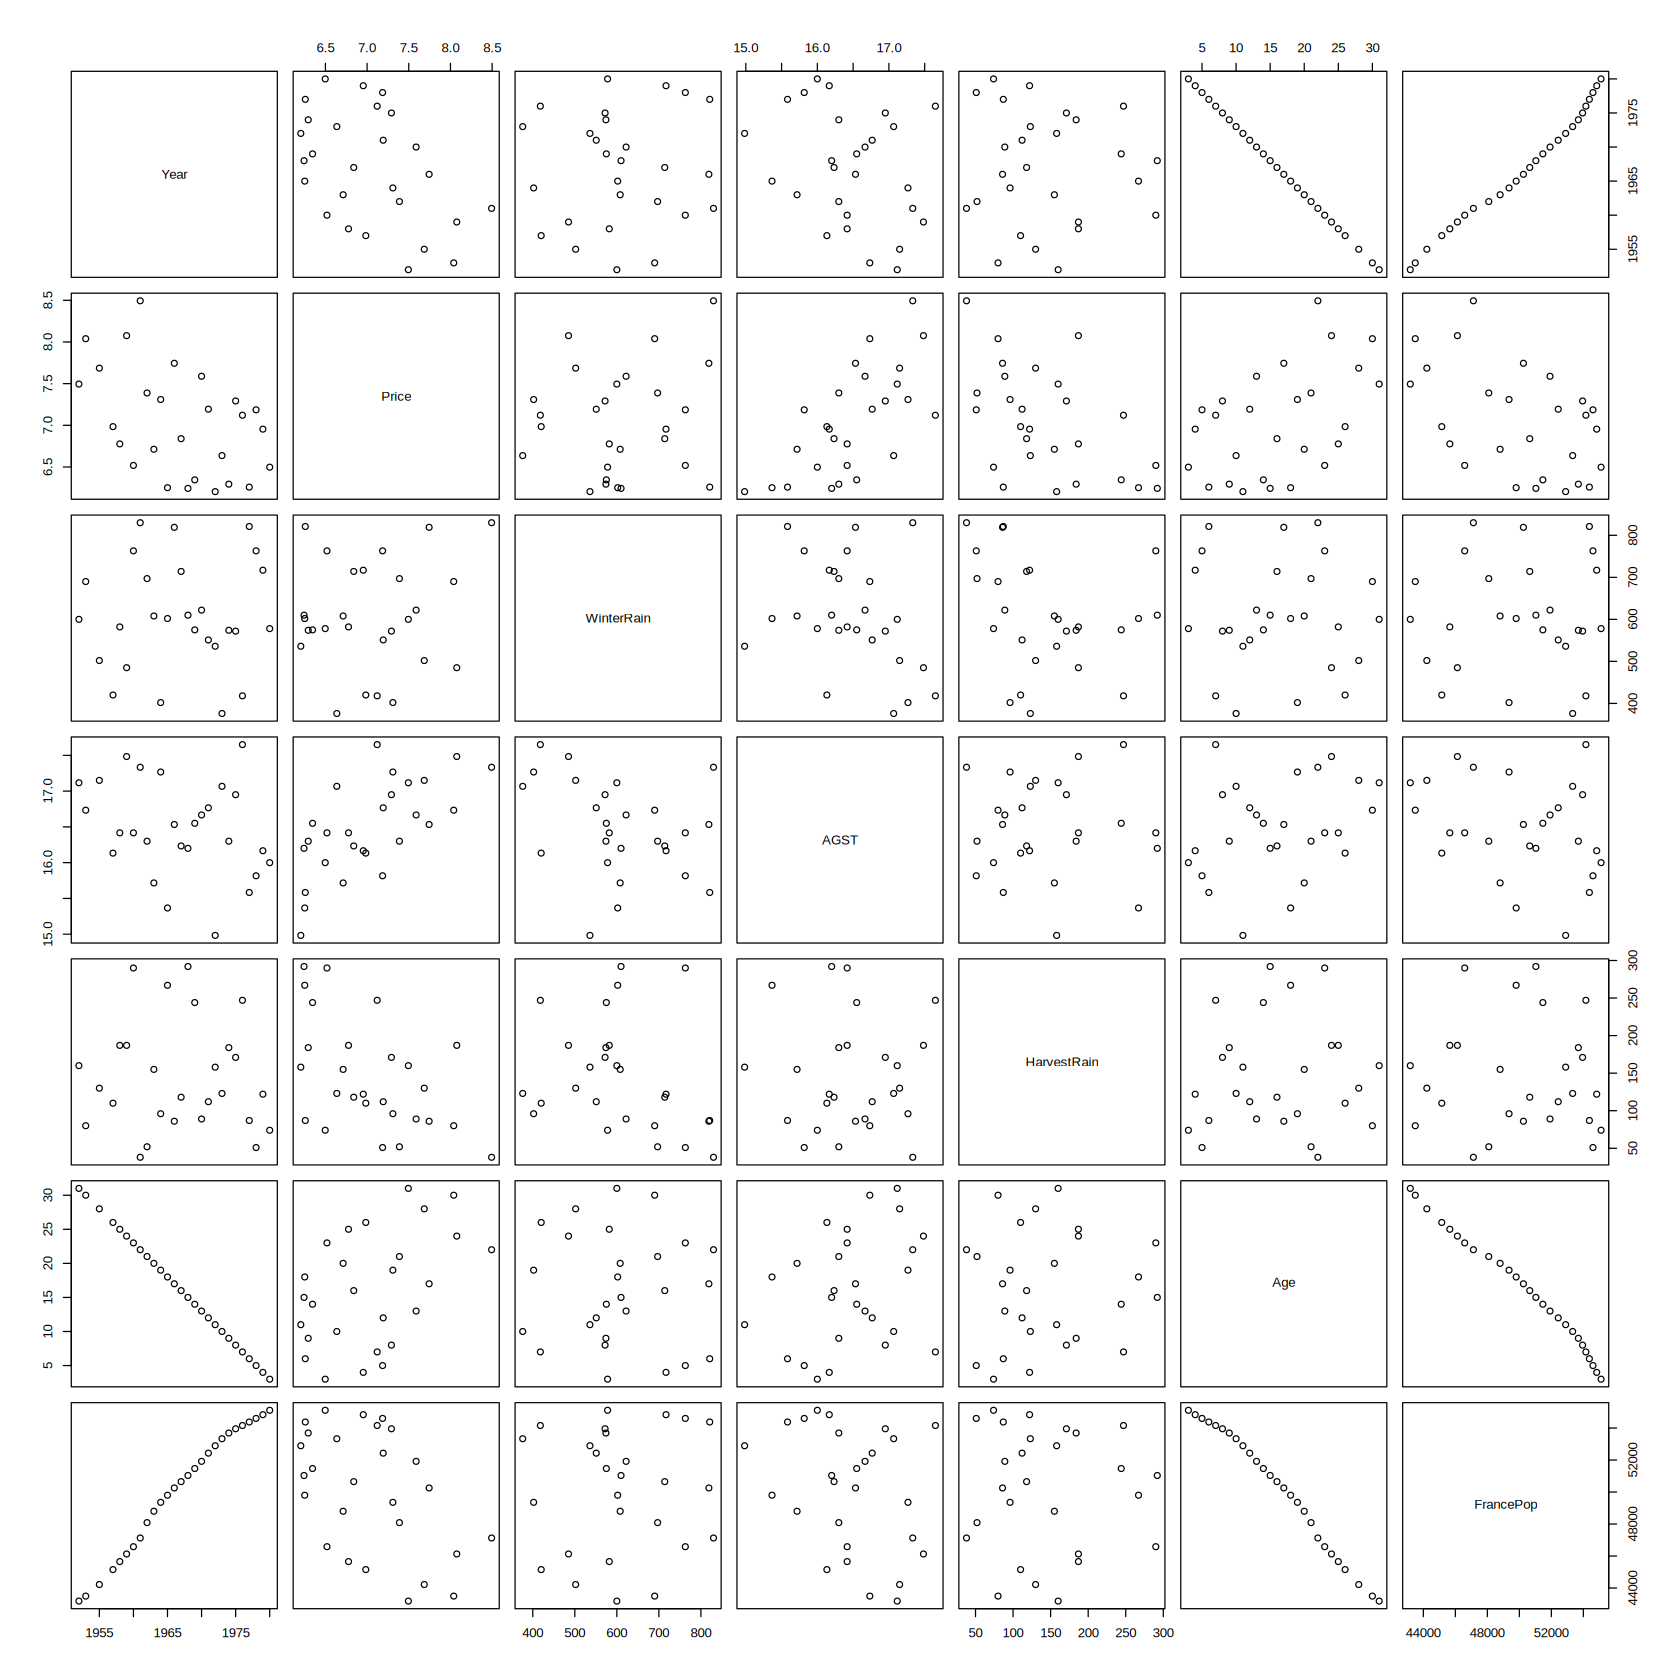

In [14]:
# Trực quan dữ liệu
plot(raw_data)

In [15]:
round(cor(raw_data),2)

,Year,Price,WinterRain,AGST,HarvestRain,Age,FrancePop
Year,1.00,-0.46,0.05,-0.29,-0.06,-1.00,0.99
Price,-0.46,1.00,0.13,0.67,-0.51,0.46,-0.48
WinterRain,0.05,0.13,1.00,-0.32,-0.27,-0.05,0.03
AGST,-0.29,0.67,-0.32,1.00,-0.03,0.29,-0.30
HarvestRain,-0.06,-0.51,-0.27,-0.03,1.00,0.06,-0.03
Age,-1.00,0.46,-0.05,0.29,0.06,1.00,-0.99
FrancePop,0.99,-0.48,0.03,-0.30,-0.03,-0.99,1.00


### Các cột với kiểu dữ liệu phân loại phân bố như thế nào?

## Phân chia dữ liệu

In [16]:
# Chia dữ liệu
set.seed(42)
raw_data = raw_data[, !(names(raw_data) %in% c("rad","chas"))]
n = nrow(raw_data)
train_indices <- sample(seq_len(n), size = 0.7 * n)
train = raw_data[train_indices,]
test = raw_data[-train_indices,]

dim(train)
dim(test)

[1] 18  7

[1] 9 7

## Khảo sát ngoại lai

In [17]:
# Khảo sát ngoại lai theo từng biến độc lập của tập train
outliers_index = list()
extreme_outliers_index = list()

for (i in 1:ncol(train)) {
  # Tính toán Q1, Q3 và IQR
  Q1 = quantile(train[, i], 0.25, na.rm = TRUE)
  Q3 = quantile(train[, i], 0.75, na.rm = TRUE)
  IQR = Q3 - Q1

  # Xác định ngoại lai
  outliers_index_i = train[, i] < (Q1 - 1.5 * IQR) | train[, i] > (Q3 + 1.5 * IQR)
  # outliers_i = train[train[, i] < (Q1 - 1.5 * IQR) | train[, i] > (Q3 + 1.5 * IQR), i]

  # Lưu trữ ngoại lai
  field_name = names(train)[i]
  outliers_index[[field_name]] = which(outliers_index_i)

  # Xác định cực ngoại lai
  extreme_outliers_index_i = train[, i] < (Q1 - 3 * IQR) | train[, i] > (Q3 + 3 * IQR)
  extreme_outliers_index[[field_name]] = which(extreme_outliers_index_i)
}
# In kết quả theo từng biến ra màn hình
for (i in 1:ncol(train)) {
  print(paste("Biến:", names(train)[i]))
  print(paste("Số ngoại lai:", length(outliers_index[[names(train)[i]]])))
  print(paste("Số cực ngoại lai:", length(extreme_outliers_index[[names(train)[i]]])))
}

# Tìm tổng số quan trắc ngoại lai và cực ngoại lai thực sự
outliers = c()
extreme_outliners = c()
for (i in 1:ncol(train)){
    outliers = c(outliers, outliers_index[[names(train)[i]]])
    extreme_outliners = c(extreme_outliners, extreme_outliers_index[[names(train)[i]]])
}

outliers = unique(outliers)
extreme_outliners = unique(extreme_outliners)
print(paste("Tổng số ngoại lai:", length(outliers)))
print(paste("Tổng số cực ngoại lai:", length(extreme_outliners)))

[1] "Biến: Year"
[1] "Số ngoại lai: 0"
[1] "Số cực ngoại lai: 0"
[1] "Biến: Price"
[1] "Số ngoại lai: 0"
[1] "Số cực ngoại lai: 0"
[1] "Biến: WinterRain"
[1] "Số ngoại lai: 0"
[1] "Số cực ngoại lai: 0"
[1] "Biến: AGST"
[1] "Số ngoại lai: 0"
[1] "Số cực ngoại lai: 0"
[1] "Biến: HarvestRain"
[1] "Số ngoại lai: 2"
[1] "Số cực ngoại lai: 0"
[1] "Biến: Age"
[1] "Số ngoại lai: 0"
[1] "Số cực ngoại lai: 0"
[1] "Biến: FrancePop"
[1] "Số ngoại lai: 0"
[1] "Số cực ngoại lai: 0"
[1] "Tổng số ngoại lai: 2"
[1] "Tổng số cực ngoại lai: 0"


Chúng ta không cần phải xóa các ngoại lai.

## Chuẩn hóa dữ liệu

In [18]:
scaled_train = train
# scaled_test = scale(test)

Warning message in applyDefaults(diagonal, defaults = list(method = "adaptiveDensity"), :
“unnamed diag arguments, will be ignored”
Warning message in plot.window(...):
“"reg.line" is not a graphical parameter”
Warning message in plot.window(...):
“"spread" is not a graphical parameter”
Warning message in plot.window(...):
“"span" is not a graphical parameter”
Warning message in plot.window(...):
“"levels" is not a graphical parameter”
Warning message in plot.window(...):
“"id.n" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"reg.line" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"spread" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"span" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"levels" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"id.n" is not a graphical parameter”


Warning message in title(...):
“"reg.line" is not a graphical parameter”
Warning message in title(...):
“"spread" is not a graphical parameter”
Warning message in title(...):
“"span" is not a graphical parameter”
Warning message in title(...):
“"levels" is not a graphical parameter”
Warning message in title(...):
“"id.n" is not a graphical parameter”
Warning message in plot.window(...):
“"reg.line" is not a graphical parameter”
Warning message in plot.window(...):
“"spread" is not a graphical parameter”
Warning message in plot.window(...):
“"span" is not a graphical parameter”
Warning message in plot.window(...):
“"levels" is not a graphical parameter”
Warning message in plot.window(...):
“"id.n" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"reg.line" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"spread" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"span" is not a graphical parameter”
Warning message

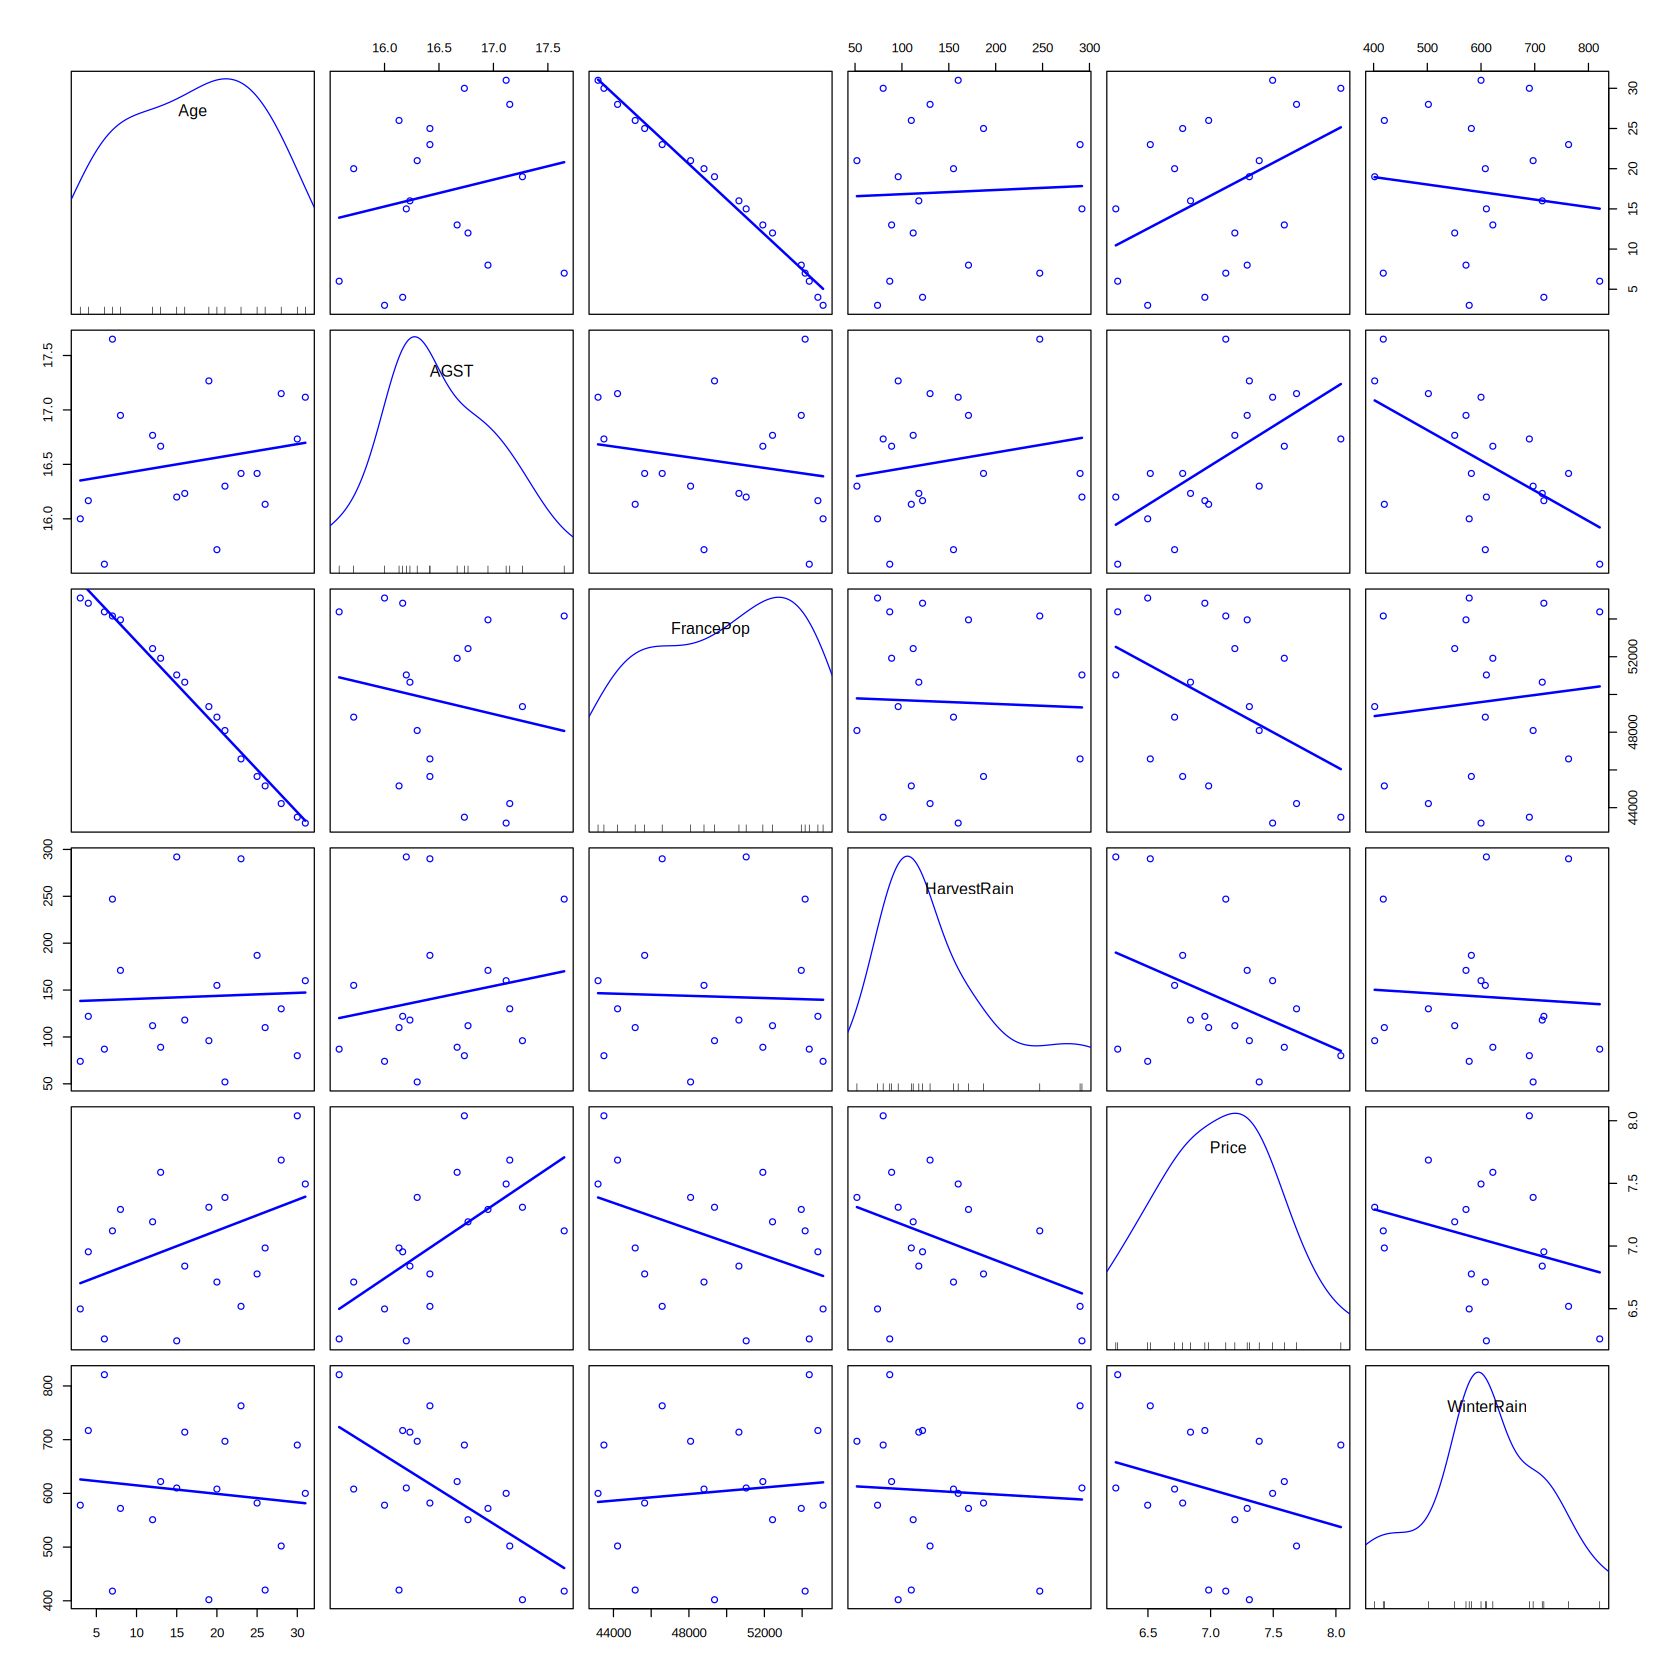

In [19]:
scatterplotMatrix(~ Age + AGST + FrancePop + HarvestRain + Price + WinterRain,
                  reg.line = lm, smooth = FALSE, spread = FALSE, span = 0.5,
                  ellipse = FALSE, levels = c(.5, .9), id.n = 2,
                  diagonal = 'histogram', data = scaled_train)

## Mô hình hóa với hồi quy đơn biến

Dựa trên quan sát biểu đồ scatter, ta có thể dự đoán biết `Price` bằng hồi quy tuyến tính đơn với biến `AGST` hoặc `HarvestRain`.

In [20]:
# Xây dựng mô hình hồi quy tuyến tính đơn Price ~ AGST
modAGST <- lm(Price ~ AGST, data = data.frame(scaled_train))
print(summary(modAGST))


Call:
lm(formula = Price ~ AGST, data = data.frame(scaled_train))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.61577 -0.23201 -0.00177  0.15725  0.86800 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -2.6195     2.8364  -0.924  0.36946   
AGST          0.5851     0.1715   3.411  0.00358 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.392 on 16 degrees of freedom
Multiple R-squared:  0.421,	Adjusted R-squared:  0.3848 
F-statistic: 11.63 on 1 and 16 DF,  p-value: 0.003577



In [21]:
# Xây dựng mô hình hồi quy tuyến tính đơn Price ~ HarvestRain
modHarvestRain <- lm(Price ~ HarvestRain, data = data.frame(scaled_train))
print(summary(modHarvestRain))


Call:
lm(formula = Price ~ HarvestRain, data = data.frame(scaled_train))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.95168 -0.25117 -0.02709  0.35812  0.80883 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.46007    0.25400  29.370  2.4e-15 ***
HarvestRain -0.00287    0.00160  -1.794   0.0917 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.47 on 16 degrees of freedom
Multiple R-squared:  0.1675,	Adjusted R-squared:  0.1155 
F-statistic: 3.219 on 1 and 16 DF,  p-value: 0.0917



Ta thấy trong mô hình `Price ~ AGST`, Intercept không có ý nghĩa cho hồi quy, nhưng hệ số `AGST` thì có, nó có tác động thuận đối với biết Price. Còn đối với mô hình `Price ~ HarvestRain`, biến `HarvestRain` có ý nghĩa nhưng thấp và intercept không có ý nghĩa.

Thực hiện một số thí nghiệm với biến `FrancePop`, `Age` và `WinterRain`

In [22]:
# Xây dựng mô hình hồi quy tuyến tính đơn Price ~ FrancePop
modFrancePop <- lm(Price ~ FrancePop, data = data.frame(scaled_train))
print(summary(modFrancePop))


Call:
lm(formula = Price ~ FrancePop, data = data.frame(scaled_train))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7317 -0.3599  0.1430  0.3054  0.6681 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.655e+00  1.351e+00   7.144 2.33e-06 ***
FrancePop   -5.252e-05  2.715e-05  -1.934    0.071 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4638 on 16 degrees of freedom
Multiple R-squared:  0.1895,	Adjusted R-squared:  0.1388 
F-statistic: 3.741 on 1 and 16 DF,  p-value: 0.07098



In [23]:
# Xây dựng mô hình hồi quy tuyến tính đơn Price ~ Age
modAge <- lm(Price ~ Age, data = data.frame(scaled_train))
print(summary(modAge))


Call:
lm(formula = Price ~ Age, data = data.frame(scaled_train))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7558 -0.3789  0.1564  0.3063  0.6703 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.62957    0.23561   28.14  4.7e-15 ***
Age          0.02465    0.01226    2.01   0.0616 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4603 on 16 degrees of freedom
Multiple R-squared:  0.2016,	Adjusted R-squared:  0.1517 
F-statistic:  4.04 on 1 and 16 DF,  p-value: 0.06159



In [24]:
# Xây dựng mô hình hồi quy tuyến tính đơn Price ~ WinterRain
modWinterRain <- lm(Price ~ WinterRain, data = data.frame(scaled_train))
print(summary(modWinterRain))


Call:
lm(formula = Price ~ WinterRain, data = data.frame(scaled_train))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.79896 -0.32381 -0.03011  0.38144  1.09261 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.772703   0.621890  12.499 1.14e-09 ***
WinterRain  -0.001197   0.001012  -1.183    0.254    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.494 on 16 degrees of freedom
Multiple R-squared:  0.08044,	Adjusted R-squared:  0.02297 
F-statistic:   1.4 on 1 and 16 DF,  p-value: 0.2541



| Predictor  | $R^2$  |
|---|---|
| AGST  | 0.421  |
| HarvestRain  | 0.1675  |
| FrancePop  | 0.1895  |
| Age  | 0.2016  |
| WinterRain  | 0.08044  |

## Mô hình hóa với hồi quy đa biến

In [25]:
model_linear = lm(Price~., data=data.frame(scaled_train))
summary(model_linear)
modBIC <- MASS::stepAIC(model_linear, k = log(nrow(data.frame(scaled_train))), trace = 0)
summary(modBIC)


Call:
lm(formula = Price ~ ., data = data.frame(scaled_train))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33984 -0.14183 -0.00246  0.19403  0.28605 

Coefficients: (1 not defined because of singularities)
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.075e+01  1.032e+02   0.492 0.631774    
Year        -2.889e-02  5.539e-02  -0.522 0.611409    
WinterRain   8.584e-04  5.960e-04   1.440 0.175347    
AGST         7.251e-01  1.318e-01   5.503 0.000136 ***
HarvestRain -3.946e-03  8.104e-04  -4.869 0.000385 ***
Age                 NA         NA      NA       NA    
FrancePop    2.344e-05  1.213e-04   0.193 0.849938    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2333 on 12 degrees of freedom
Multiple R-squared:  0.8461,	Adjusted R-squared:  0.782 
F-statistic:  13.2 on 5 and 12 DF,  p-value: 0.0001574



Call:
lm(formula = Price ~ Year + AGST + HarvestRain, data = data.frame(scaled_train))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41484 -0.11206 -0.01786  0.13021  0.38188 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 33.2667647 12.9871722   2.562   0.0226 *  
Year        -0.0182455  0.0063702  -2.864   0.0125 *  
AGST         0.6175459  0.1064485   5.801 4.59e-05 ***
HarvestRain -0.0038674  0.0008112  -4.767   0.0003 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2341 on 14 degrees of freedom
Multiple R-squared:  0.8193,	Adjusted R-squared:  0.7805 
F-statistic: 21.16 on 3 and 14 DF,  p-value: 1.815e-05


Ta có phương trình hồi quy như sau:

Price = 5.628e-15 - 3.324e-01 * Year + 6.848e-01 * AGST -5.515e-01 * HarvestRain

Và Kết quả cho thấy, ta có thể nắm bắt được $81.93%$ biến thiên của biến Price. Và chỉ có 2 biến AGST và HarvestRain là có ý nghĩa.

### Phân tích kết quả mô hình

#### Residuals vs Fitted Plot

Biểu đồ **Residuals vs Fitted Plot** đưa ra dấu hiệu nếu có các mẫu phi tuyến tính. Để hồi quy tuyến tính chính xác, dữ liệu cần phải tuyến tính nên điều này sẽ kiểm tra xem điều kiện đó có được đáp ứng hay không.

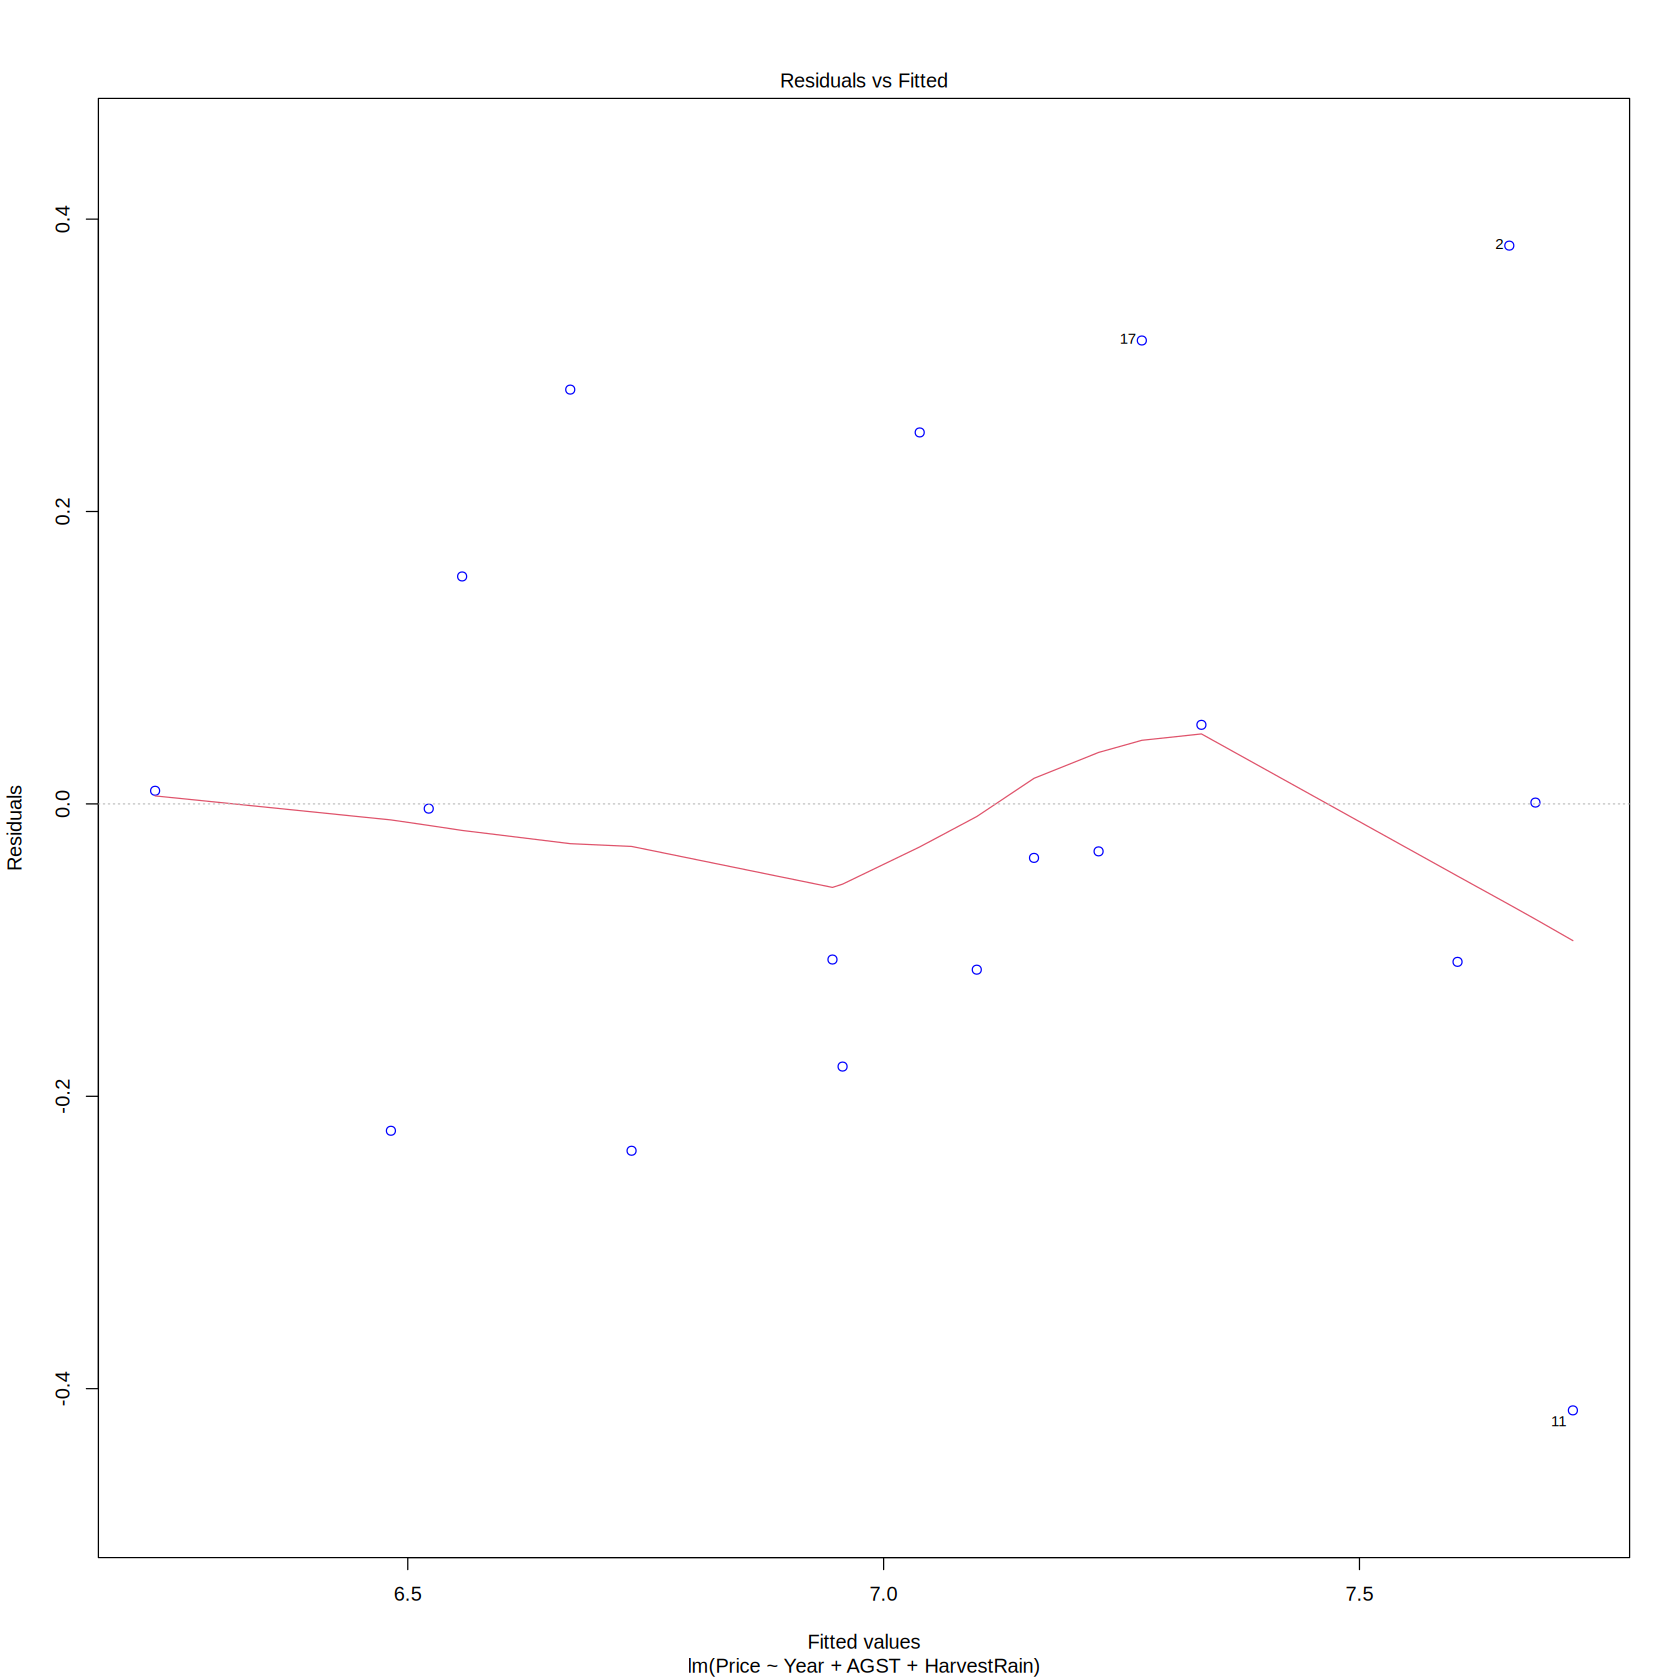

In [26]:
plot(modBIC, which=1, col=c("blue")) # Residuals vs Fitted Plot

#### Normal Q–Q (quantile-quantile) Plot

Các giá trị thặng dư (residual) nên có phân phối chuẩn. Để kiểm tra điều này, chúng ta cần quan sát biểu đồ QQ Residuals plot, nếu các điểm được xếp thành một đường thẳng (hoặc gần như thẳng) thì chứng tỏ các giá trị thặng dư (residual) có phân phối chuẩn. Như hình vẽ kết quả ở trên, ta thấy rõ điều đó, residual có phân phối chuẩn.

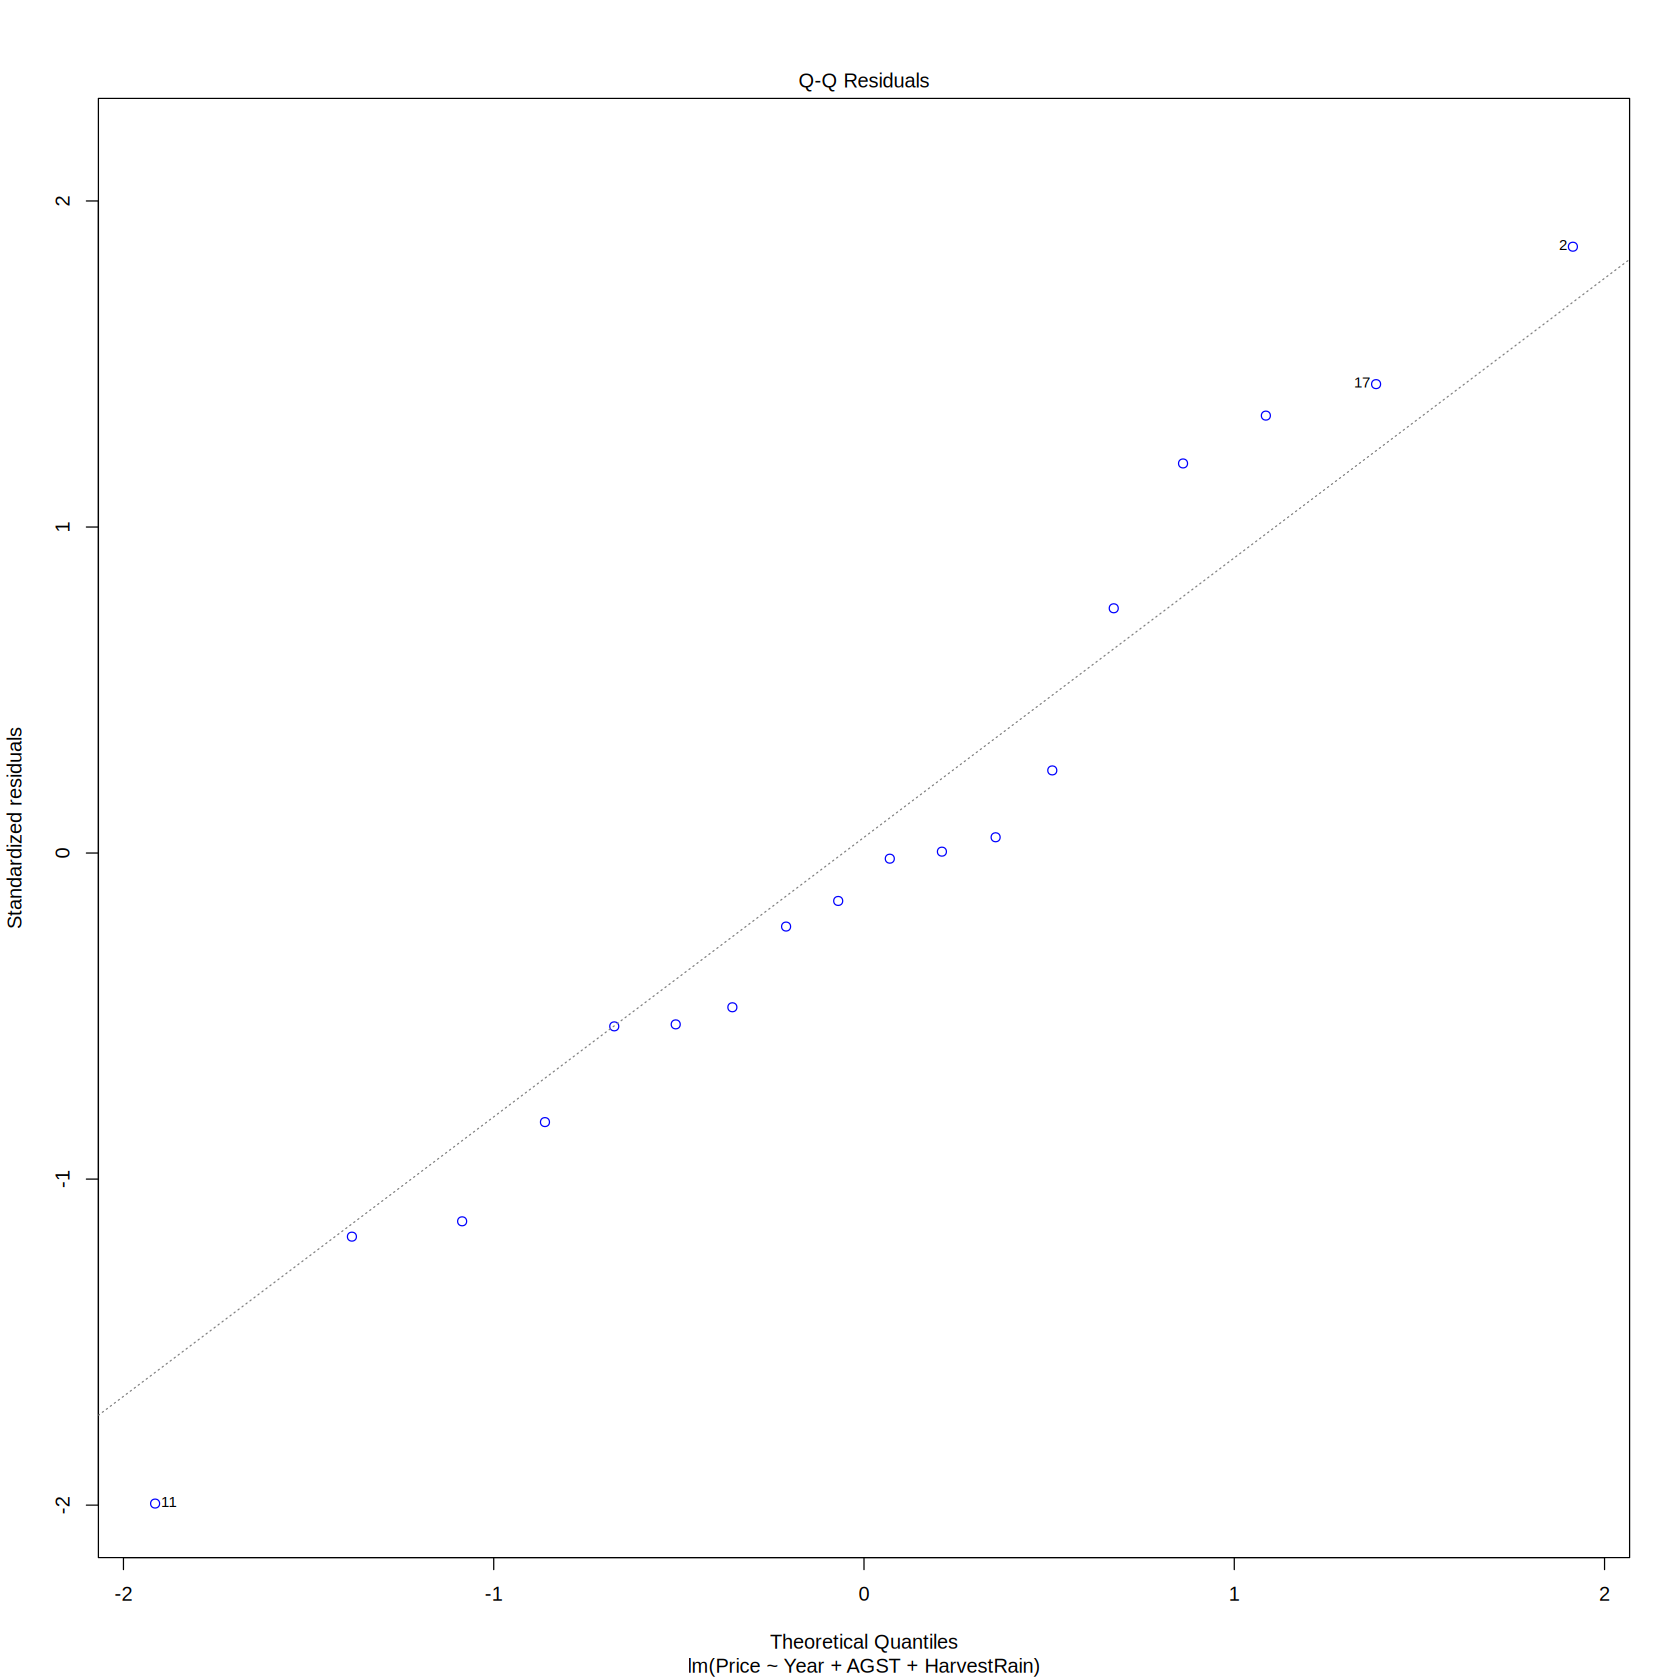

In [27]:
plot(modBIC, which=2, col=c("blue")) # QQ Plot

Cẩn thận hơn, chúng ta thử dùng Shapiro–Wilk test để kiểm tra có đúng thật là các giá trị thặng dư có phân phối chuẩn hay không?
- H0: Biến thặng dư của mô hình phân phối chuẩn trong một số quần thể.
- H1: Biến thặng dư của mô hình không phân phối chuẩn trong một số quần thể.

In [28]:
print(shapiro.test(residuals(modBIC)))


	Shapiro-Wilk normality test

data:  residuals(modBIC)
W = 0.96586, p-value = 0.7173



Ta thấy p-value > 0.05, ta chưa đủ cơ sở để bác bỏ H0.

#### Scale-Location

Biểu đồ scale-location kiểm định giả định hồi quy về phương sai bằng nhau (homoscedasticity), tức là giá trị thặng dư có phương sai bằng với đường hồi quy.

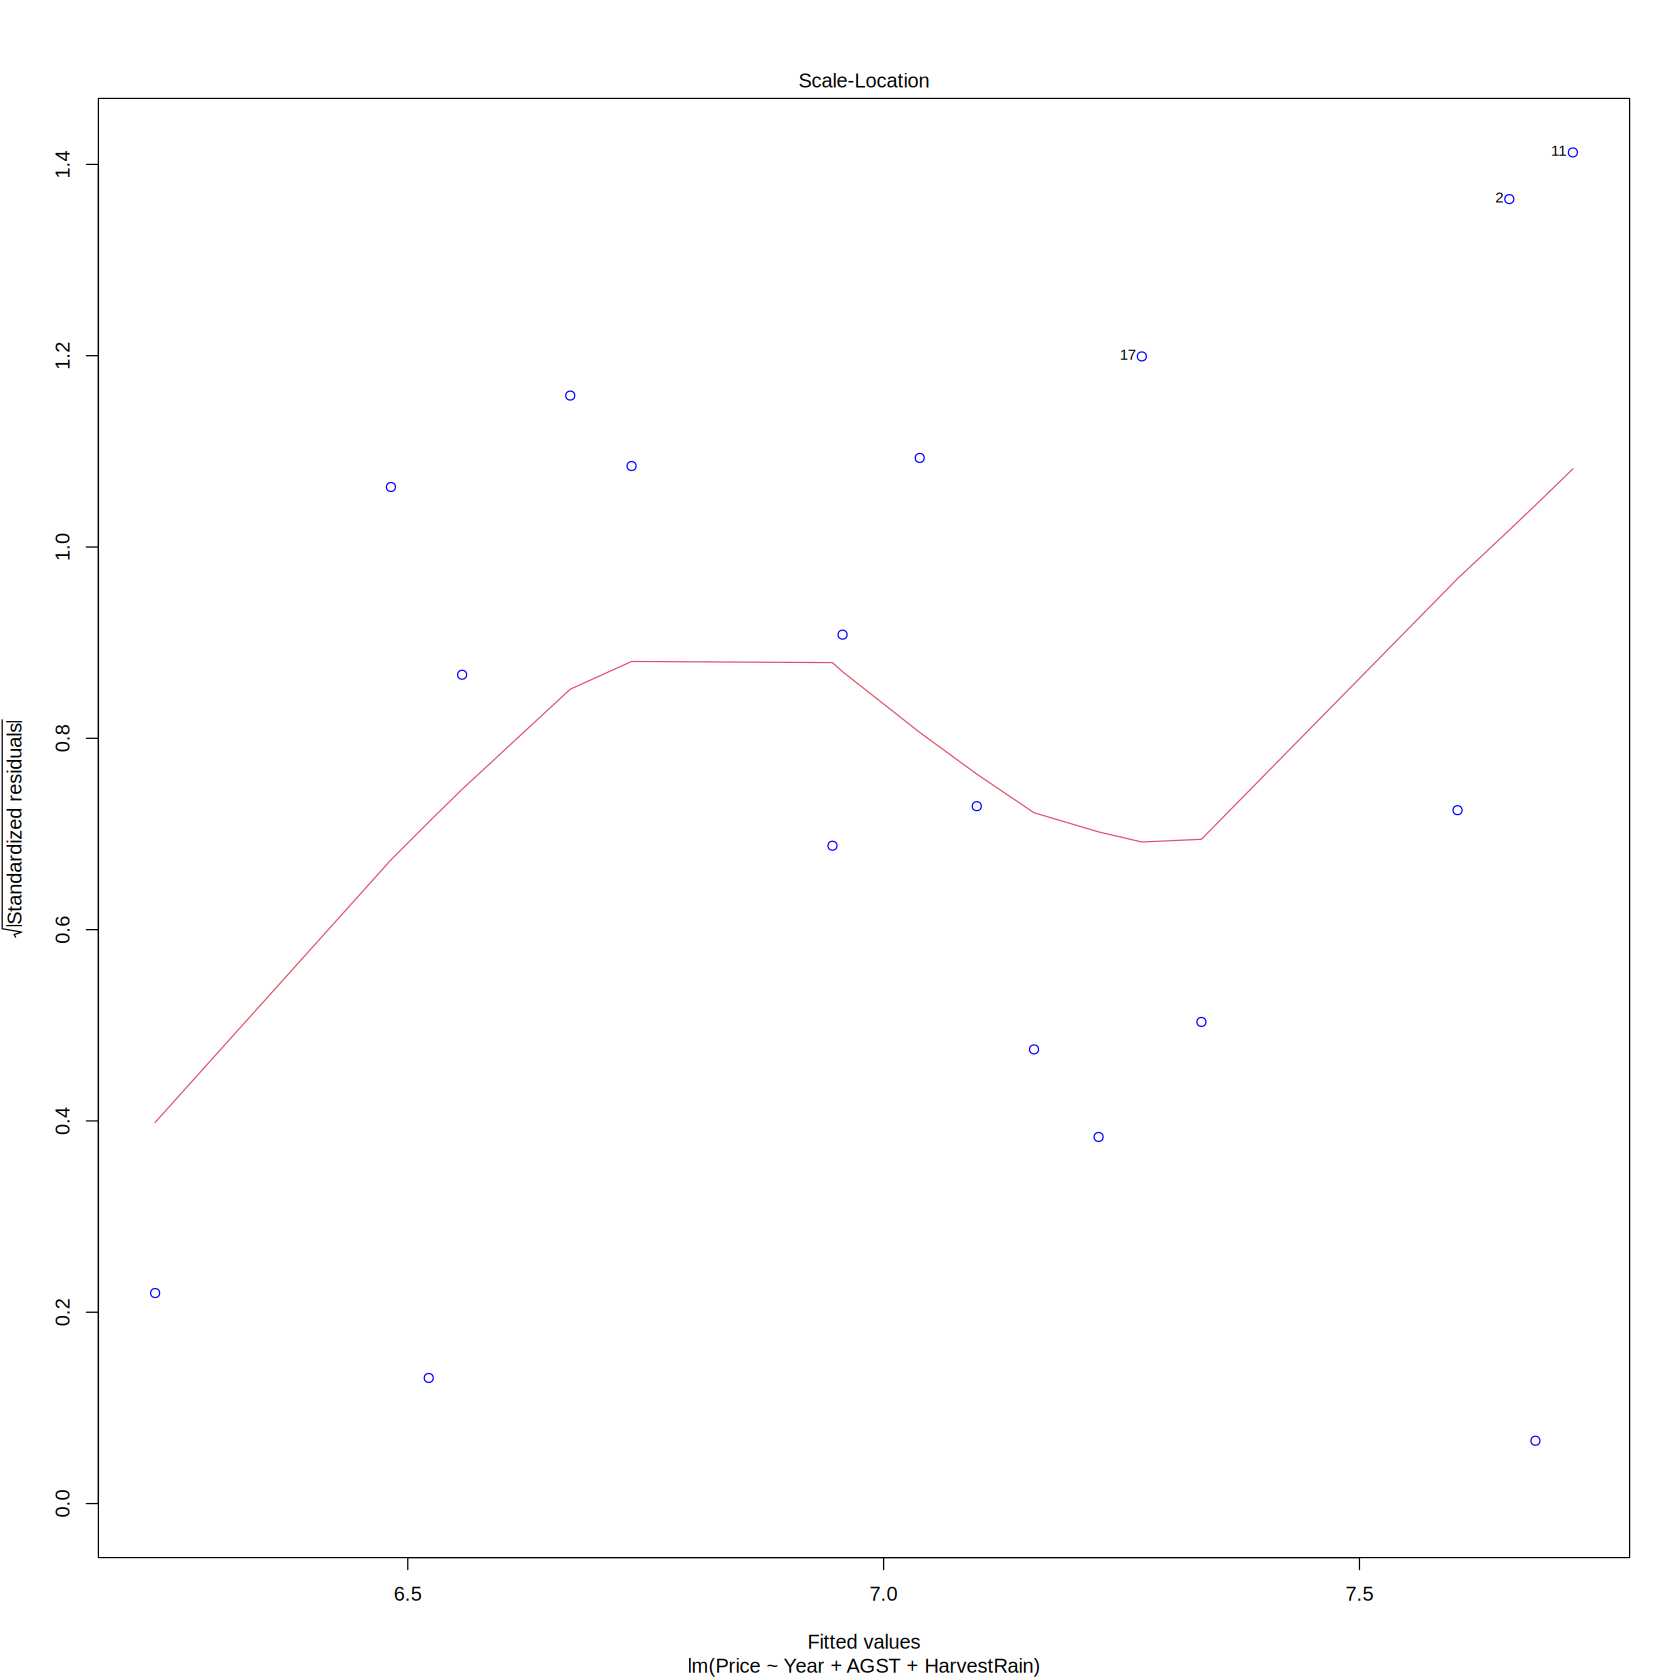

In [29]:
plot(modBIC, which=3, col=c("blue")) # Scale-Location

Ta phát hiện:
- Đường màu đỏ gần bị lệch về phía dưới của biểu đồ. Nghĩa là, độ phân tán của giá trị thặng dư gần không bằng nhau ở tất cả các giá trị phù hợp.
- Các giá trị thặng dư được phân tán ngẫu nhiên xung quanh đường màu đỏ với độ biến thiên không bằng nhau ở tất cả các giá trị phù hợp.

Cẩn thận hơn, chúng ta sử dụng Breusch-Pagan test để kiểm tra có thật là như vậy không?
- H0: Các giá trị thặng dư là homoscedastic
- H1: Các giá trị thặng dư là heteroscedastic

In [30]:
# Breusch-Pagan Test
print(bptest(modBIC))


	studentized Breusch-Pagan test

data:  modBIC
BP = 4.6675, df = 3, p-value = 0.1978



Ta thấy p-value > 0.05, nên ta chưa đủ cơ sở để bác bỏ H0.

#### Residuals vs Leverage

Biểu đồ này có thể được sử dụng để tìm các trường hợp có ảnh hưởng trong tập dữ liệu. Một trường hợp có ảnh hưởng là một trường hợp mà nếu bị loại bỏ sẽ ảnh hưởng đến mô hình nên việc đưa vào hoặc loại trừ nó cần được xem xét.

Một trường hợp có ảnh hưởng có thể là một trường hợp ngoại lệ hoặc không và mục đích của biểu đồ này là xác định các trường hợp có ảnh hưởng lớn đến mô hình. Các ngoại lệ sẽ có xu hướng có giá trị cực cao hoặc cực thấp và do đó ảnh hưởng đến mô hình.

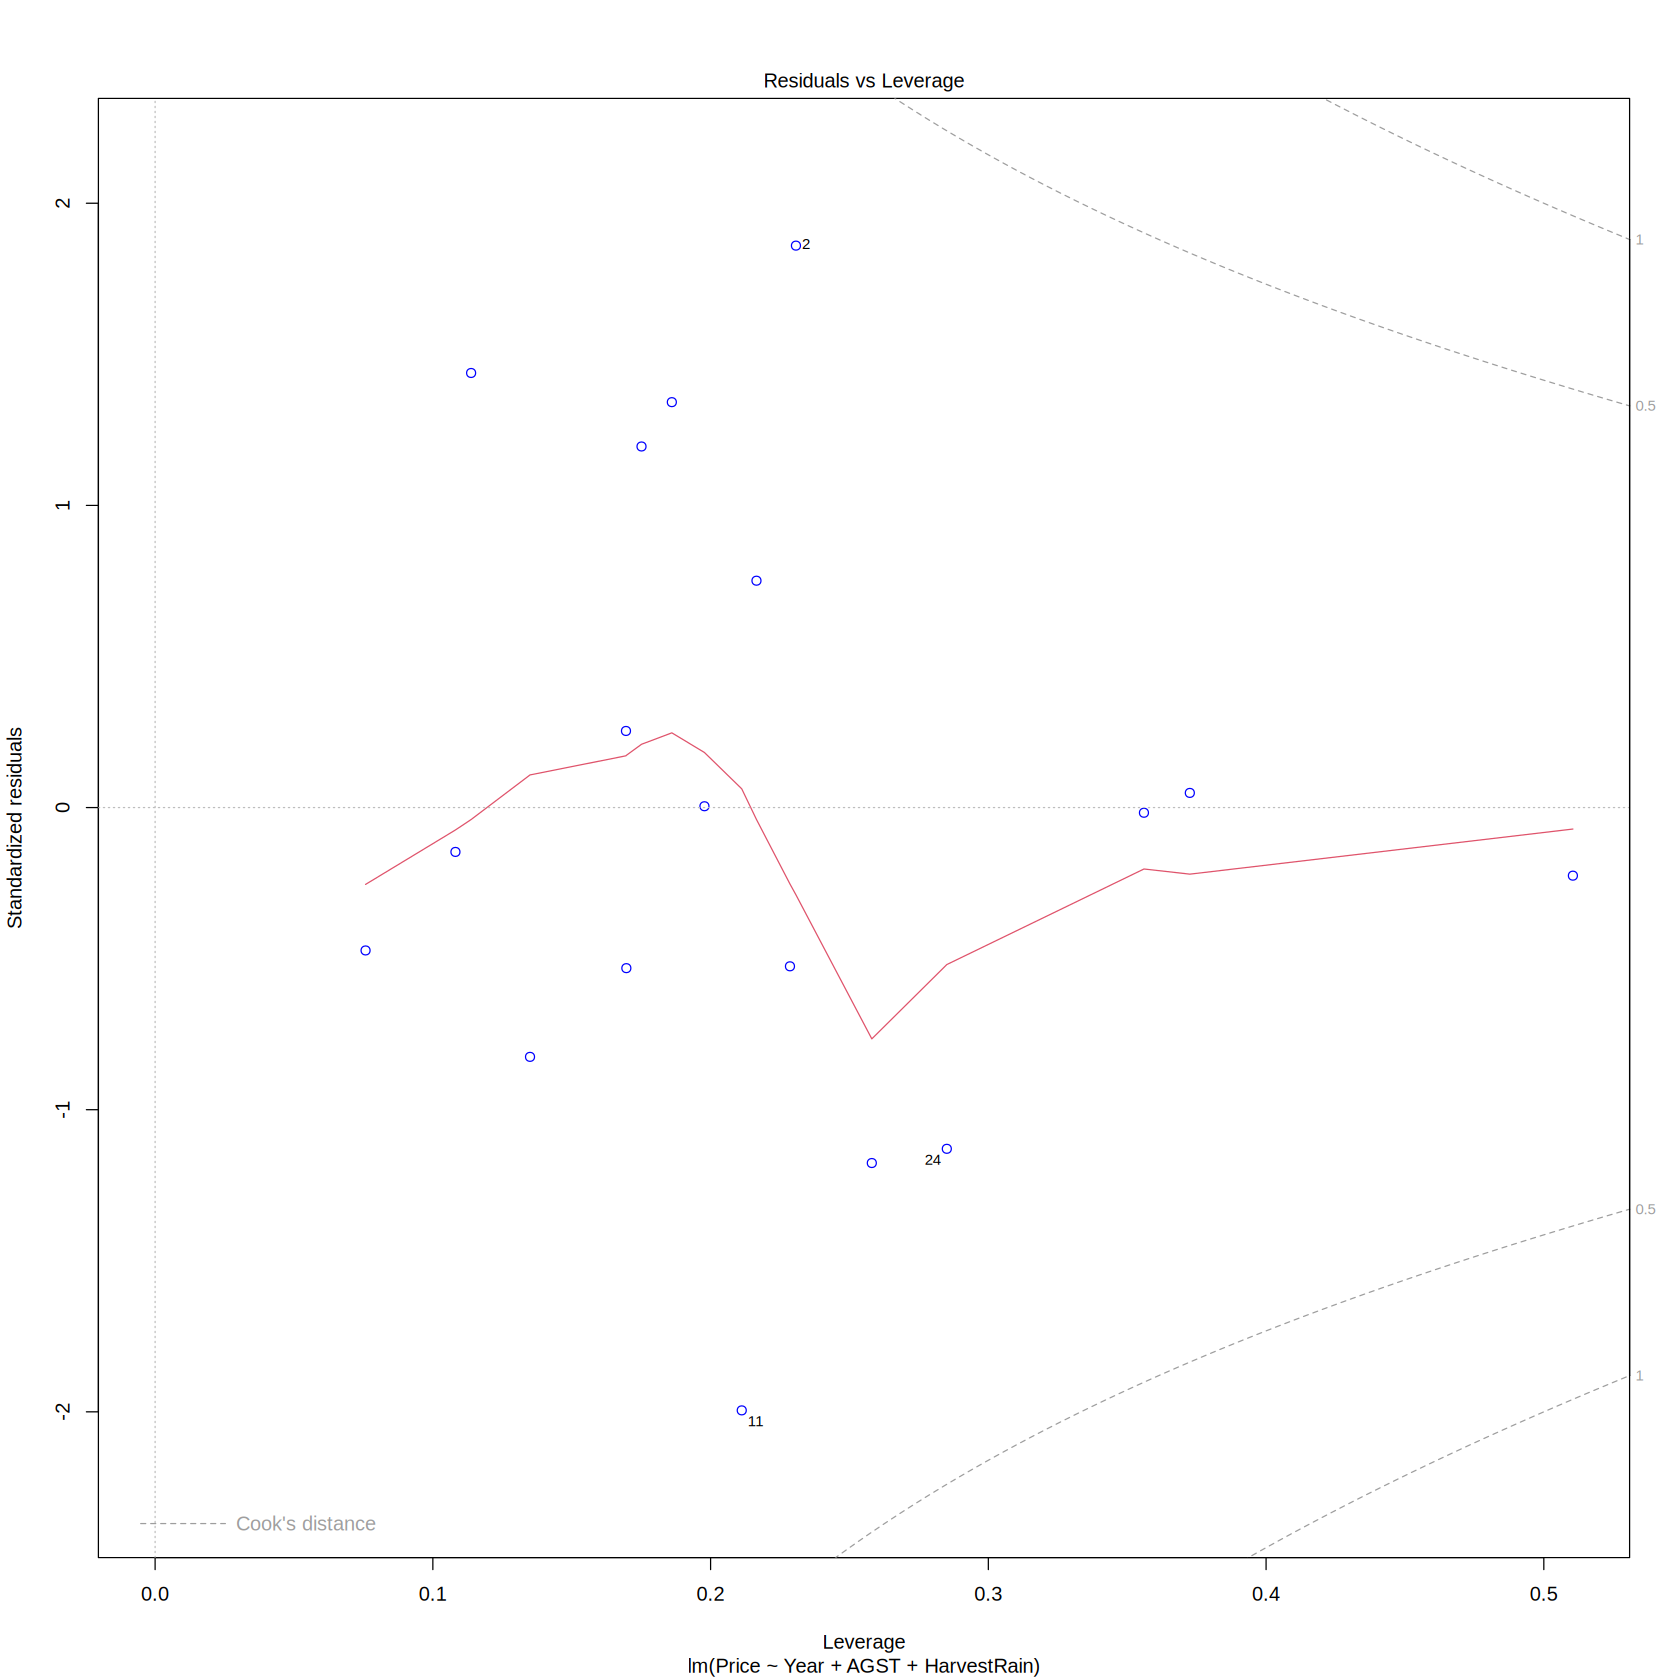

In [31]:
plot(modBIC, which=5, col=c("blue"))  # Residuals vs Leverage

#### Đem mô hình ra thi thật!!!

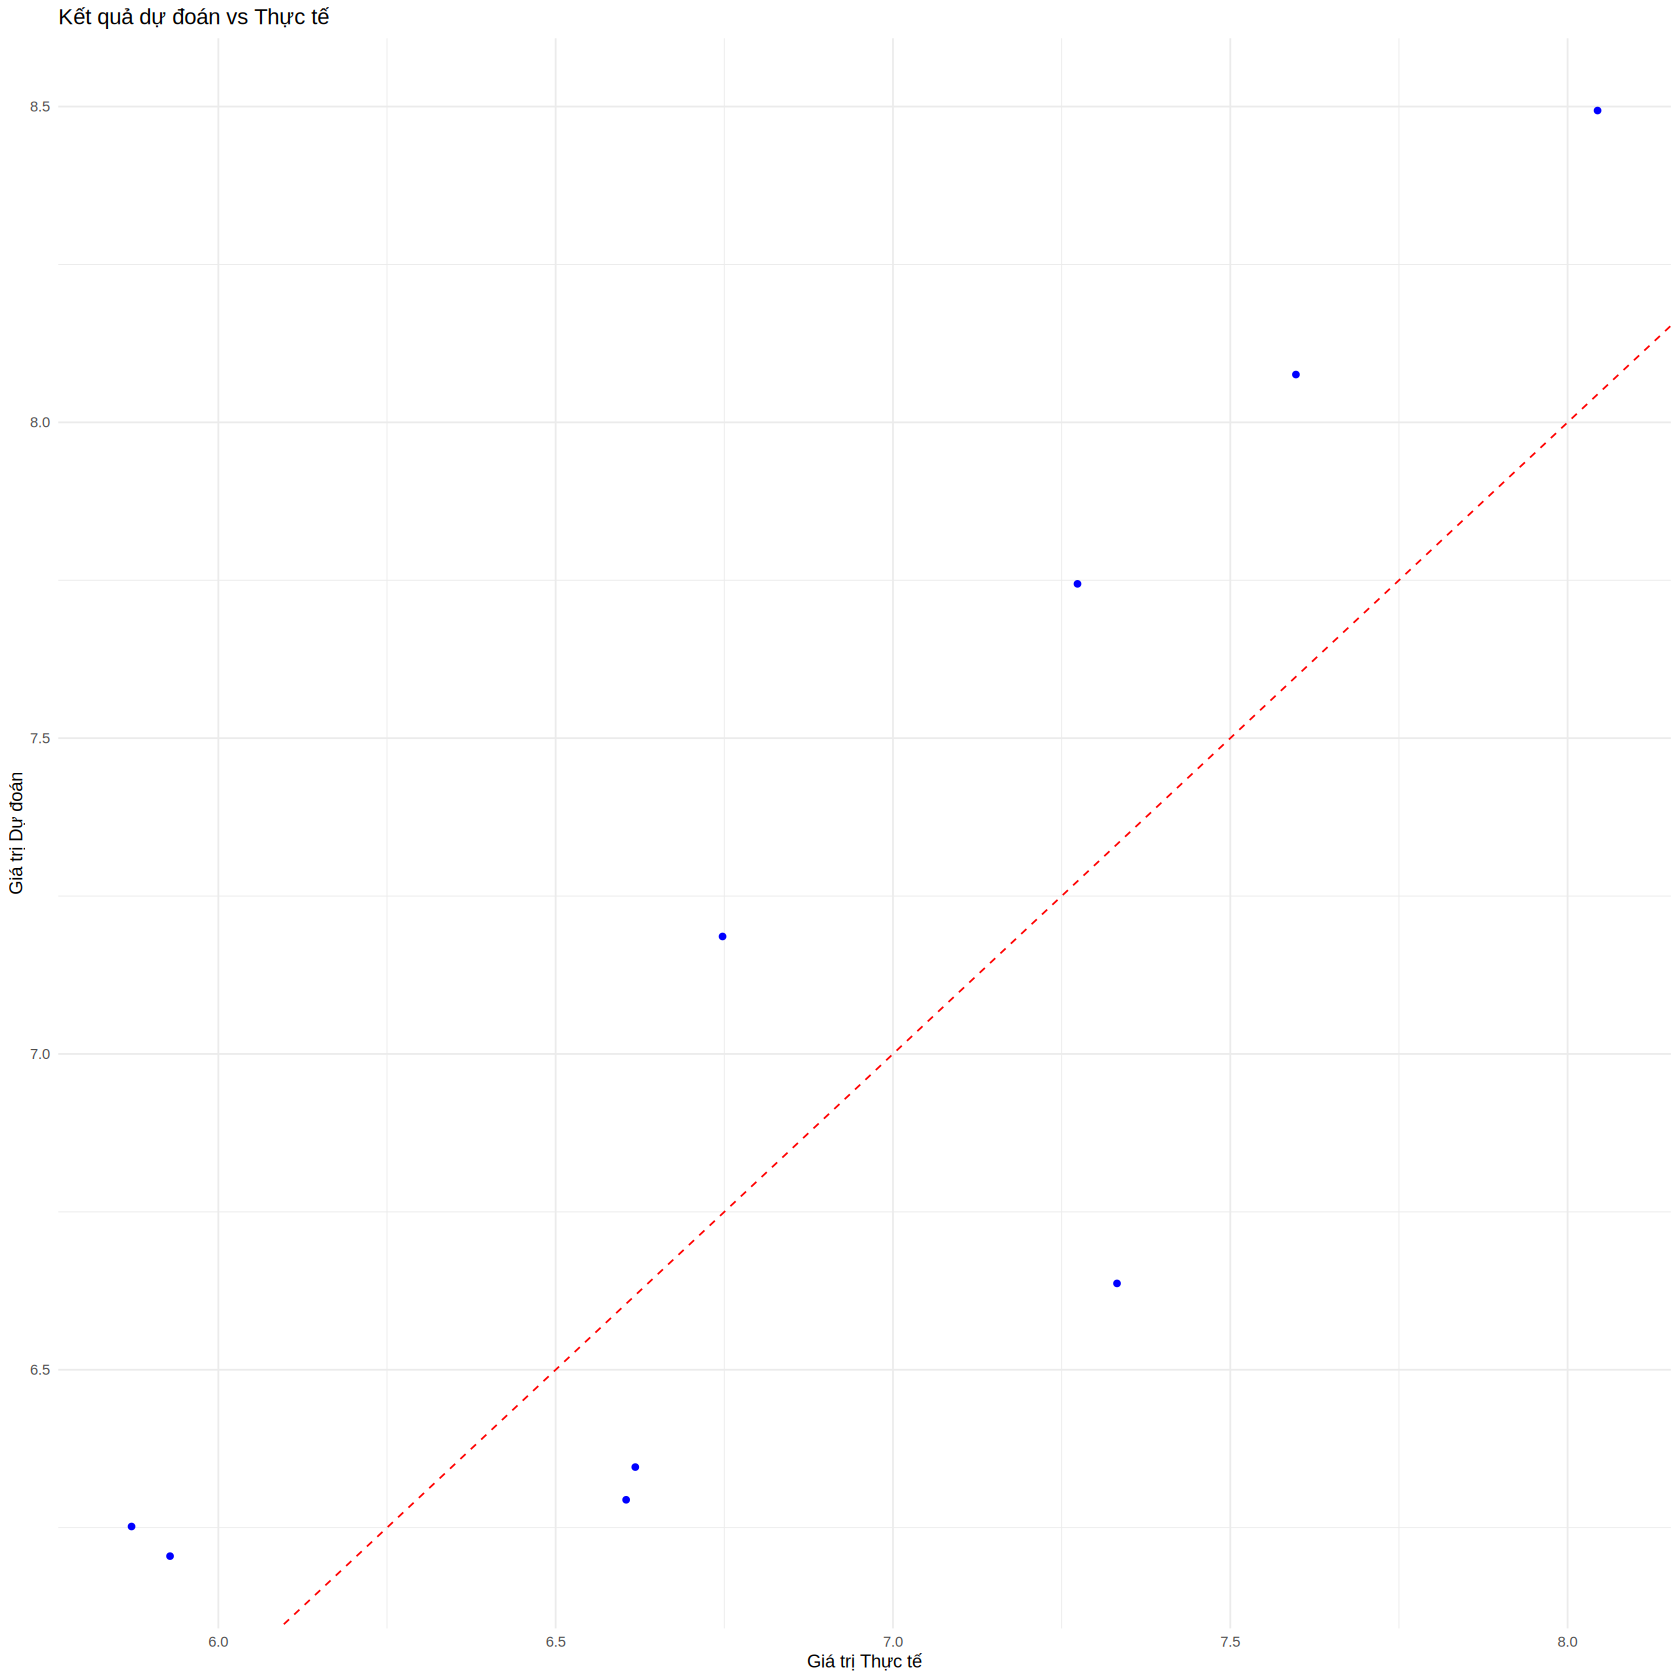

In [32]:
# predict
results <- predict(modBIC, test)
final <- data.frame(
    du_doan <- results,
    label <- test$Price
)

library(ggplot2)
ggplot(final , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') + geom_abline(intercept = 0, slope = 1, color = 'red', linetype = "dashed") +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

In [33]:
rmse(results, test$Price)

[1] 0.4371523

## Giảm chiều dữ liệu

In [34]:
# # Selecting feature
wine_data <- data.frame(scaled_train)[, c("Year", "Age", "AGST", "FrancePop", "HarvestRain", "Price", "WinterRain")]
wine_data

,Year,Age,AGST,FrancePop,HarvestRain,Price,WinterRain
,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>
17,1970,13,16.6667,51918.39,89,7.5883,622
5,1958,25,16.4167,45653.81,187,6.7772,582
1,1952,31,17.1167,43183.57,160,7.4950,600
10,1963,20,15.7167,48798.99,155,6.7127,608
4,1957,26,16.1333,45152.25,110,6.9845,420
18,1971,12,16.7667,52431.65,112,7.1934,551
27,1980,3,16.0000,55110.24,74,6.4979,578
15,1968,15,16.2000,51034.41,292,6.2435,610
7,1960,23,16.4167,46584.00,290,6.5188,763



Loadings:
            Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7
Year         0.507  0.250                       0.411  0.707
Age         -0.507 -0.250                      -0.411  0.707
AGST        -0.260  0.609 -0.170  0.401 -0.610              
FrancePop    0.502  0.263                      -0.813       
HarvestRain               -0.861  0.308  0.402              
Price       -0.366  0.348  0.421  0.391  0.643              
WinterRain   0.177 -0.560  0.207  0.758 -0.193              

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7
SS loadings     1.000  1.000  1.000  1.000  1.000  1.000  1.000
Proportion Var  0.143  0.143  0.143  0.143  0.143  0.143  0.143
Cumulative Var  0.143  0.286  0.429  0.571  0.714  0.857  1.000

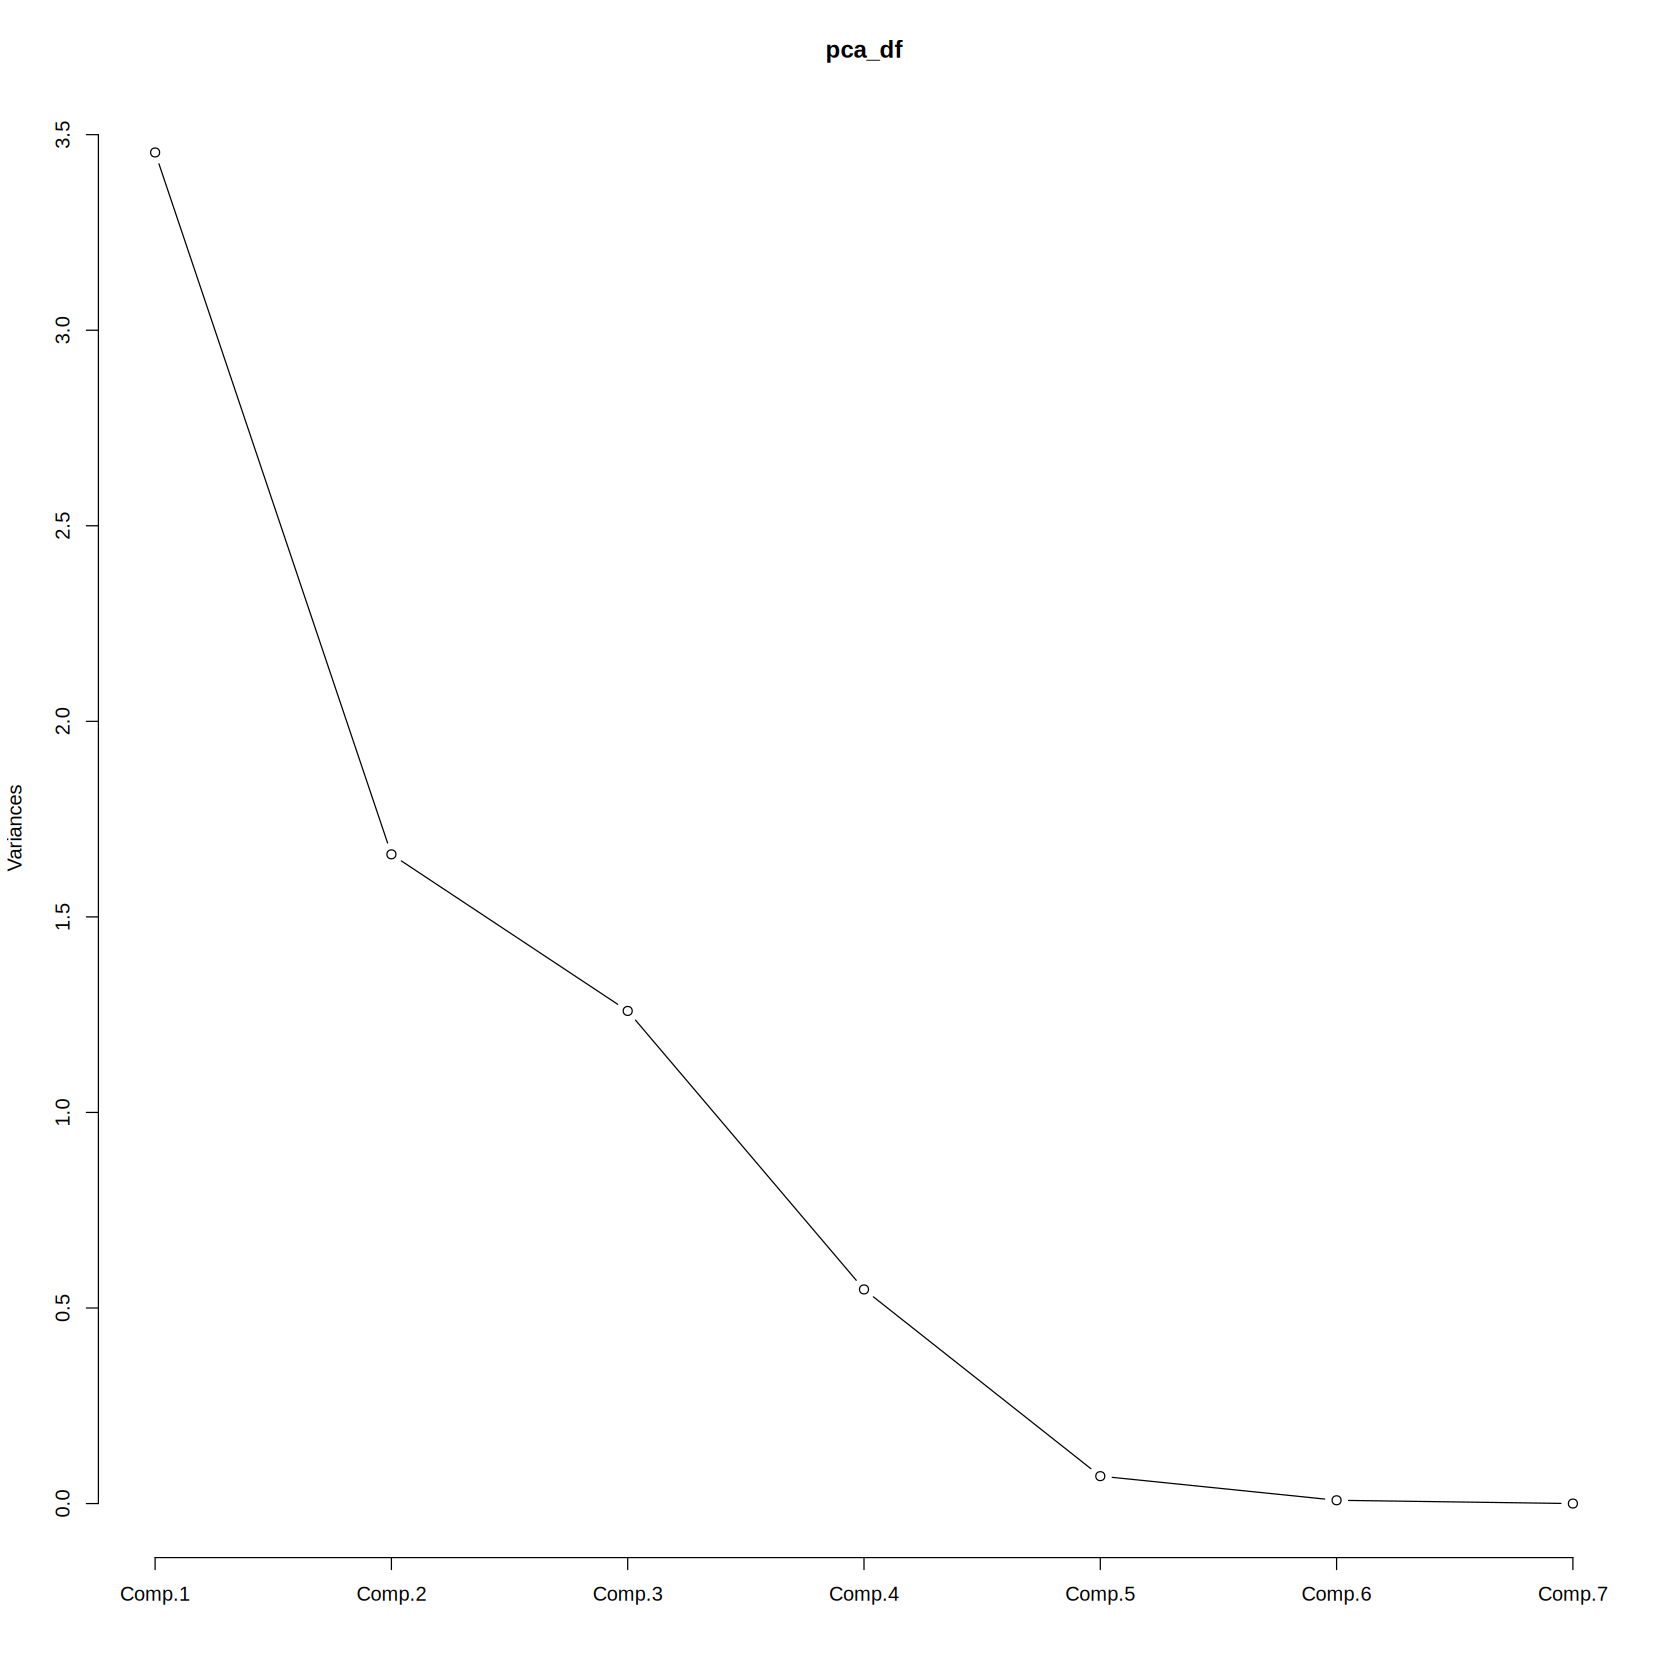

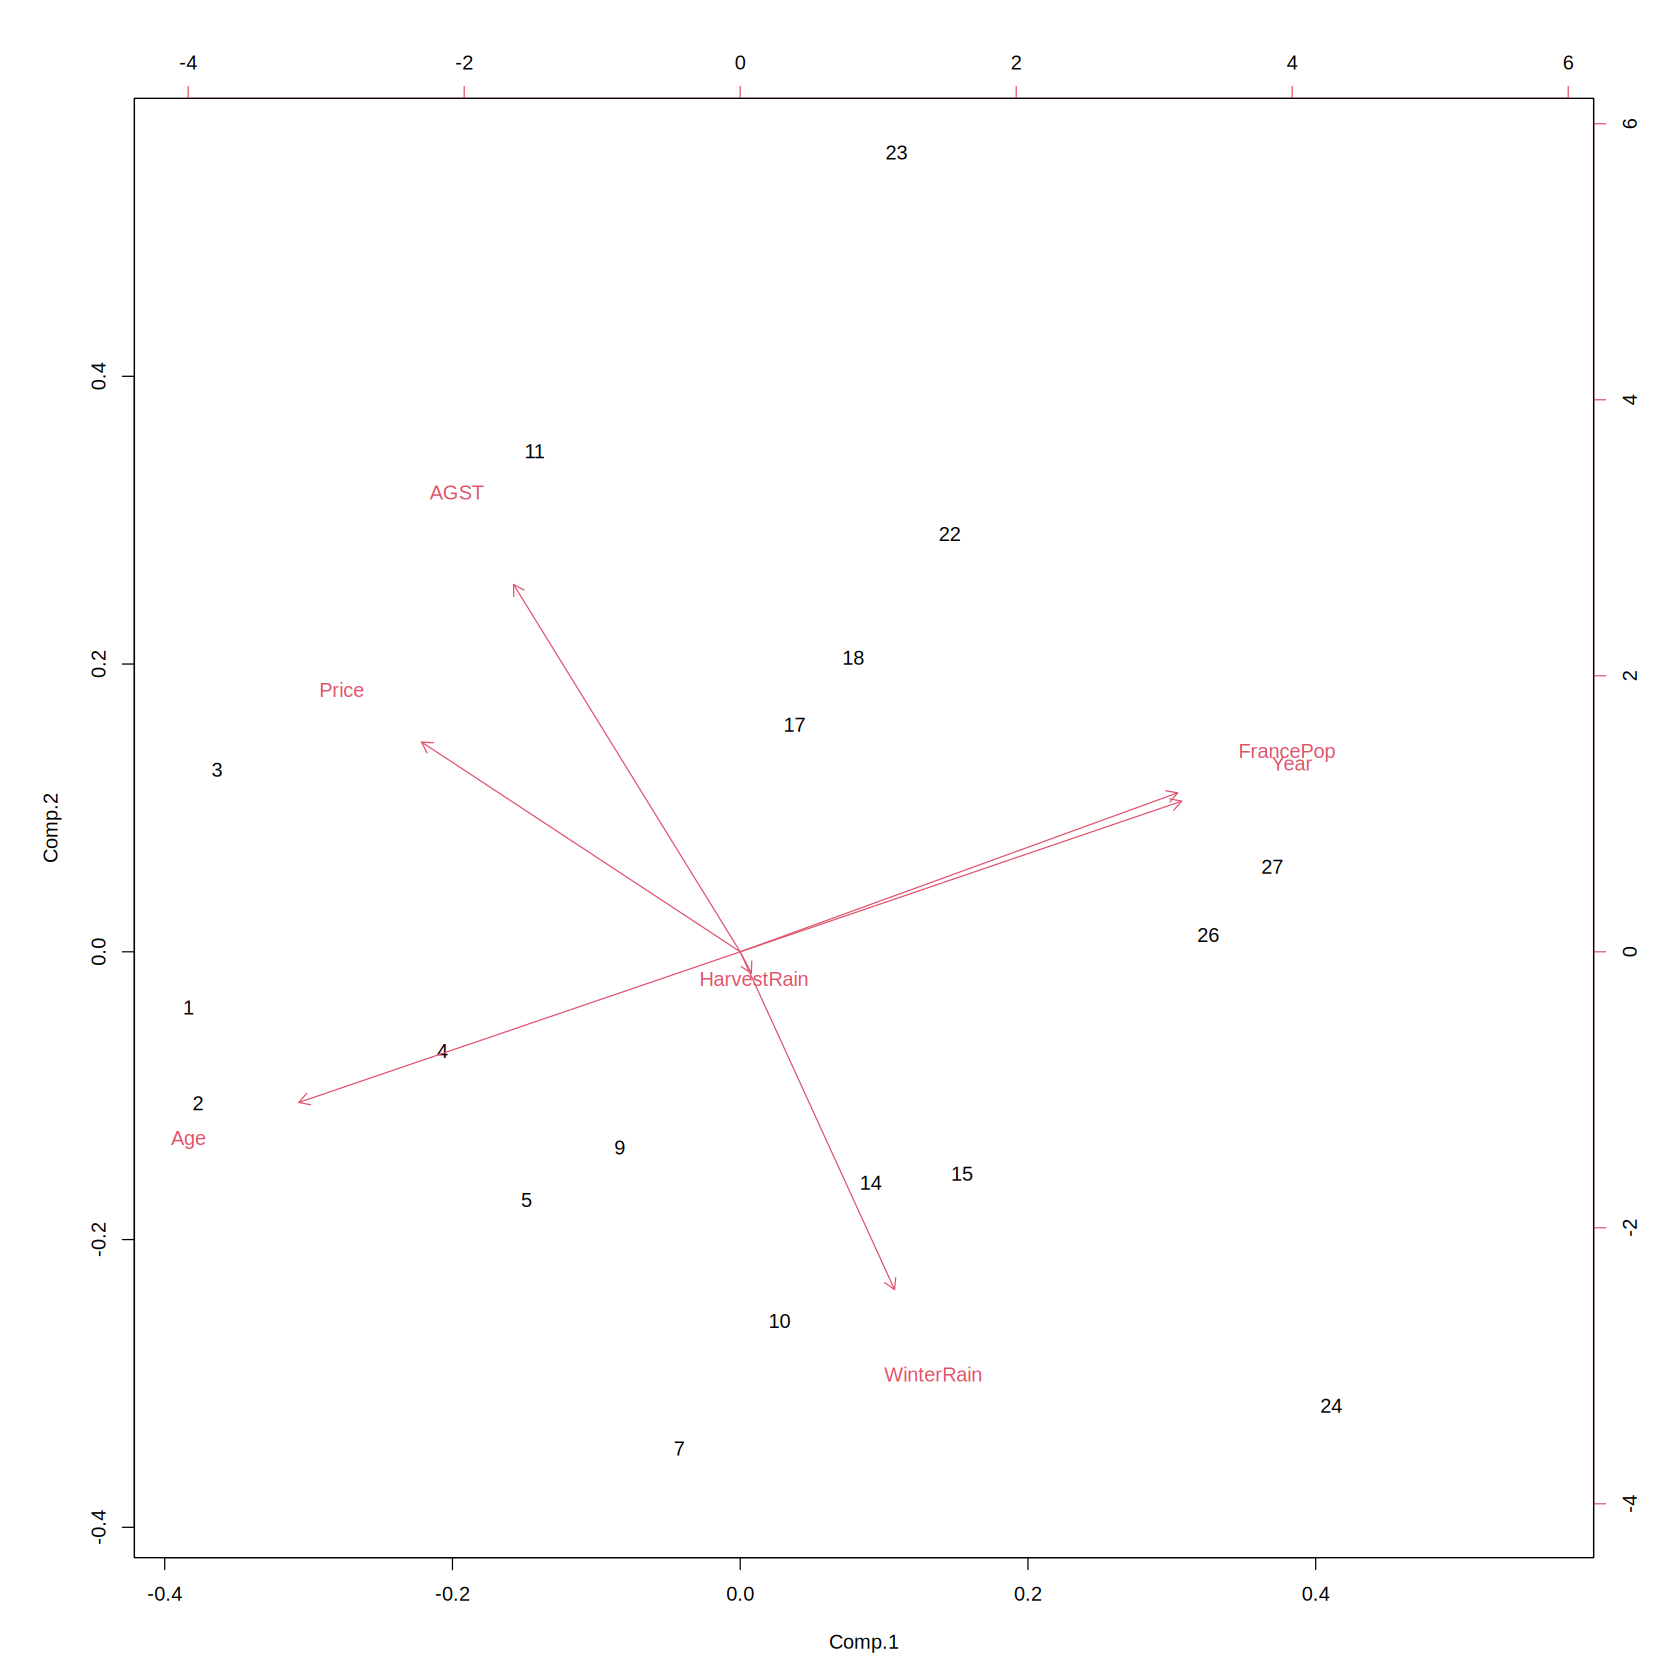

In [35]:
pca_df <- princomp(x = wine_data, fix_sign = TRUE, cor = TRUE)
plot(pca_df, type = "l")
pca_df$loadings
biplot(pca_df, cex = 1)

In [36]:
# Summary of PCA results
print(summary(pca_df))

Importance of components:
                          Comp.1    Comp.2    Comp.3     Comp.4     Comp.5
Standard deviation     1.8586440 1.2883886 1.1222877 0.73993931 0.26469710
Proportion of Variance 0.4935082 0.2371350 0.1799328 0.07821574 0.01000922
Cumulative Proportion  0.4935082 0.7306433 0.9105761 0.98879180 0.99880102
                            Comp.6 Comp.7
Standard deviation     0.091612594      0
Proportion of Variance 0.001198981      0
Cumulative Proportion  1.000000000      1


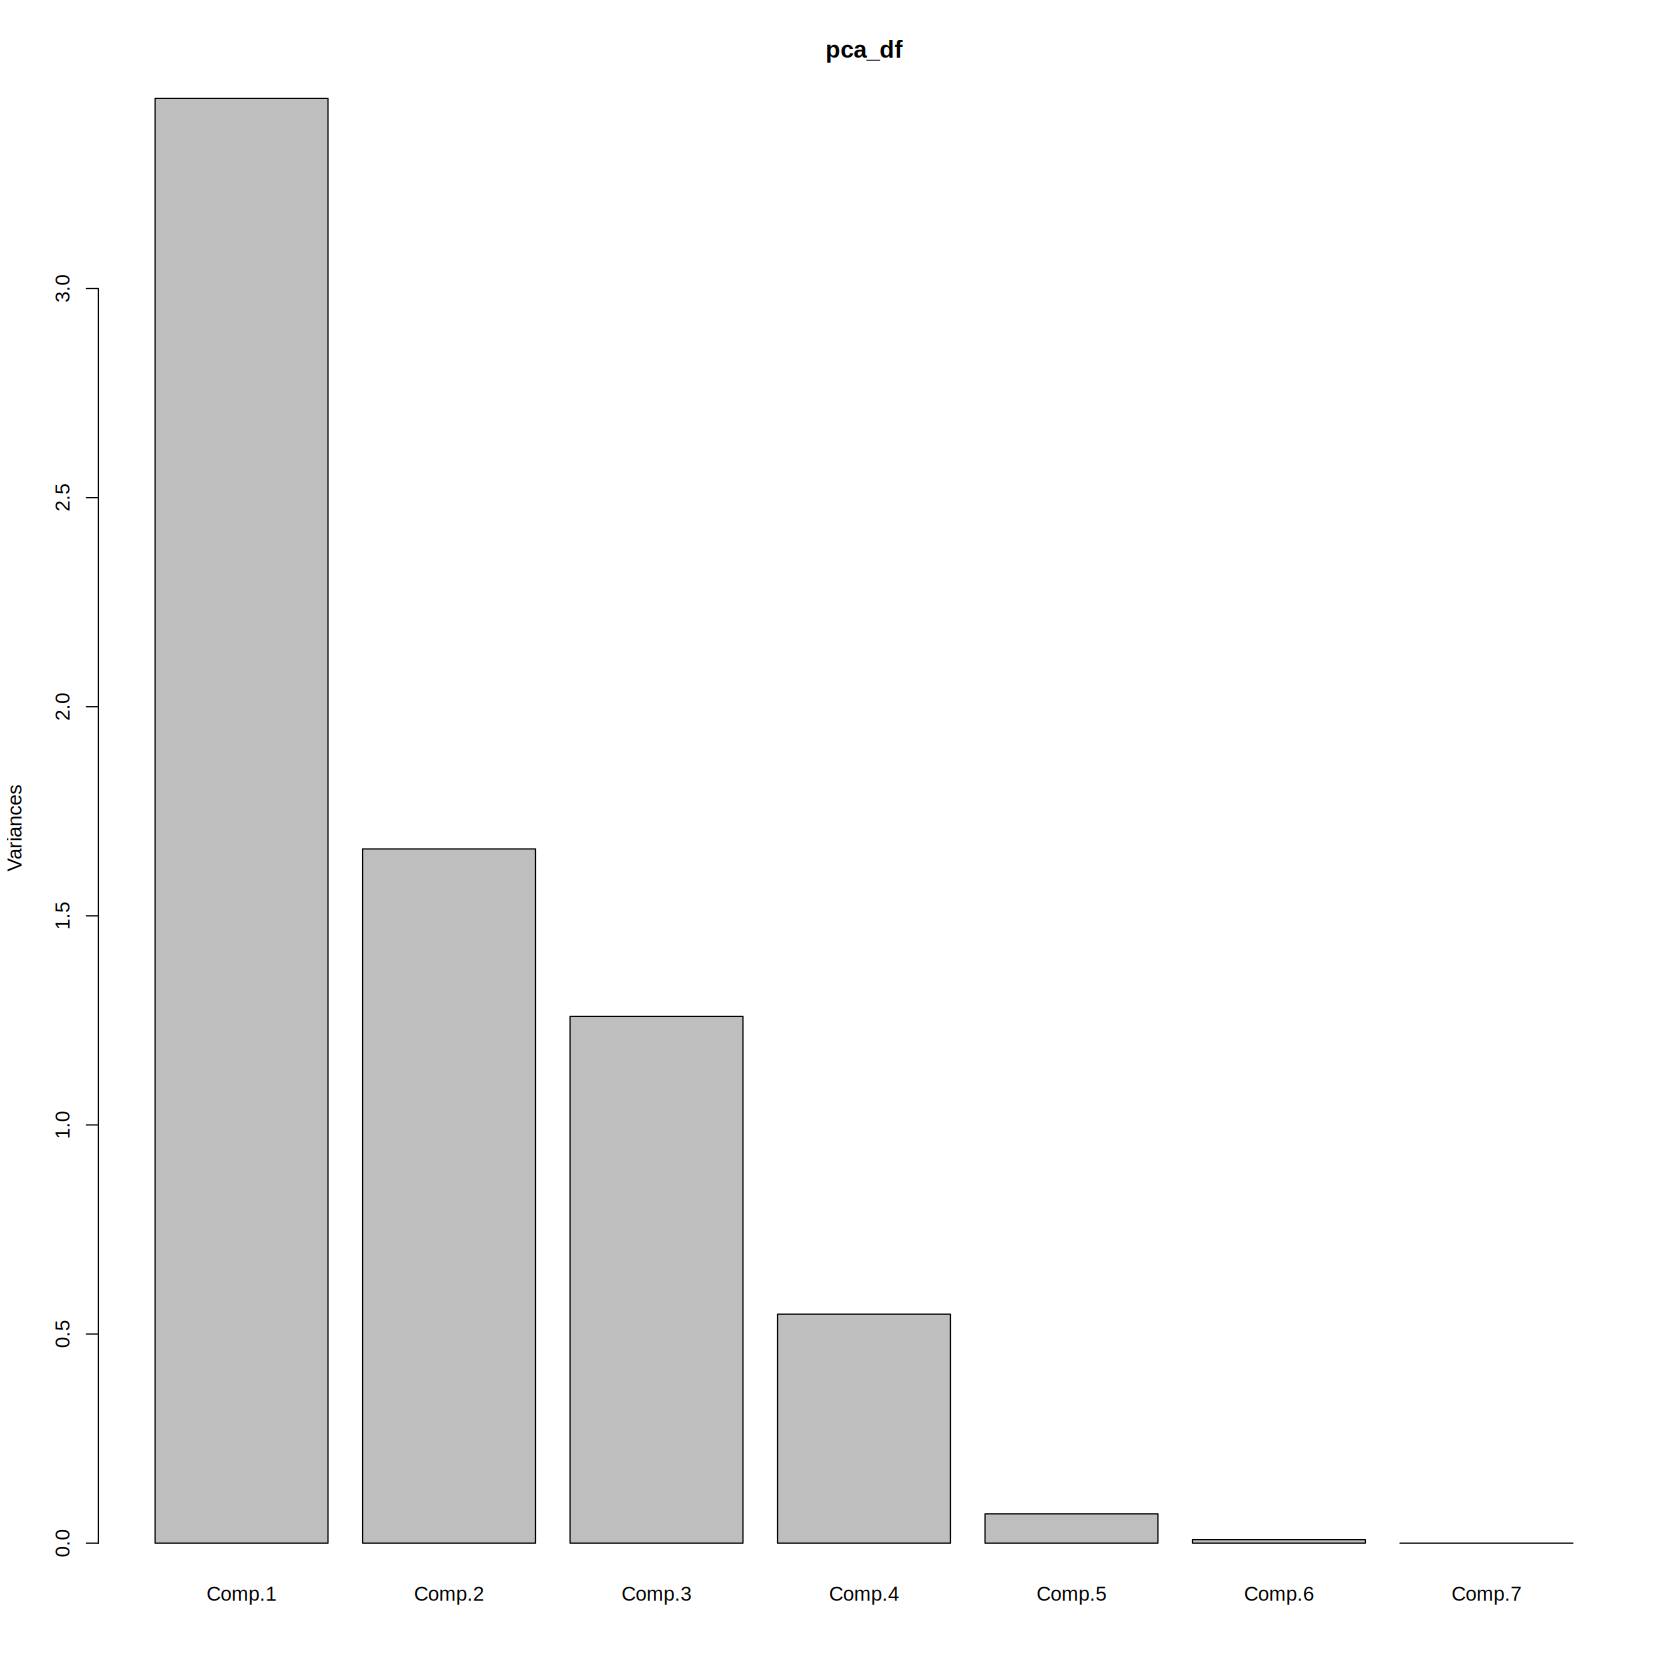

In [37]:
plot(pca_df)

### Mô hình 1

In [38]:
pca_df = princomp(x = wine_data, fix_sign = TRUE, cor = TRUE)
new_pca_df = data.frame("Price" = wine_data$Price, pca_df$scores)
pca_model1 = lm(Price ~., data=new_pca_df)
summary(pca_model1)
modBIC_PCA1 <- MASS::stepAIC(pca_model1, k = log(nrow(scaled_train)), trace = 0)
summary(modBIC_PCA1)
car::vif(modBIC_PCA1)

Warning message in summary.lm(pca_model1):
“essentially perfect fit: summary may be unreliable”



Call:
lm(formula = Price ~ ., data = new_pca_df)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.683e-16 -6.739e-17  3.071e-17  7.076e-17  1.963e-16 

Coefficients:
              Estimate Std. Error    t value Pr(>|t|)    
(Intercept)  7.050e+00  6.879e-15  1.025e+15   <2e-16 ***
Comp.1      -1.778e-01  5.158e-16 -3.447e+14   <2e-16 ***
Comp.2       1.688e-01  1.716e-16  9.837e+14   <2e-16 ***
Comp.3       2.047e-01  2.510e-16  8.154e+14   <2e-16 ***
Comp.4       1.901e-01  5.052e-17  3.764e+15   <2e-16 ***
Comp.5       3.125e-01  1.095e-15  2.853e+14   <2e-16 ***
Comp.6       1.090e-02  1.174e-14  9.282e+11   <2e-16 ***
Comp.7      -3.744e-01  8.362e-01 -4.480e-01    0.664    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.558e-16 on 10 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 2.499e+31 on 7 and 10 DF,  p-value: < 2.2e-16


Warning message:
“attempting model selection on an essentially perfect fit is nonsense”
Warning message:
“attempting model selection on an essentially perfect fit is nonsense”
Warning message in summary.lm(modBIC_PCA1):
“essentially perfect fit: summary may be unreliable”



Call:
lm(formula = Price ~ Comp.1 + Comp.2 + Comp.3 + Comp.4 + Comp.5 + 
    Comp.6, data = new_pca_df)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.468e-16 -5.944e-17  2.775e-17  5.007e-17  2.055e-16 

Coefficients:
              Estimate Std. Error    t value Pr(>|t|)    
(Intercept)  7.050e+00  3.536e-17  1.994e+17   <2e-16 ***
Comp.1      -1.778e-01  1.902e-17 -9.345e+15   <2e-16 ***
Comp.2       1.688e-01  2.745e-17  6.151e+15   <2e-16 ***
Comp.3       2.047e-01  3.151e-17  6.496e+15   <2e-16 ***
Comp.4       1.901e-01  4.779e-17  3.978e+15   <2e-16 ***
Comp.5       3.125e-01  1.336e-16  2.339e+15   <2e-16 ***
Comp.6       1.090e-02  3.860e-16  2.823e+13   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.5e-16 on 11 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 3.144e+31 on 6 and 11 DF,  p-value: < 2.2e-16


Warning message in summary.lm(object, ...):
“essentially perfect fit: summary may be unreliable”


Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 
     1      1      1      1      1      1

### Mô hình 2

In [39]:
pca_df = princomp(x = wine_data, fix_sign = TRUE, cor = TRUE)
new_pca_df = data.frame("Price" = wine_data$Price, pca_df$scores[, 1:2])
pca_model2 = lm(Price ~., data=new_pca_df)
summary(pca_model2)
modBIC_PCA2 <- MASS::stepAIC(pca_model2, k = log(nrow(train)), trace = 0)
summary(modBIC_PCA2)
car::vif(modBIC_PCA2)


Call:
lm(formula = Price ~ ., data = new_pca_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.44804 -0.26949 -0.02379  0.15260  0.55825 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.04997    0.07275  96.907  < 2e-16 ***
Comp.1      -0.17778    0.03914  -4.542 0.000389 ***
Comp.2       0.16882    0.05647   2.990 0.009163 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3087 on 15 degrees of freedom
Multiple R-squared:  0.6634,	Adjusted R-squared:  0.6186 
F-statistic: 14.78 on 2 and 15 DF,  p-value: 0.0002837



Call:
lm(formula = Price ~ Comp.1 + Comp.2, data = new_pca_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.44804 -0.26949 -0.02379  0.15260  0.55825 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.04997    0.07275  96.907  < 2e-16 ***
Comp.1      -0.17778    0.03914  -4.542 0.000389 ***
Comp.2       0.16882    0.05647   2.990 0.009163 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3087 on 15 degrees of freedom
Multiple R-squared:  0.6634,	Adjusted R-squared:  0.6186 
F-statistic: 14.78 on 2 and 15 DF,  p-value: 0.0002837


Comp.1 Comp.2 
     1      1

### Phân tích kết quả

#### Residuals vs Fitted Plot

Biểu đồ **Residuals vs Fitted Plot** đưa ra dấu hiệu nếu có các mẫu phi tuyến tính. Để hồi quy tuyến tính chính xác, dữ liệu cần phải tuyến tính nên điều này sẽ kiểm tra xem điều kiện đó có được đáp ứng hay không.

Đối với Mô hình 1

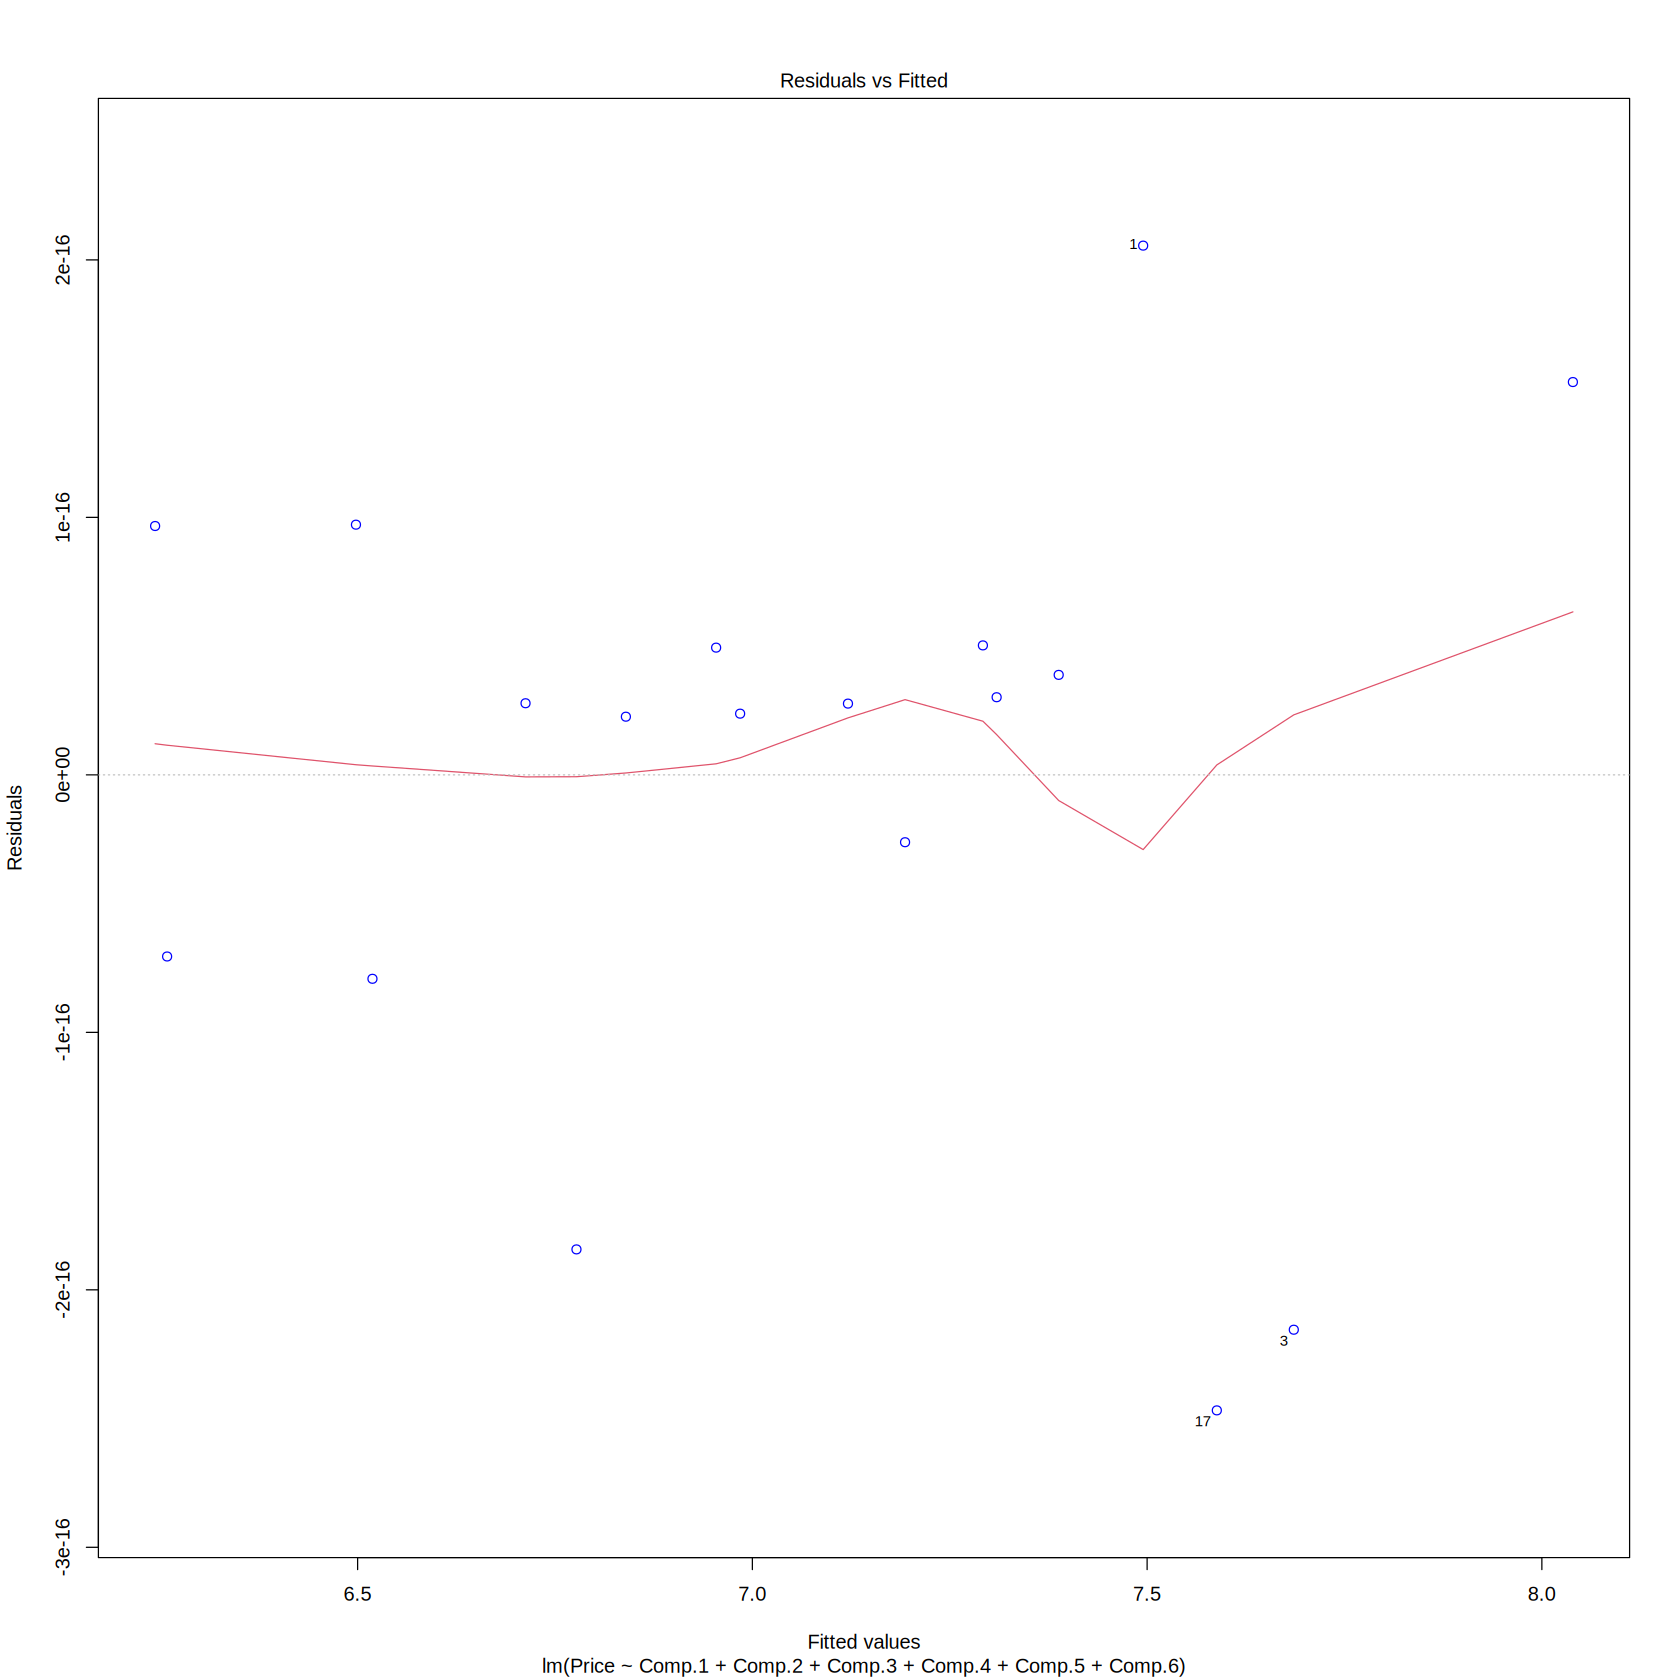

In [40]:
plot(modBIC_PCA1, which=1, col=c("blue")) # Residuals vs Fitted Plot

Đối với mô hình 2

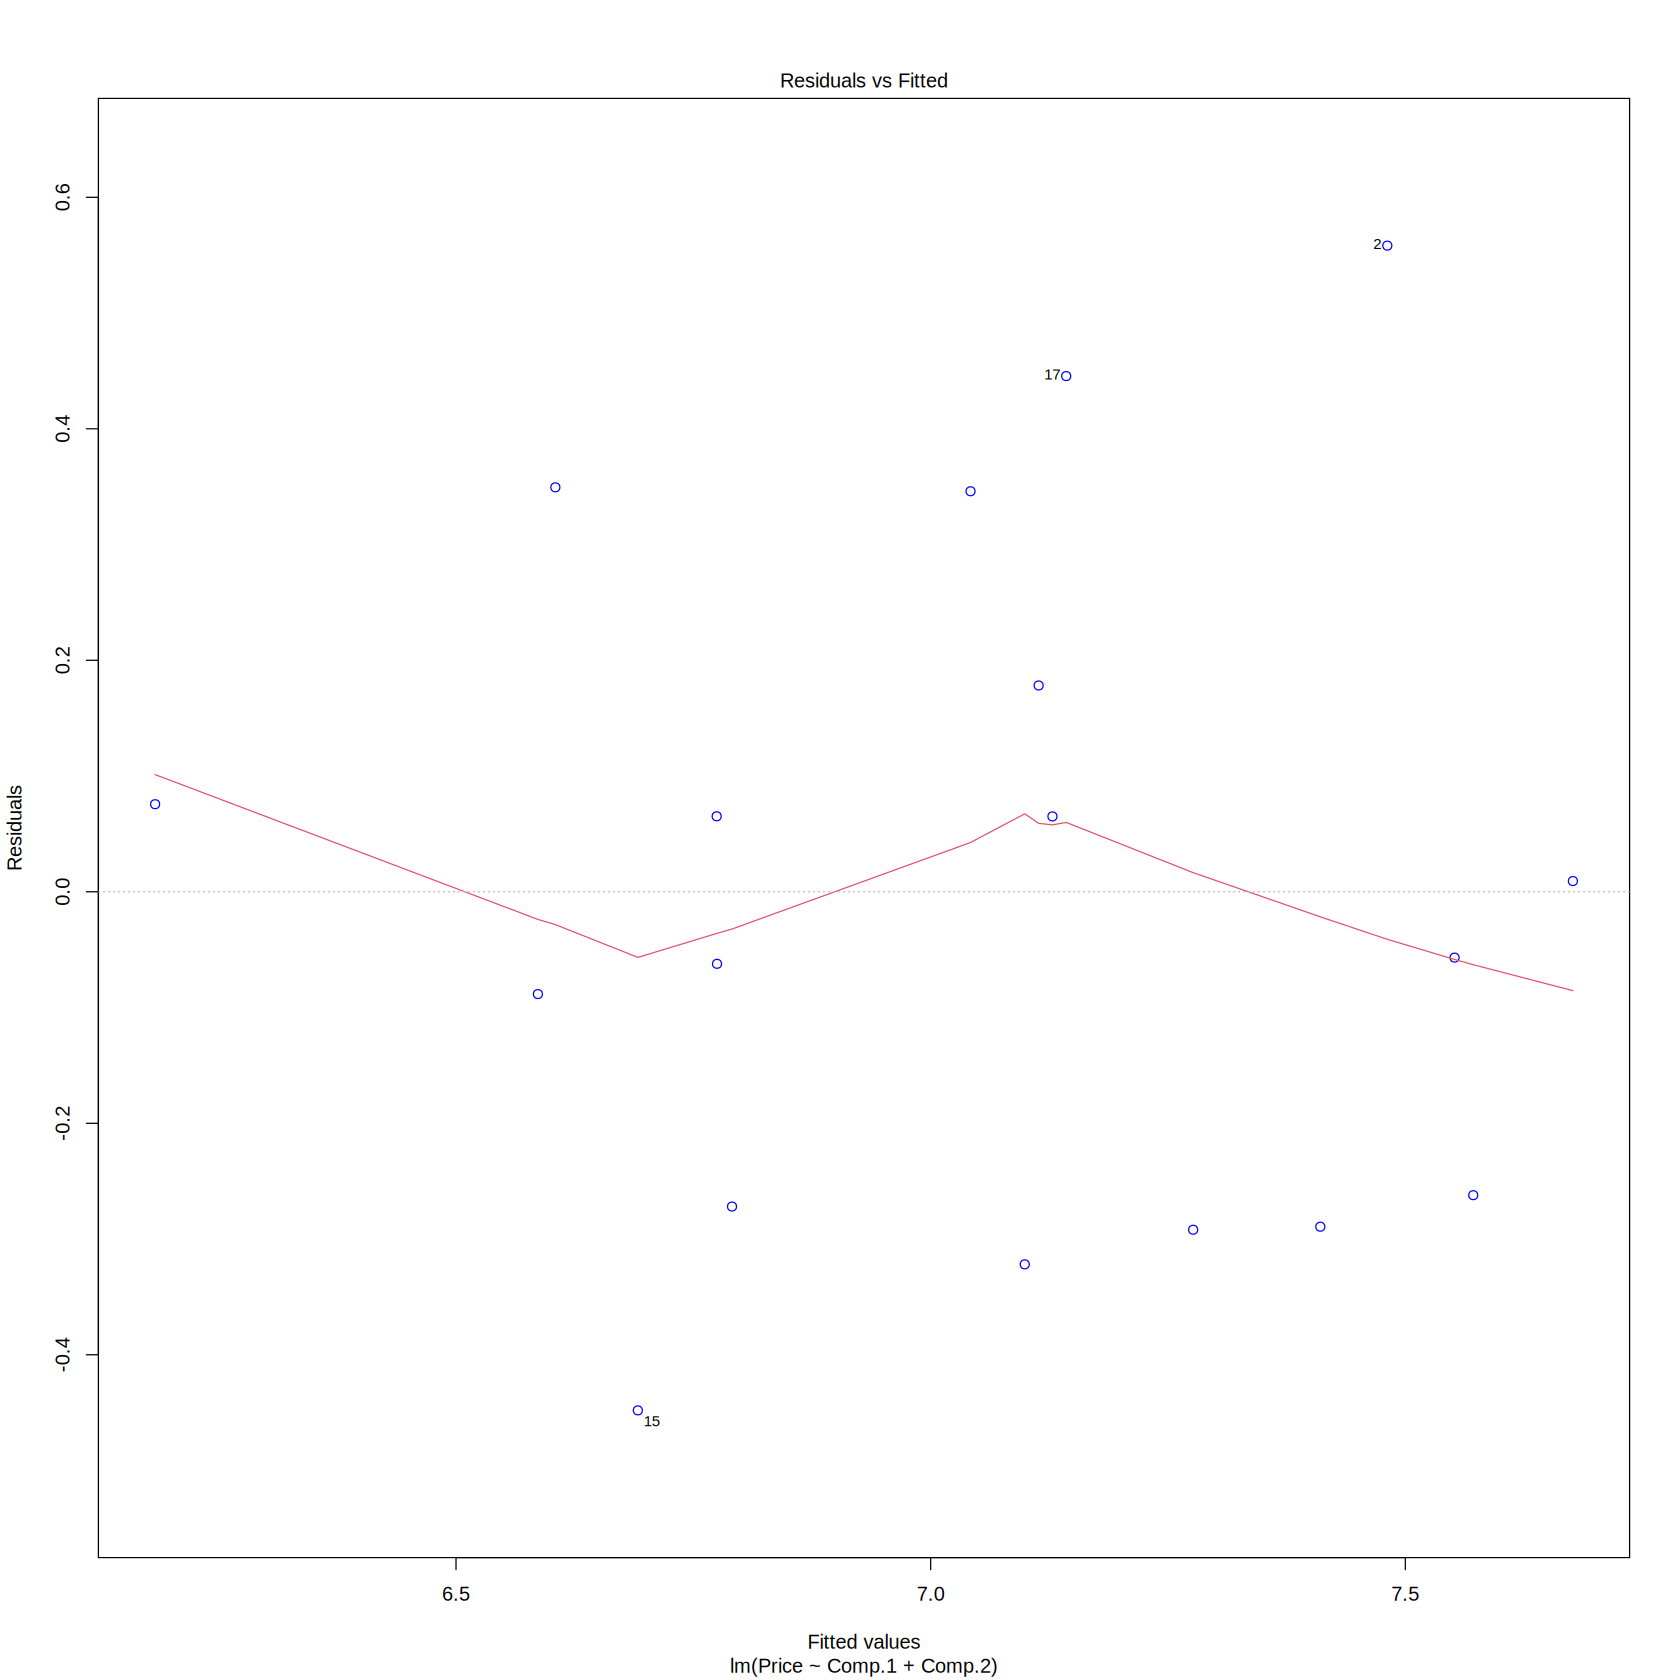

In [41]:
plot(modBIC_PCA2, which=1, col=c("blue")) # Residuals vs Fitted Plot

#### Normal Q–Q (quantile-quantile) Plot

Các giá trị thặng dư (residual) nên có phân phối chuẩn. Để kiểm tra điều này, chúng ta cần quan sát biểu đồ QQ Residuals plot, nếu các điểm được xếp thành một đường thẳng (hoặc gần như thẳng) thì chứng tỏ các giá trị thặng dư (residual) có phân phối chuẩn. Như hình vẽ kết quả ở trên, ta thấy rõ điều đó, residual có phân phối chuẩn.

Đối với mô hình 1

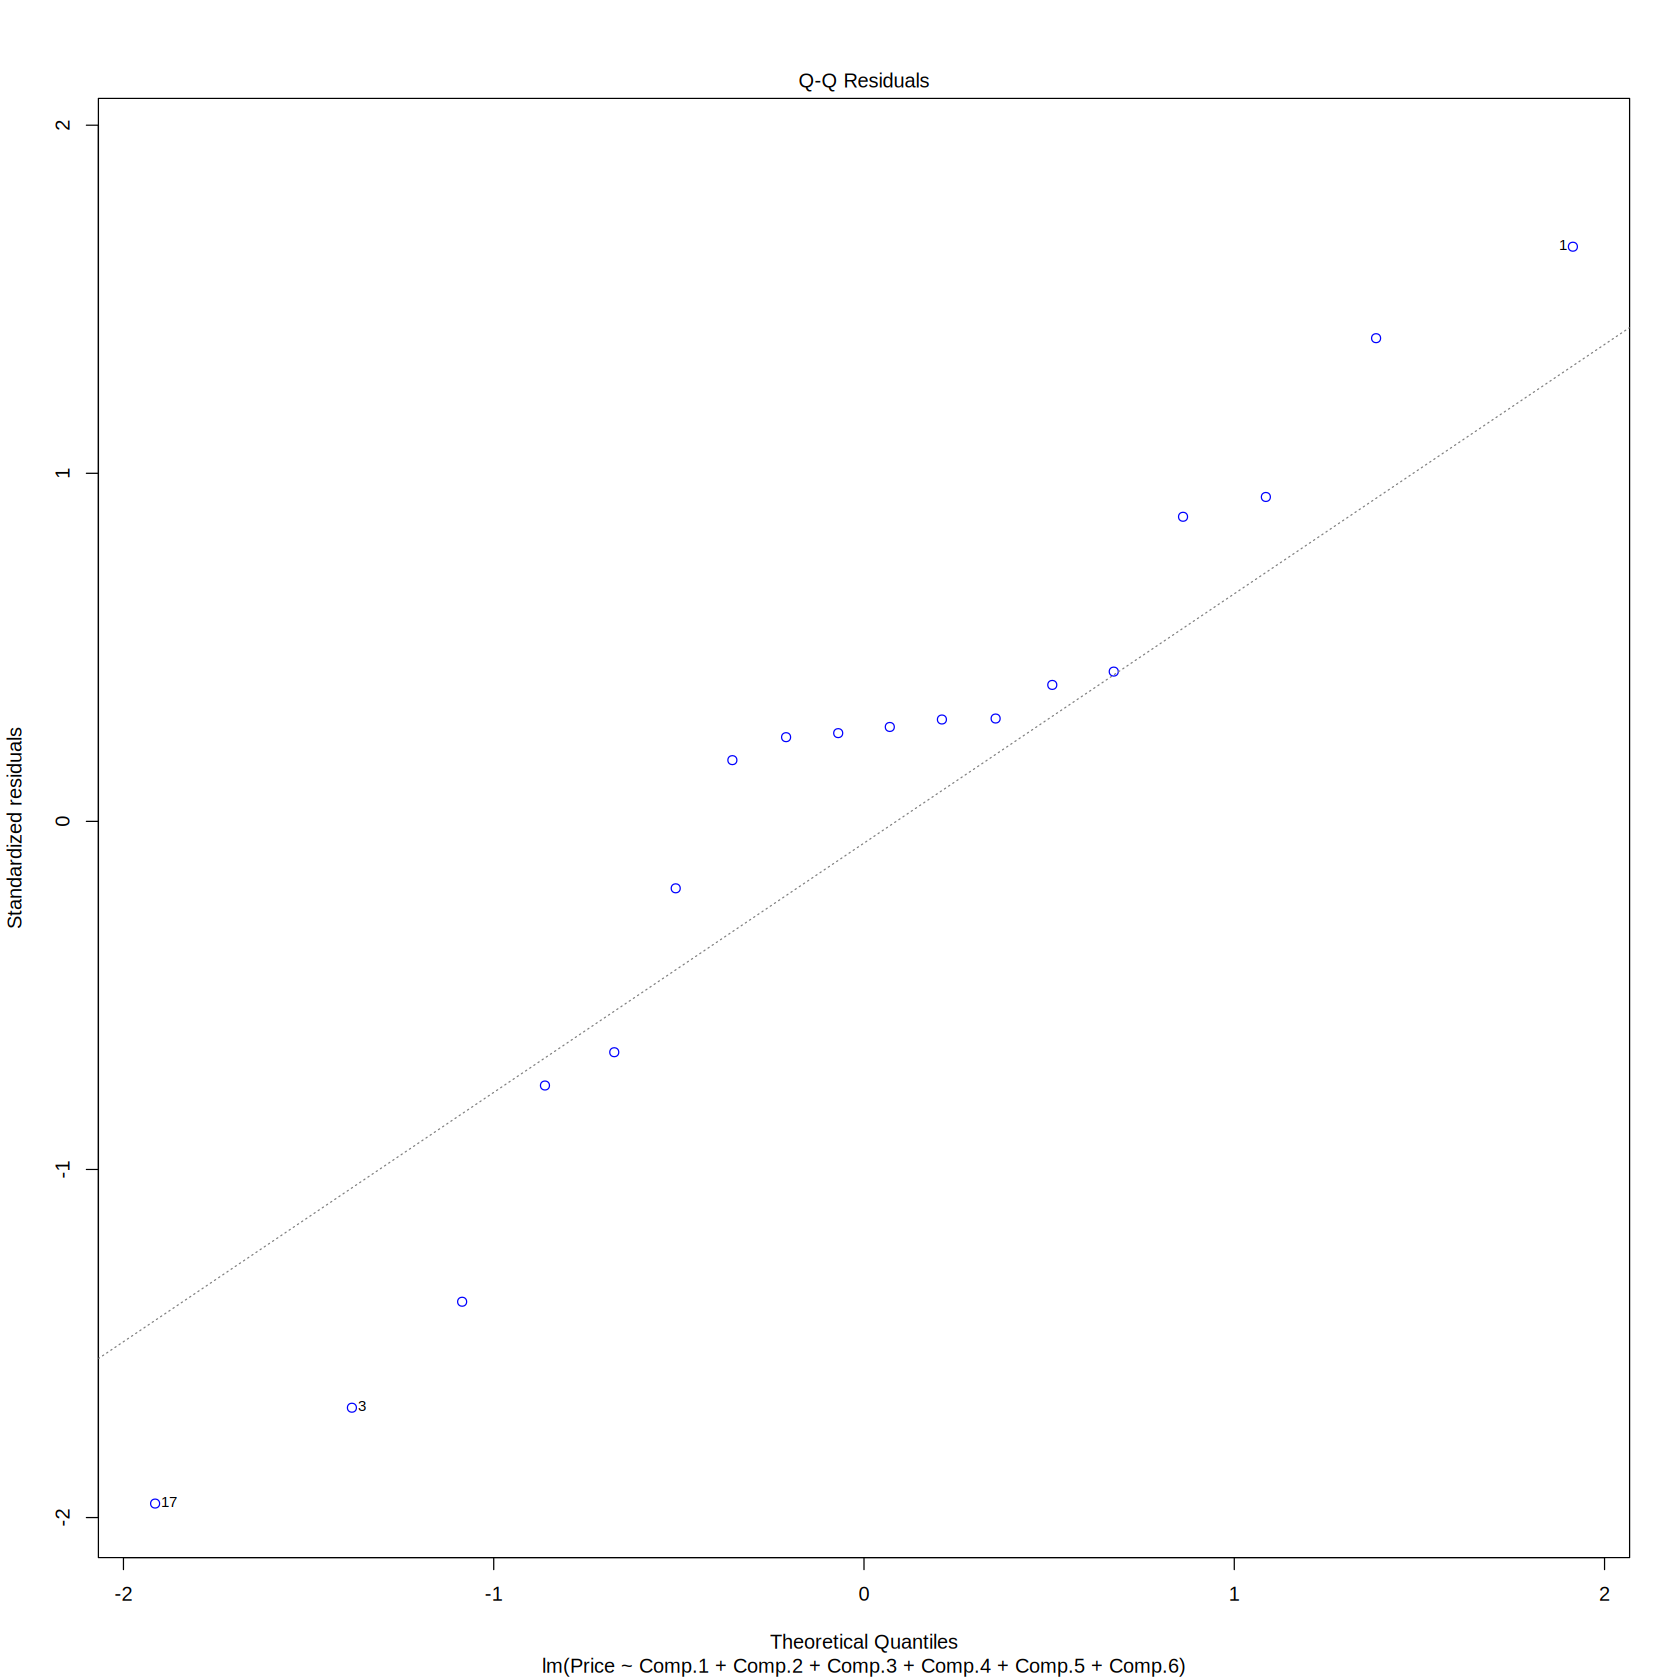

In [42]:
plot(modBIC_PCA1, which=2, col=c("blue")) # QQ Plot

Cẩn thận hơn, chúng ta thử dùng Shapiro–Wilk test để kiểm tra có đúng thật là các giá trị thặng dư có phân phối chuẩn hay không?
- H0: Biến thặng dư của mô hình phân phối chuẩn trong một số quần thể.
- H1: Biến thặng dư của mô hình không phân phối chuẩn trong một số quần thể.

In [43]:
print(shapiro.test(residuals(modBIC_PCA1)))


	Shapiro-Wilk normality test

data:  residuals(modBIC_PCA1)
W = 0.92332, p-value = 0.148



Ta thấy p-value >0.05, ta chưa đủ cơ sở để bác bỏ H0.

Đối với mô hình 2

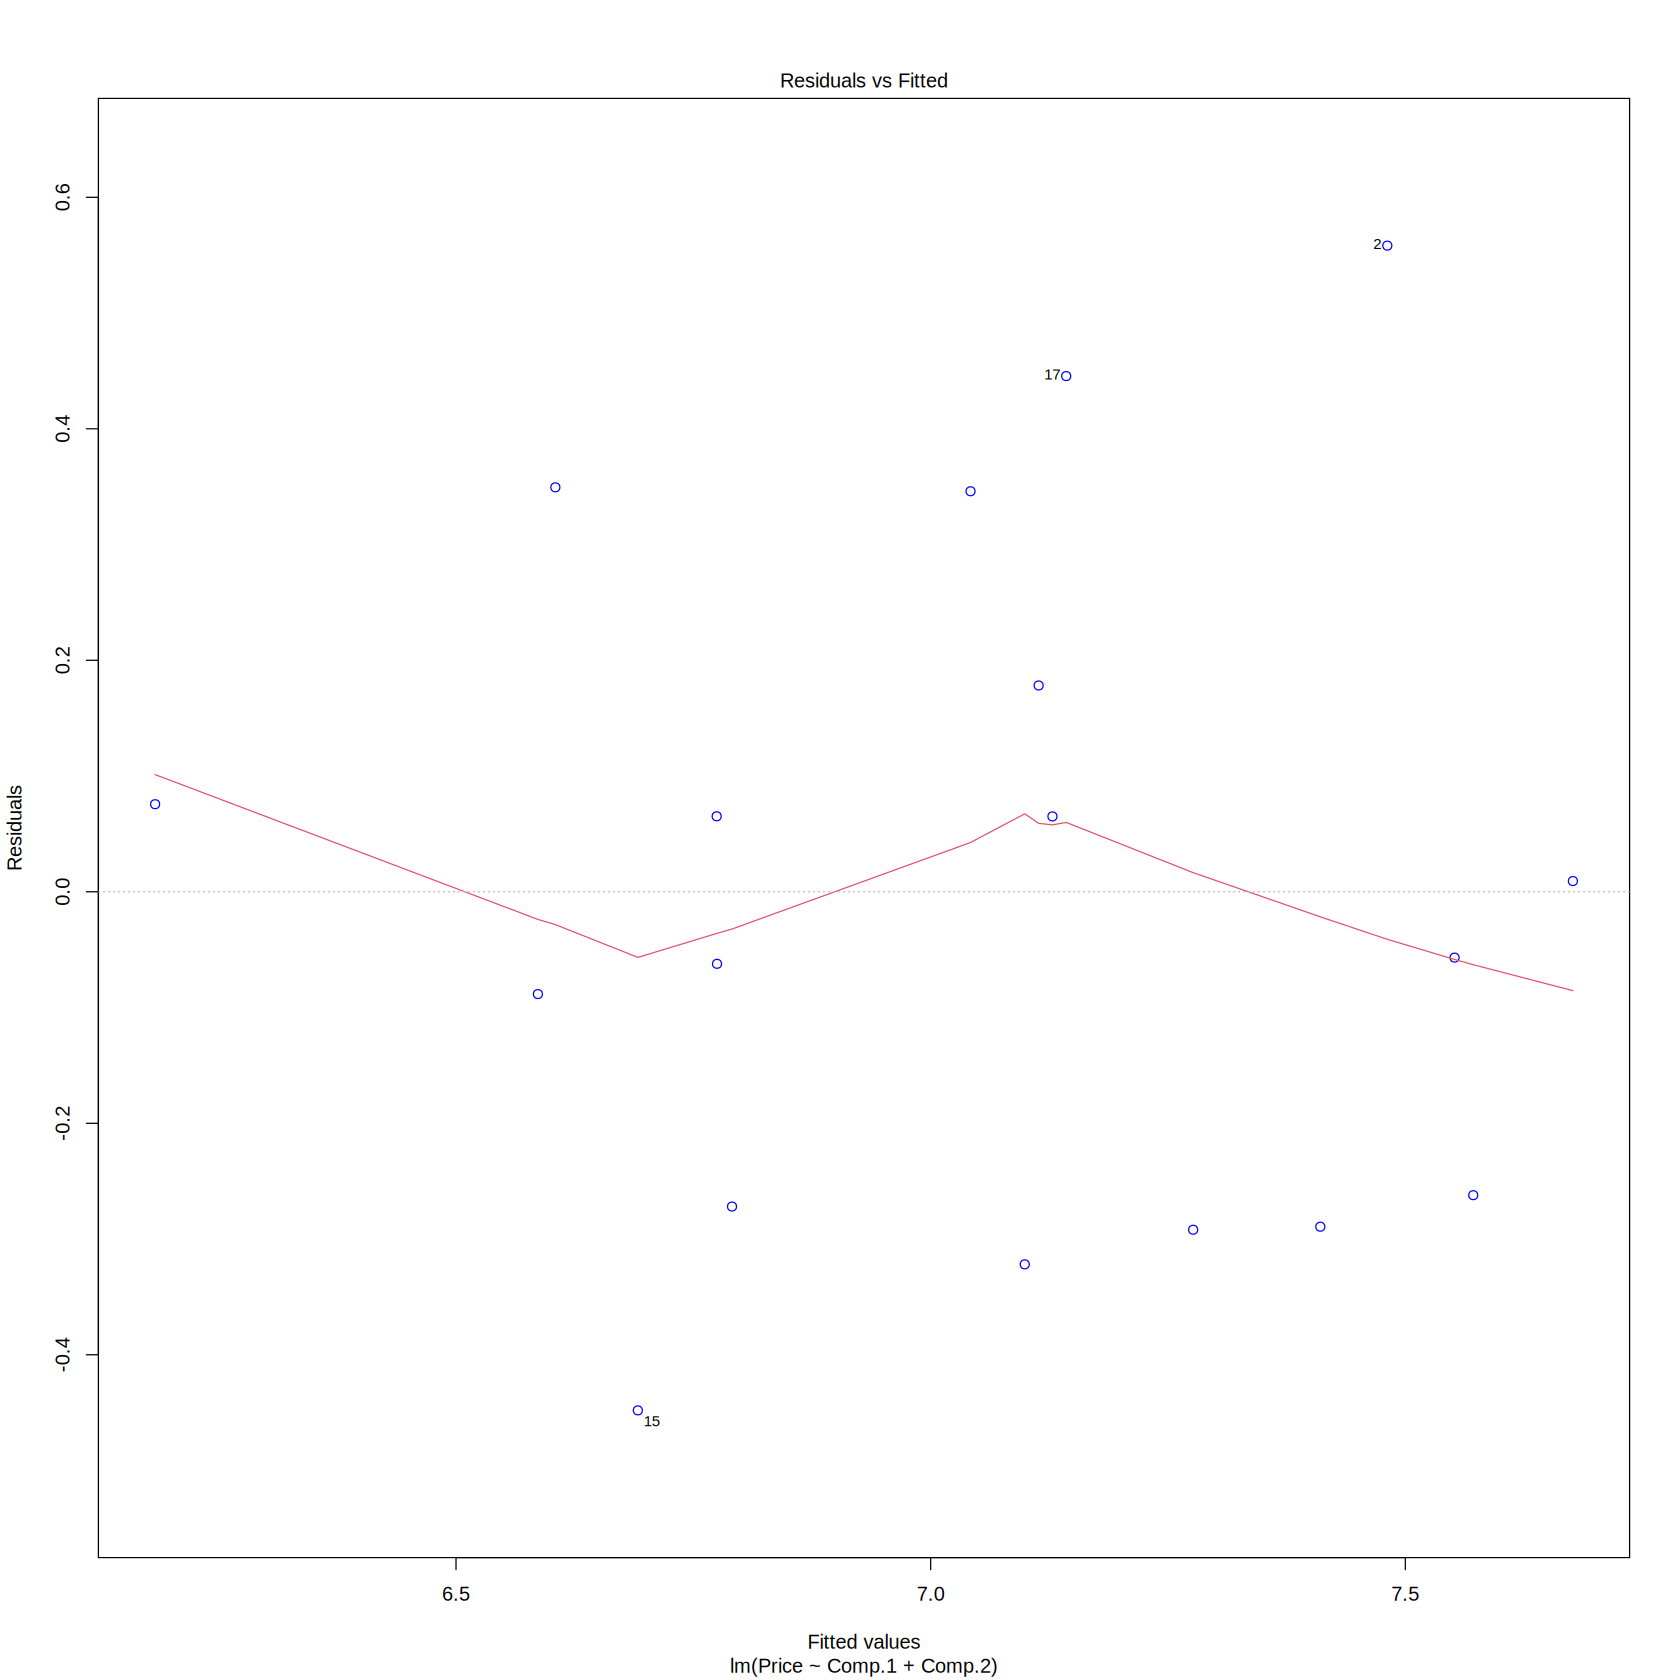

In [44]:
plot(modBIC_PCA2, which=1, col=c("blue")) # Residuals vs Fitted Plot

In [45]:
print(shapiro.test(residuals(modBIC_PCA2)))


	Shapiro-Wilk normality test

data:  residuals(modBIC_PCA2)
W = 0.95126, p-value = 0.445



Ta cũng nhận được kết quả tương tự.

#### Scale-Location

Biểu đồ scale-location kiểm định giả định hồi quy về phương sai bằng nhau (homoscedasticity), tức là giá trị thặng dư có phương sai bằng với đường hồi quy.

Đối với mô hình 1

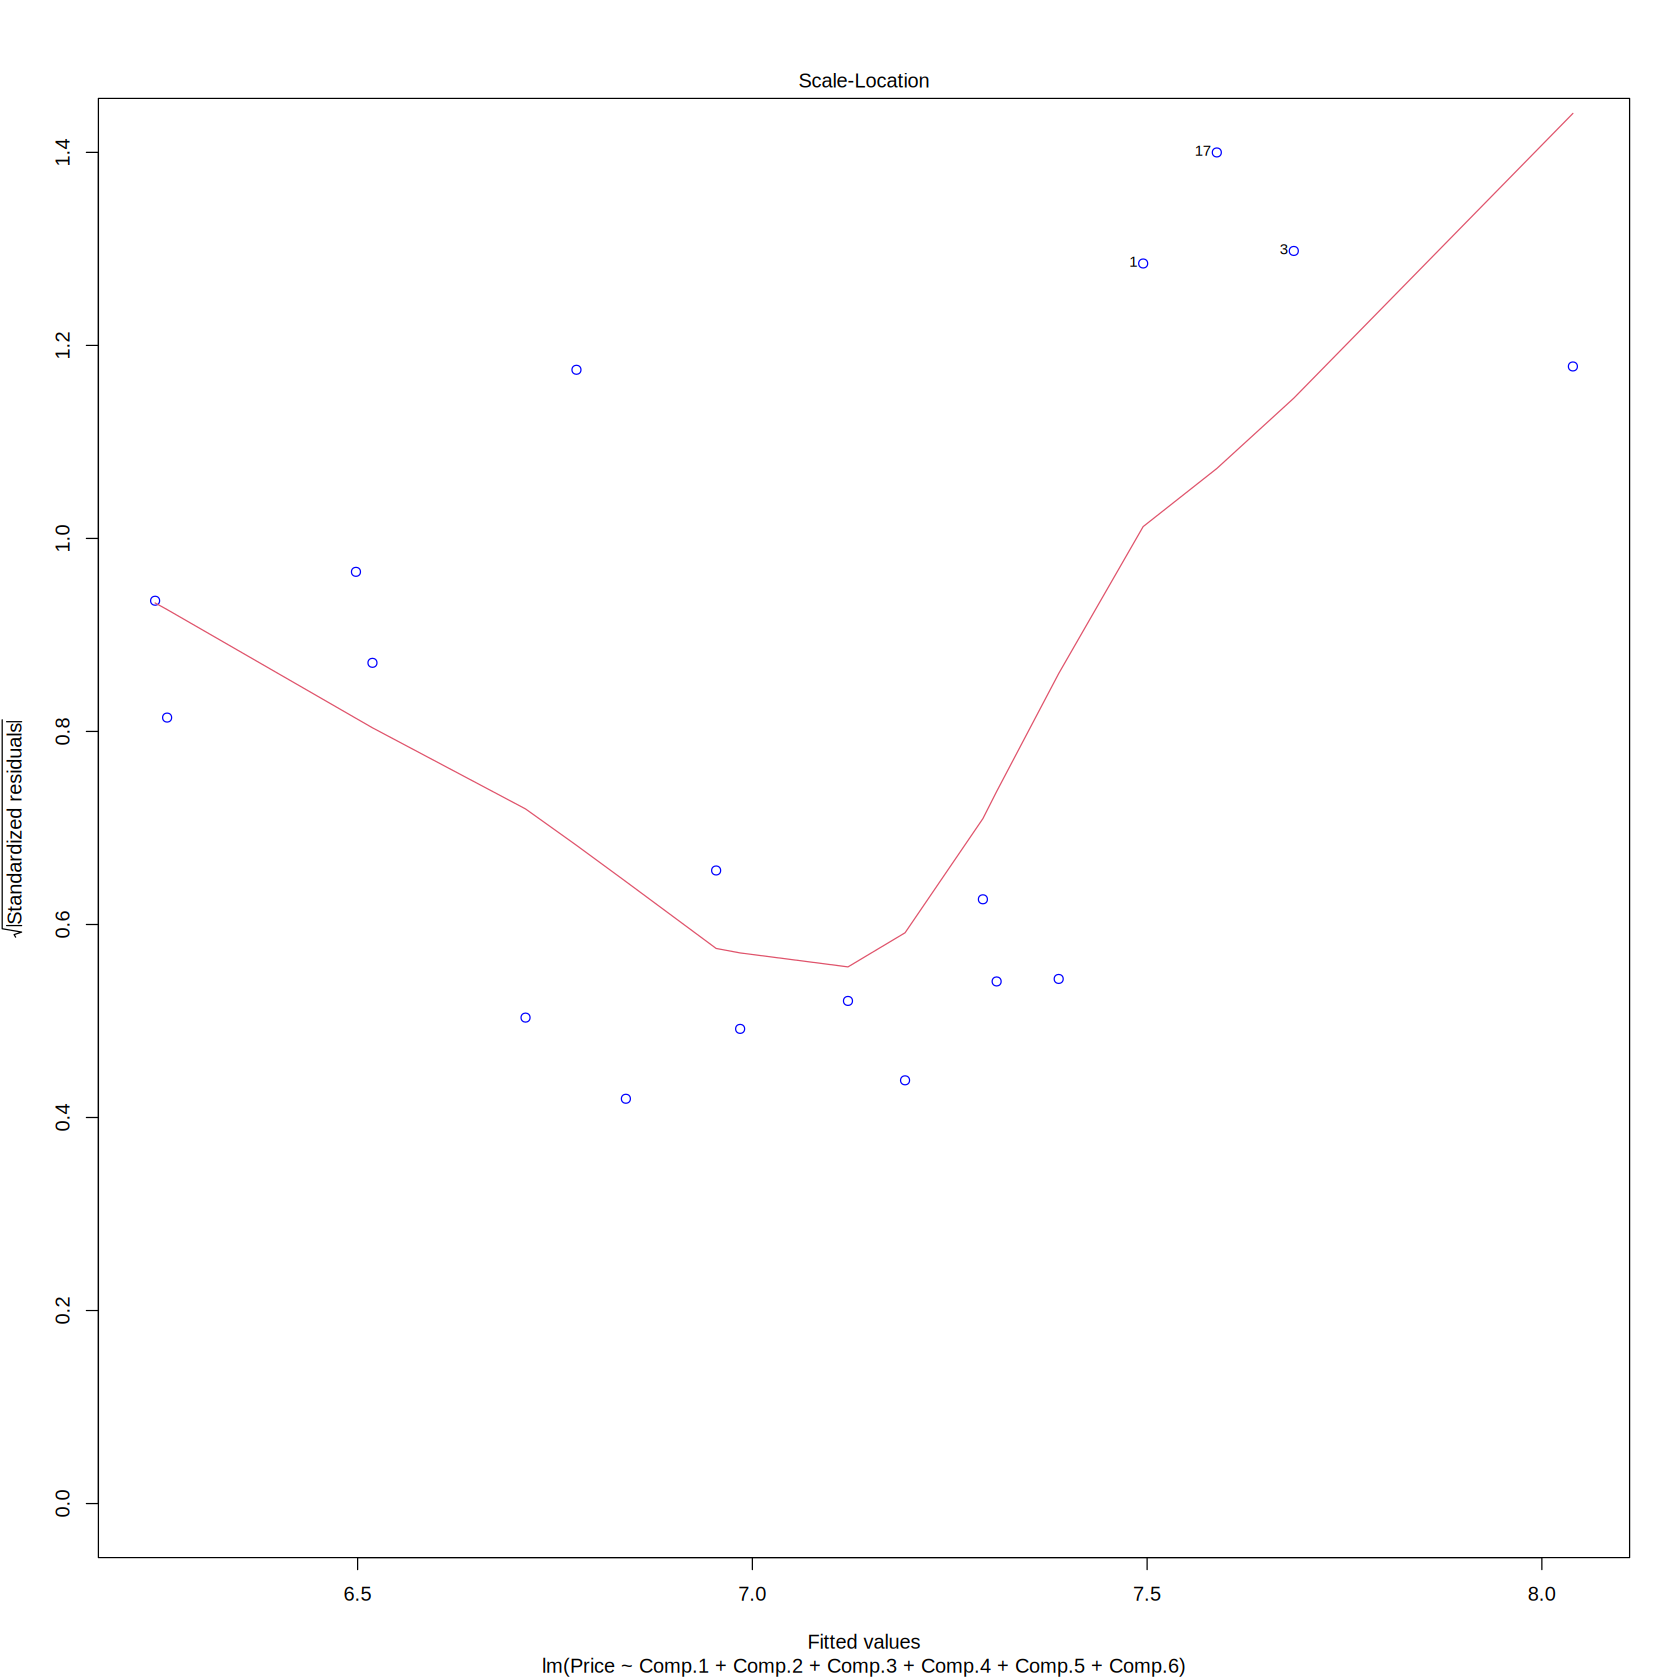

In [46]:
plot(modBIC_PCA1, which=3, col=c("blue")) # Scale-Location

Ta phát hiện:
- Đường màu đỏ gần bị lệch về phía dưới của biểu đồ. Nghĩa là, độ phân tán của giá trị thặng dư gần không bằng nhau ở tất cả các giá trị phù hợp.
- Các giá trị thặng dư được phân tán ngẫu nhiên xung quanh đường màu đỏ với độ biến thiên không bằng nhau ở tất cả các giá trị phù hợp.

Cẩn thận hơn, chúng ta sử dụng Breusch-Pagan test để kiểm tra có thật là như vậy không?
- H0: Các giá trị thặng dư là homoscedastic
- H1: Các giá trị thặng dư là heteroscedastic

In [47]:
# Breusch-Pagan Test
print(bptest(modBIC_PCA1))


	studentized Breusch-Pagan test

data:  modBIC_PCA1
BP = 5.7546, df = 6, p-value = 0.4512



Ta thấy p-value >0.05, ta chưa đủ cơ sở để bác bỏ H0.

Đối với mô hình 2

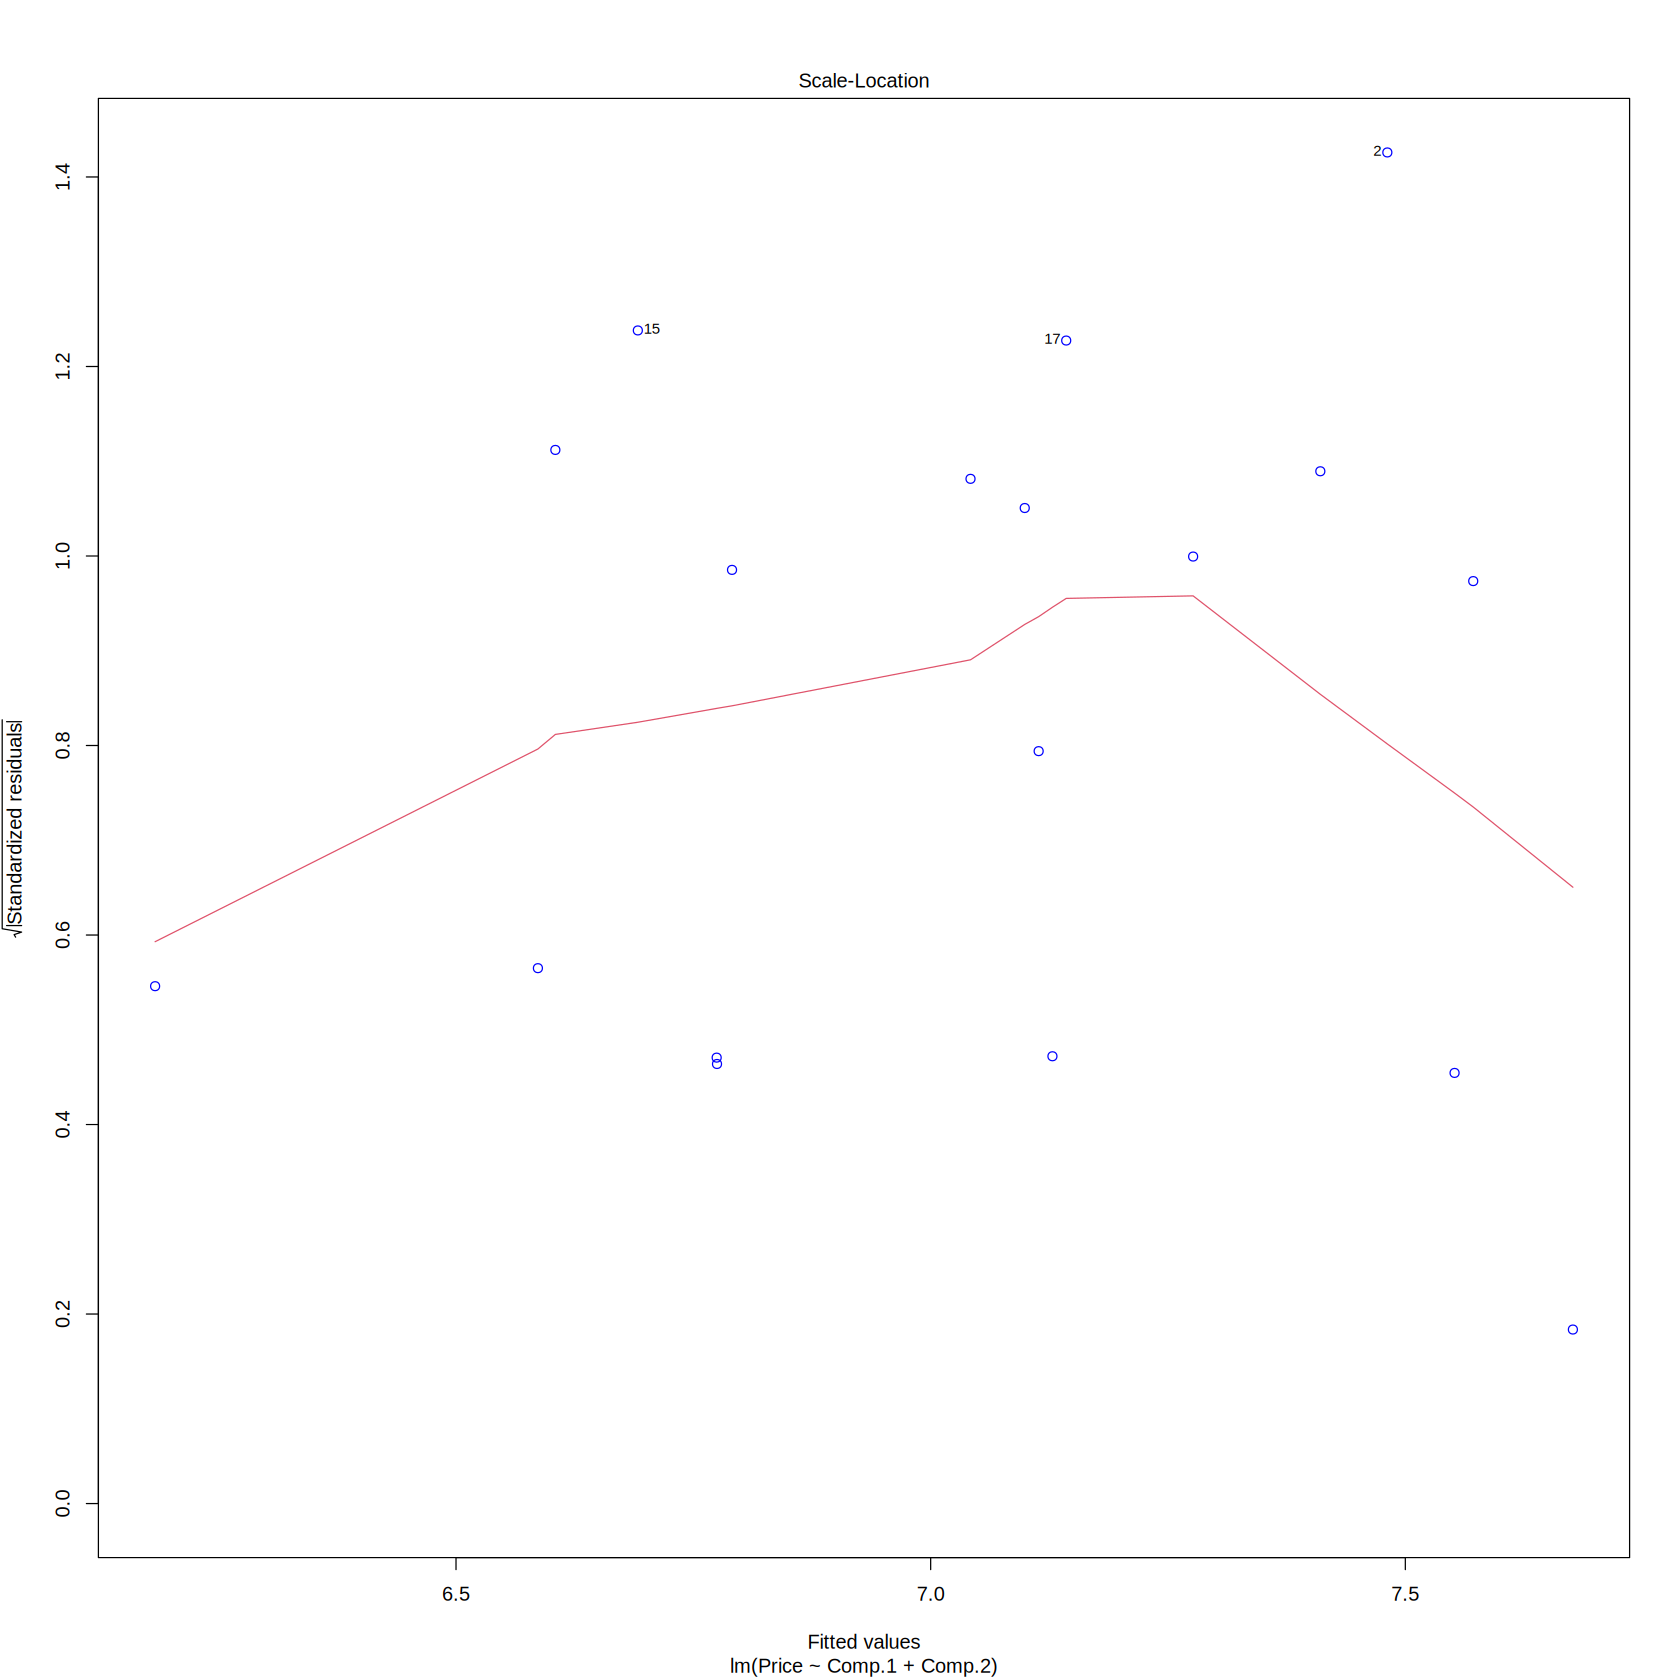

In [48]:
plot(modBIC_PCA2, which=3, col=c("blue")) # Scale-Location

In [49]:
# Breusch-Pagan Test
print(bptest(modBIC_PCA2))


	studentized Breusch-Pagan test

data:  modBIC_PCA2
BP = 0.87429, df = 2, p-value = 0.6459



Ta cũng nhận được kết quả tương tự.

#### Residuals vs Leverage

Biểu đồ này có thể được sử dụng để tìm các trường hợp có ảnh hưởng trong tập dữ liệu. Một trường hợp có ảnh hưởng là một trường hợp mà nếu bị loại bỏ sẽ ảnh hưởng đến mô hình nên việc đưa vào hoặc loại trừ nó cần được xem xét.

Một trường hợp có ảnh hưởng có thể là một trường hợp ngoại lệ hoặc không và mục đích của biểu đồ này là xác định các trường hợp có ảnh hưởng lớn đến mô hình. Các ngoại lệ sẽ có xu hướng có giá trị cực cao hoặc cực thấp và do đó ảnh hưởng đến mô hình.

Đối với mô hình 1

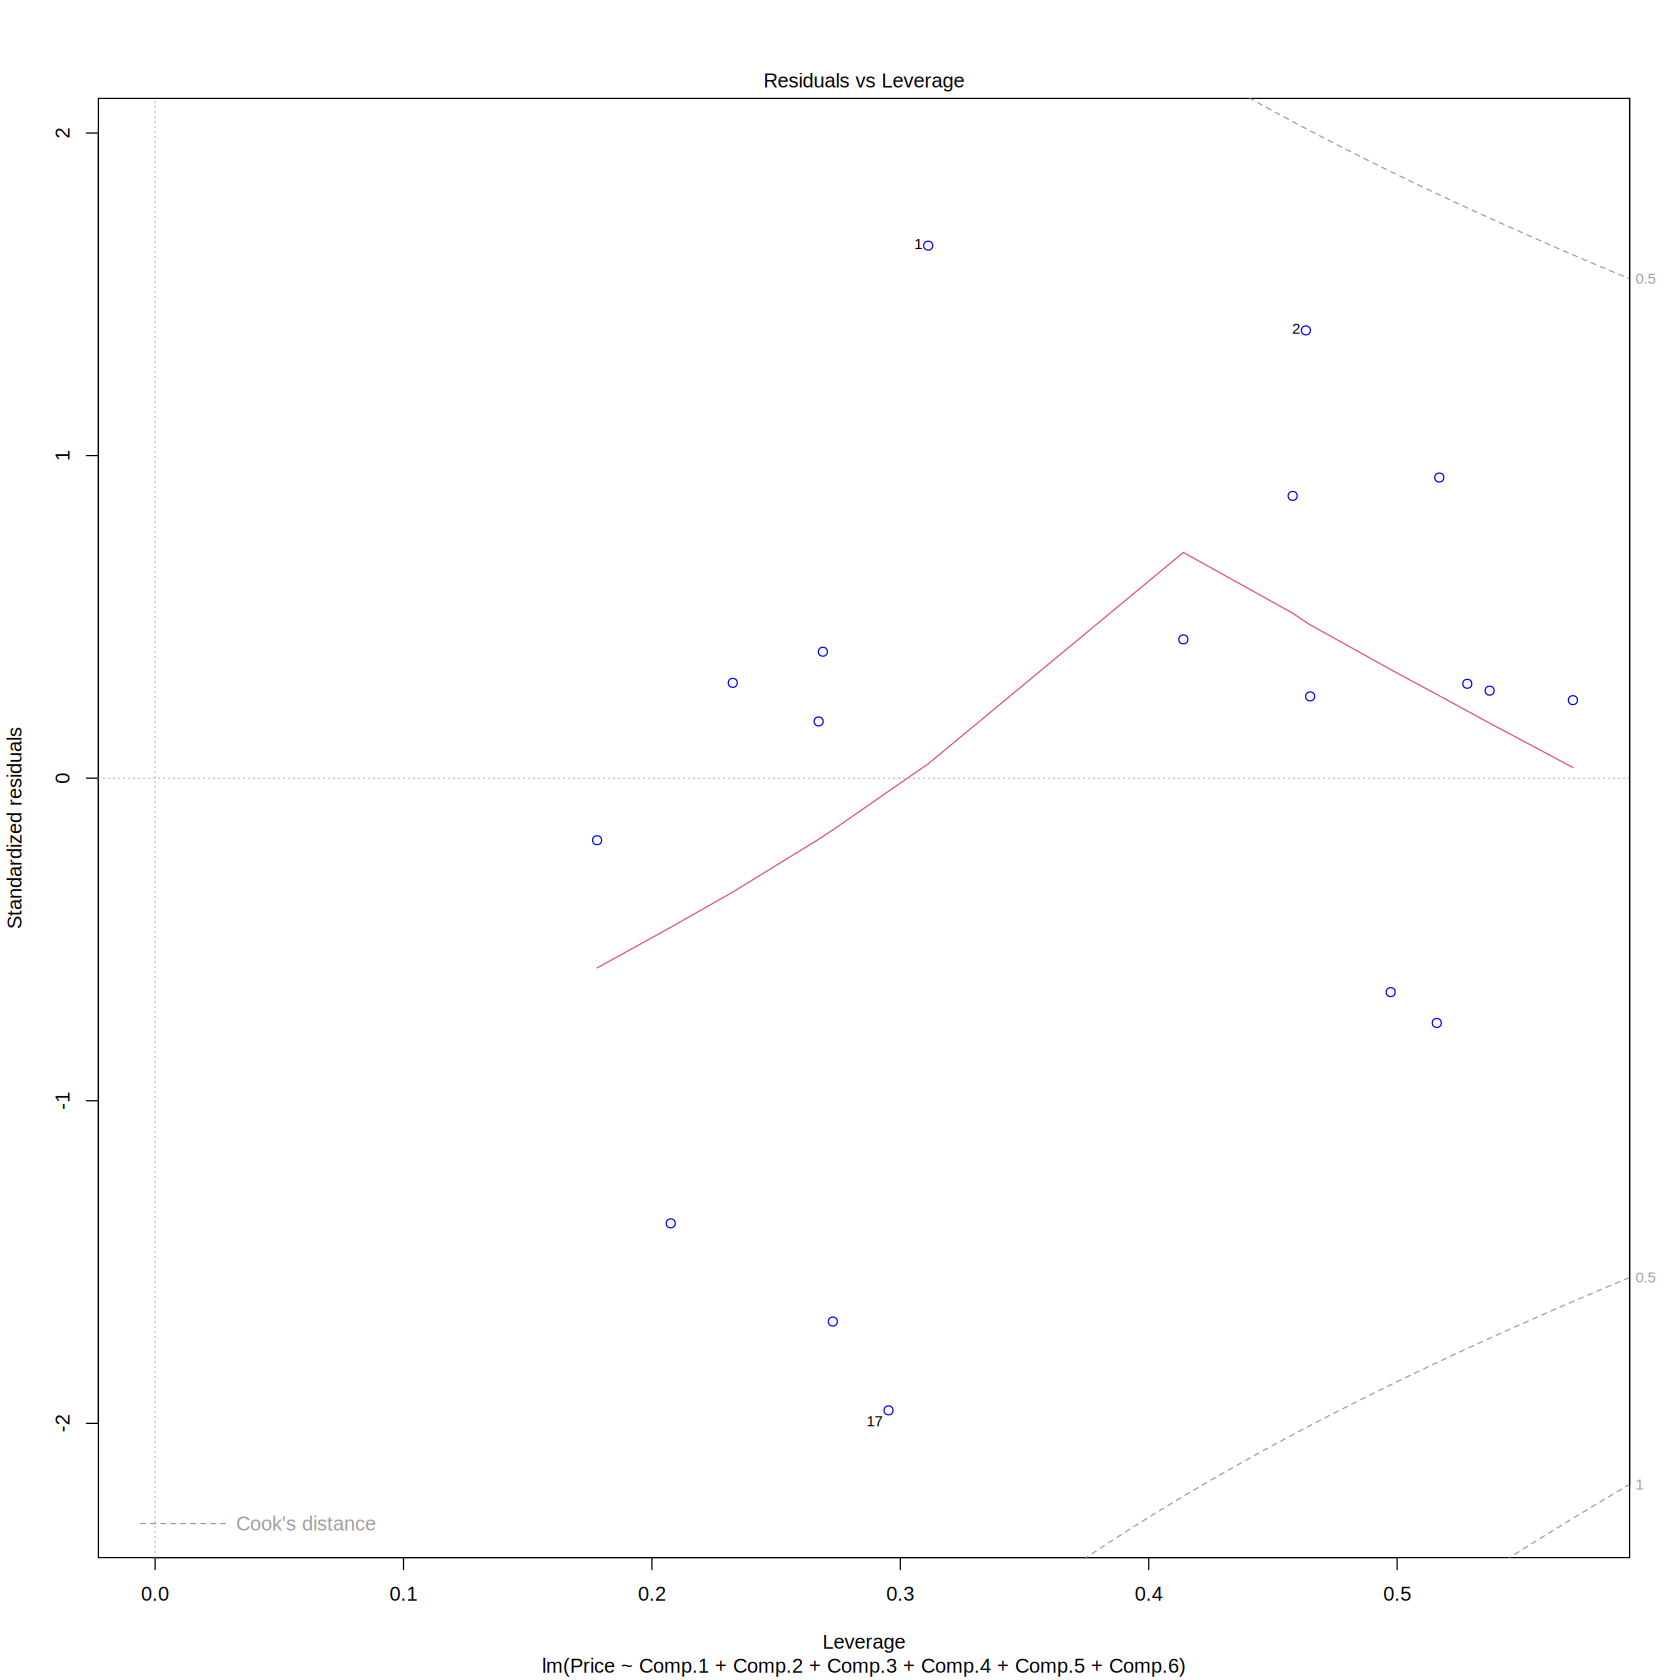

In [50]:
plot(modBIC_PCA1, which=5, col=c("blue"))  # Residuals vs Leverage

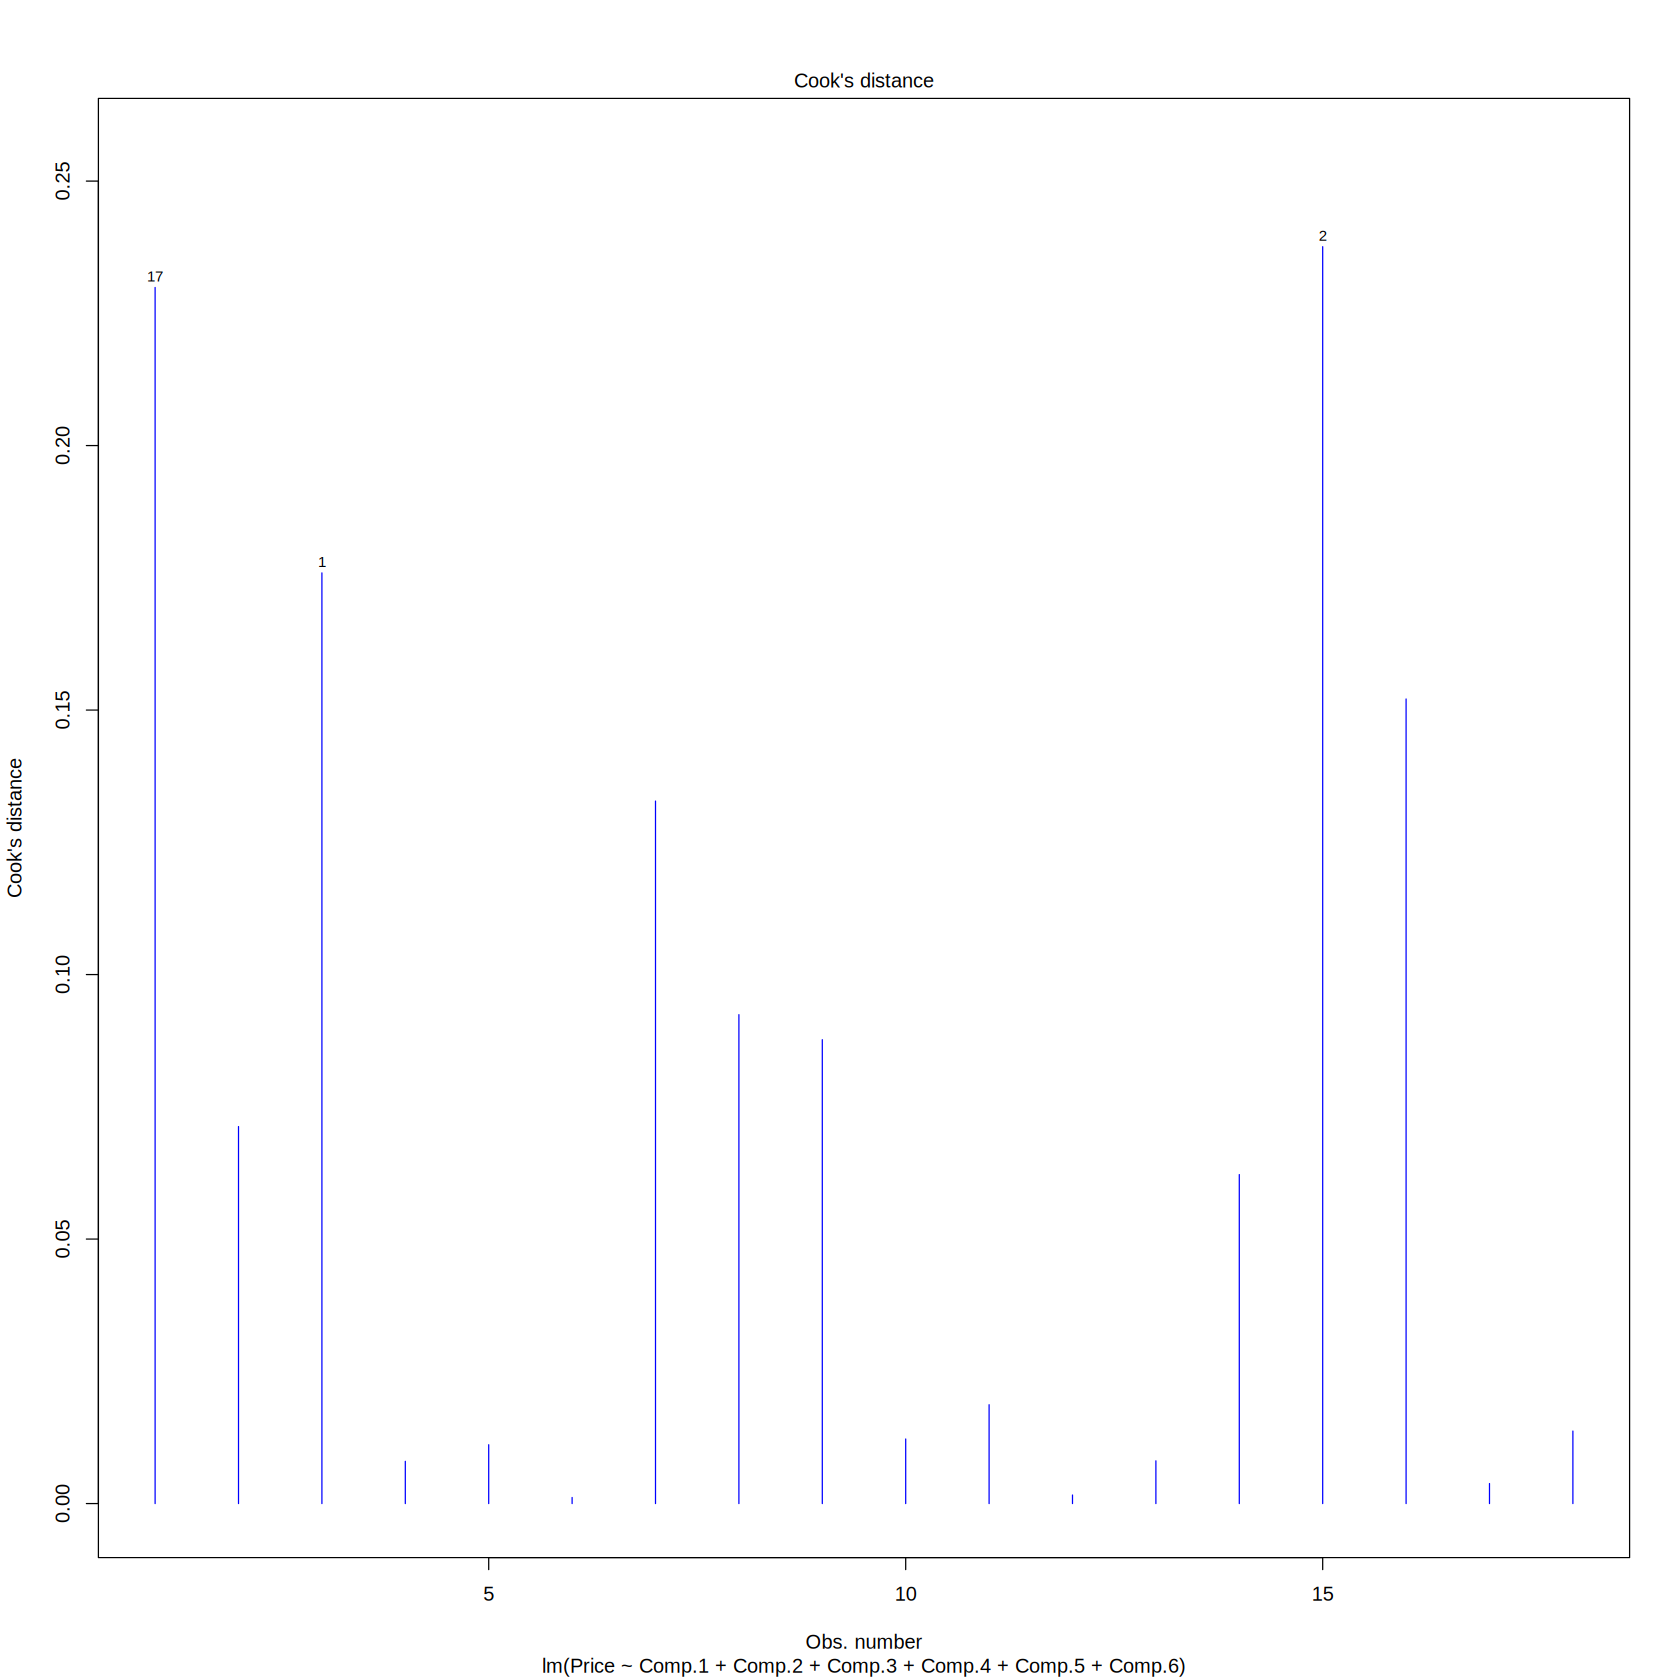

In [51]:
plot(modBIC_PCA1, which=4, col=c("blue"))  # Cook's Distance

Đối với mô hình 2

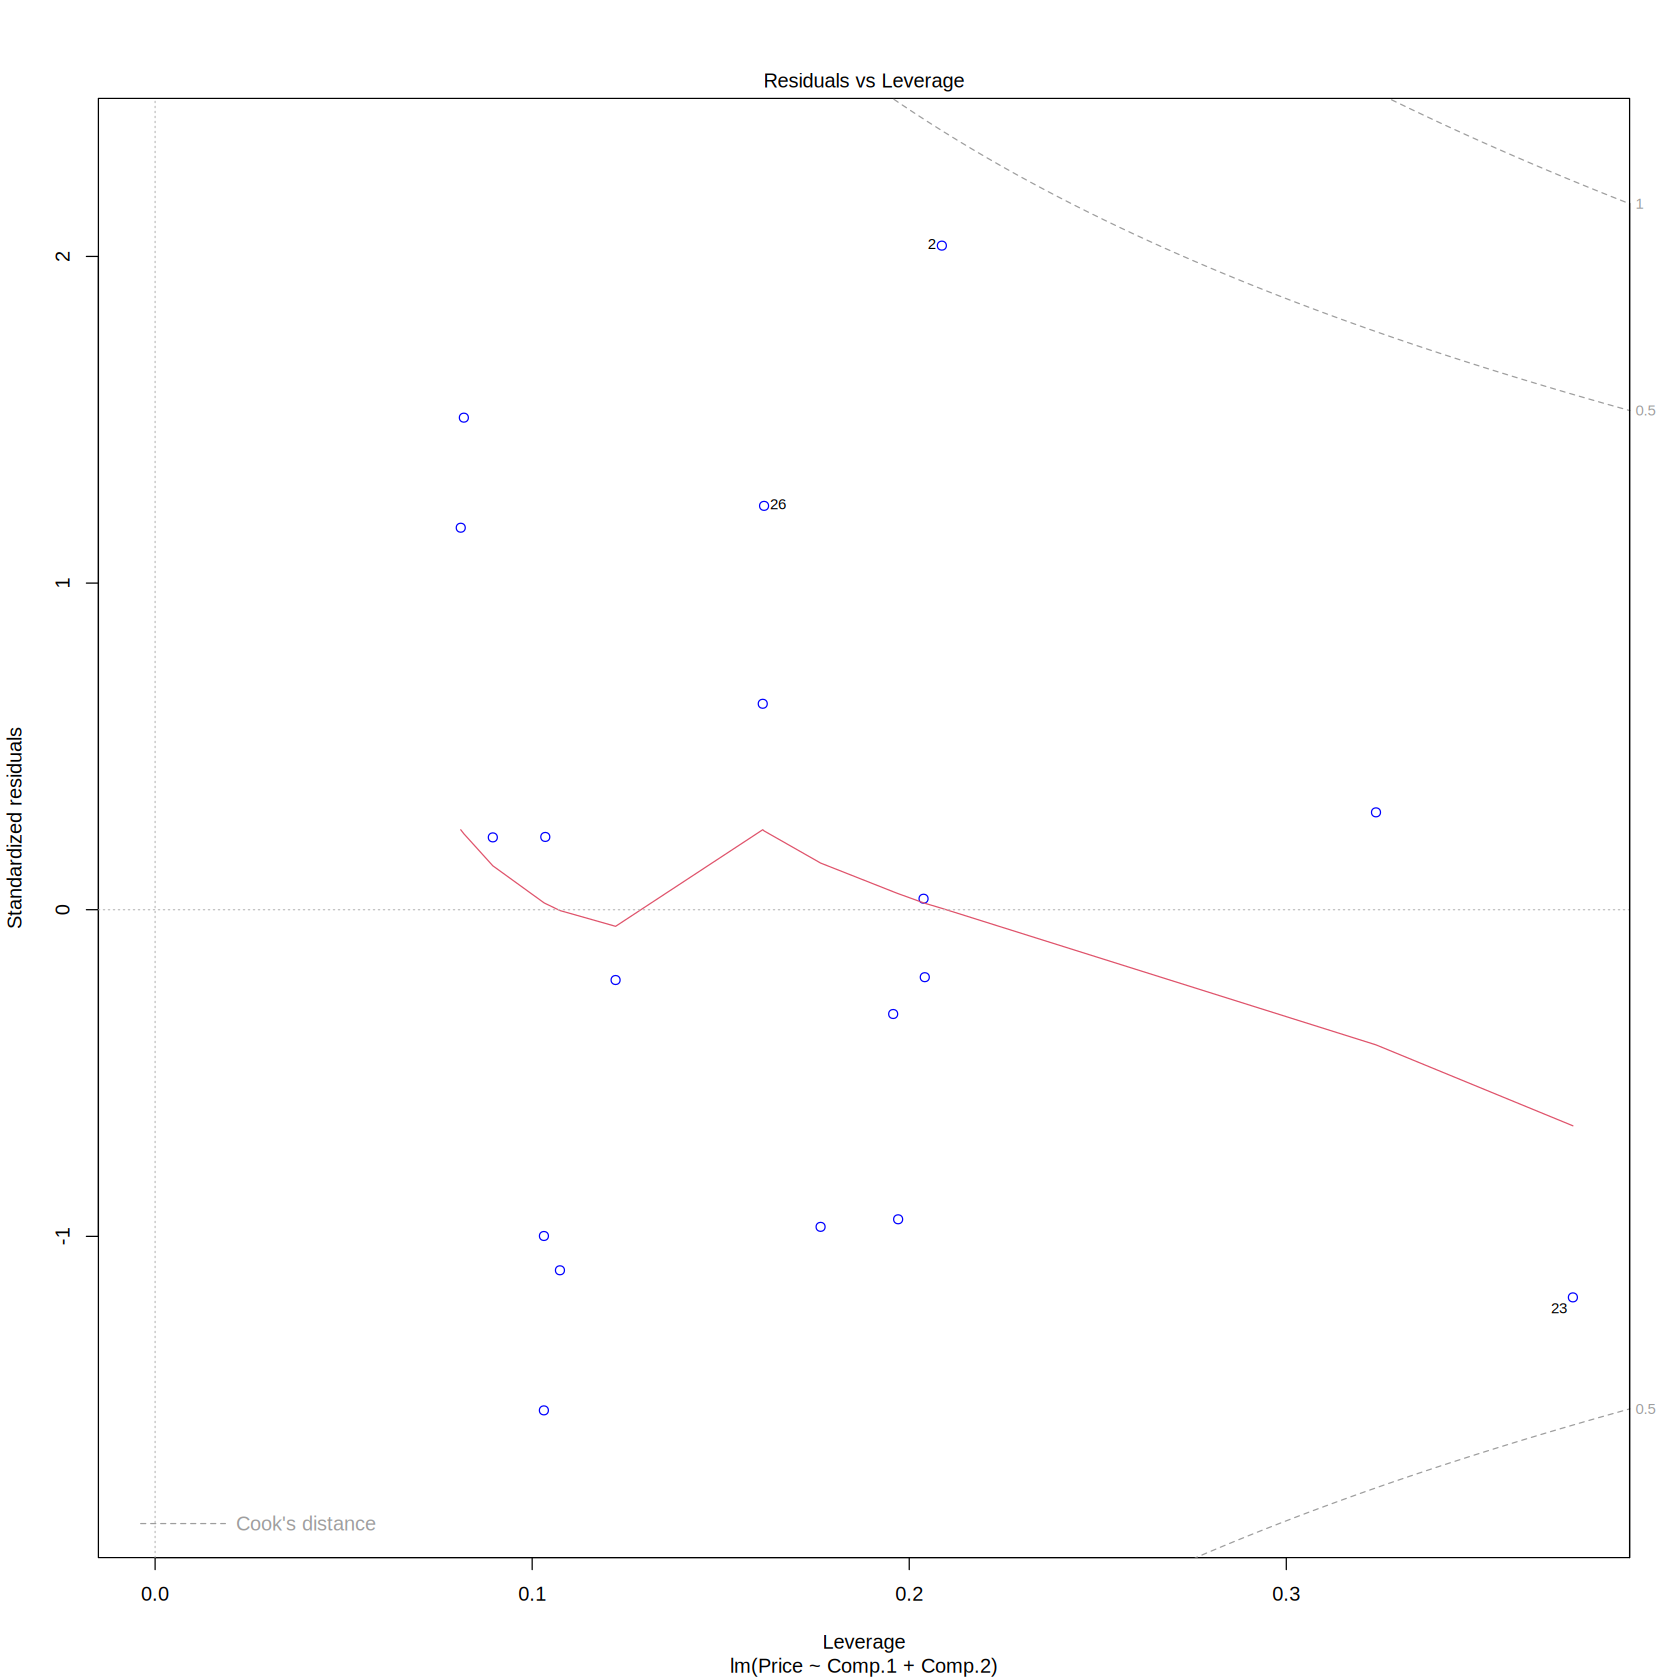

In [52]:
plot(modBIC_PCA2, which=5, col=c("blue"))  # Residuals vs Leverage

#### Đem mô hình ra thi thật!!!

[1] 9.217629

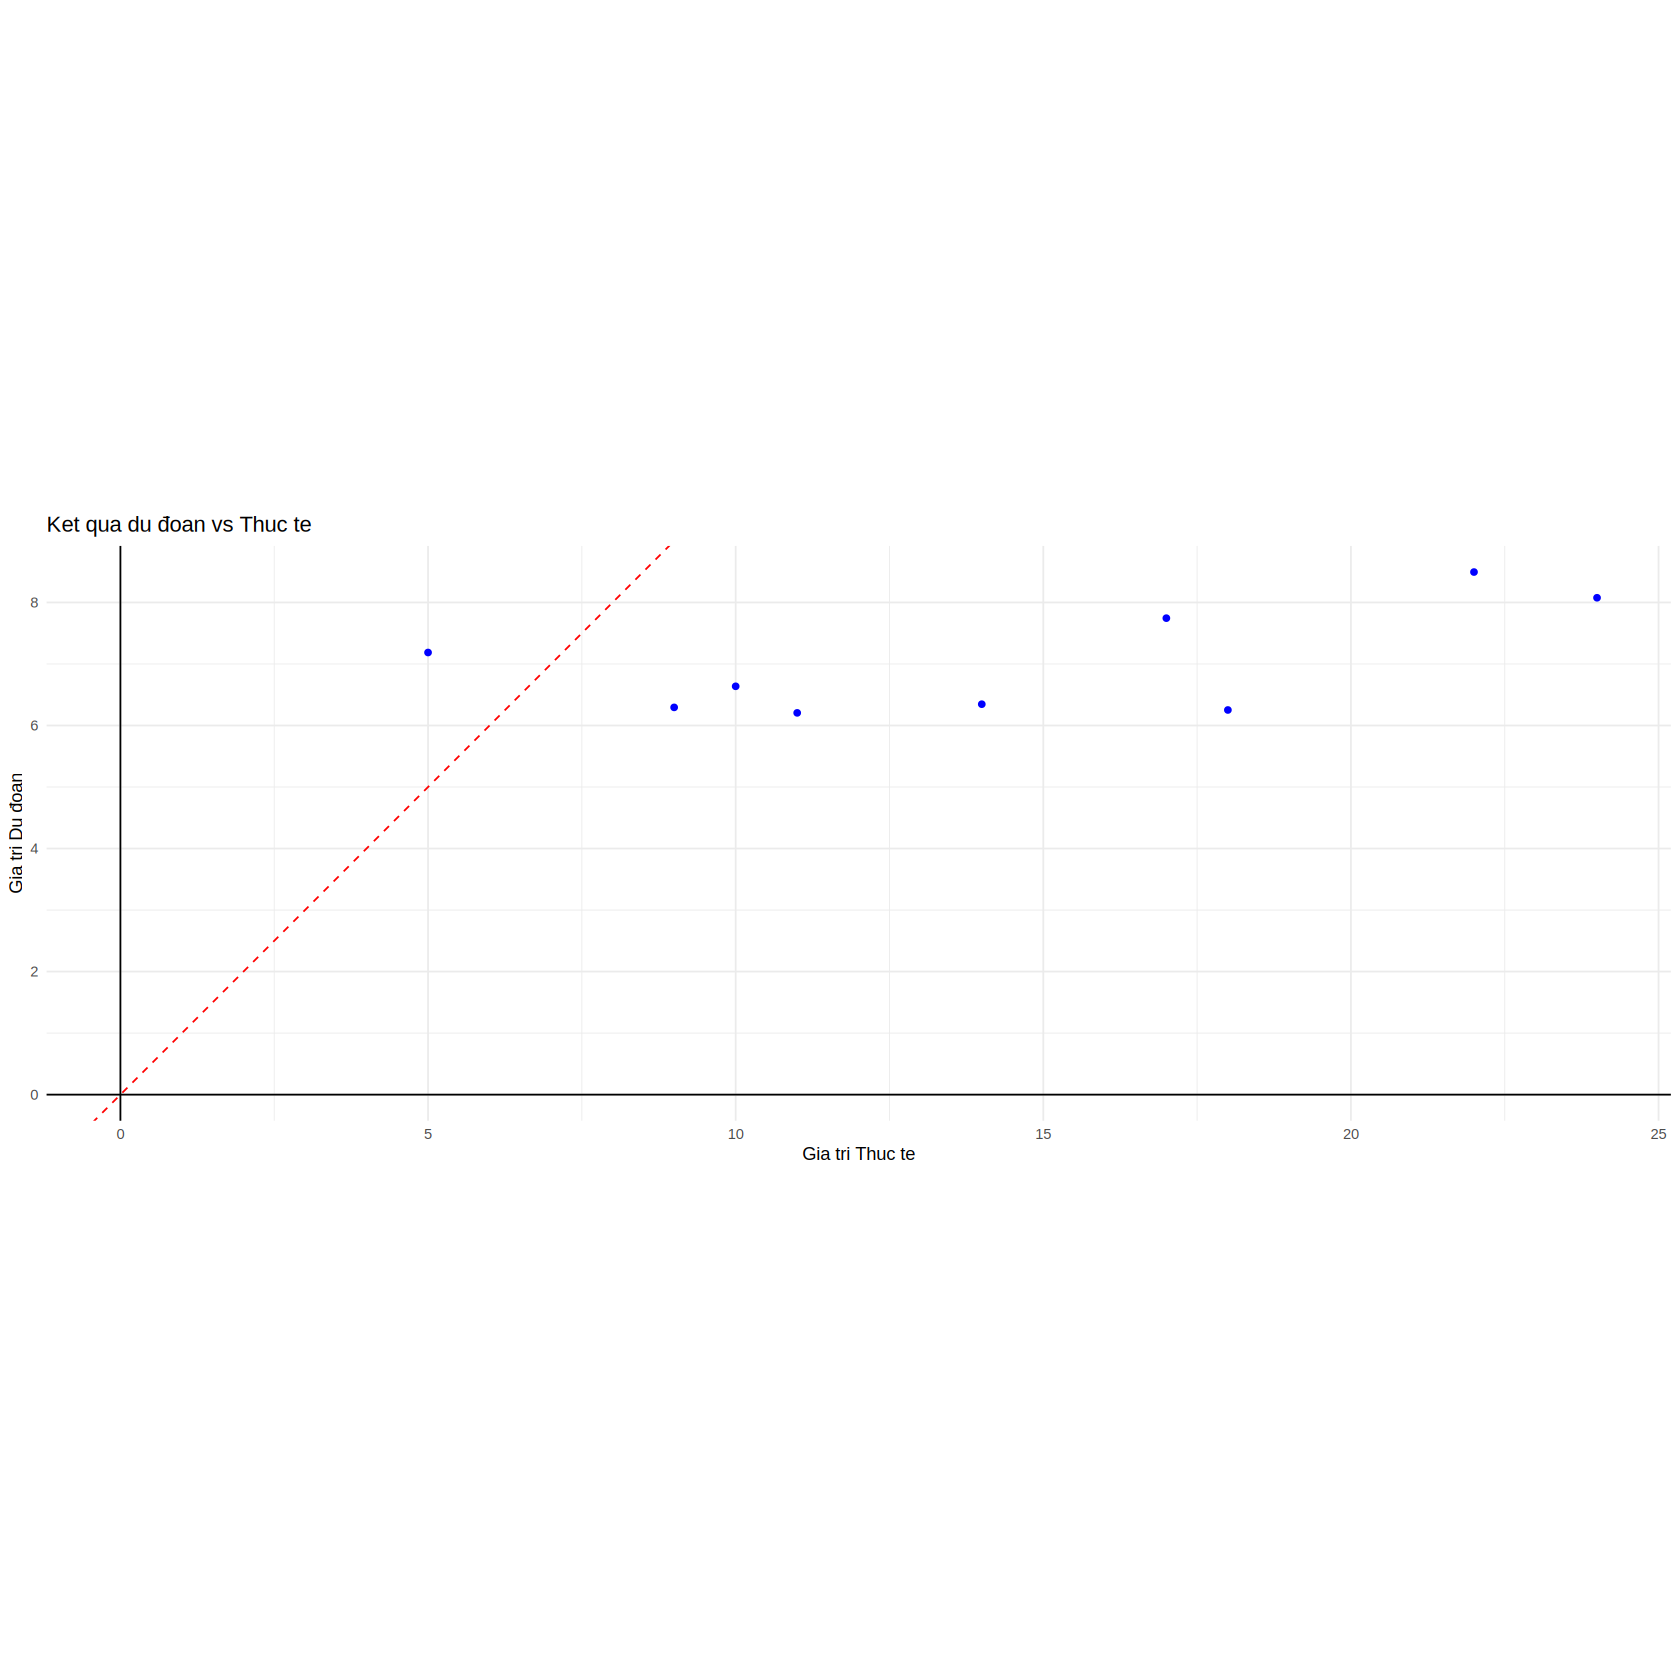

In [53]:
# Dư đoán
alpha = pca_model1$coefficients
gamma = pca_df$loadings %*% alpha[-1]
gamma = c(alpha[1] - pca_df$center %*% gamma, gamma)
test_pca = scale(test, center = pca_df$center, scale = pca_df$scale) # Centered and scaled
test_pca = t(apply(test_pca, 1,function(x) t(pca_df$loadings) %*% x))
test_pca <- data.frame("Comp" = test_pca)
# Kiểm định tập test

# predict
results = predict(modBIC_PCA1, test_pca)
vis_df = data.frame(
    du_doan = results,
    label = test$Price
)

library(ggplot2)
ggplot(vis_df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') + geom_abline(intercept = 0, slope = 1, color = 'red', linetype = "dashed") +
  geom_hline(yintercept = 0, color = "black") +  # Trục Ox
  geom_vline(xintercept = 0, color = "black") +  # Trục Oy
  labs(
    title = "Ket qua du đoan vs Thuc te",
    x = "Gia tri Thuc te",
    y = "Gia tri Du đoan"
  ) +
  theme_minimal() + coord_fixed(ratio = 1)
rmse(results, test$Price)

[1] 120.7791

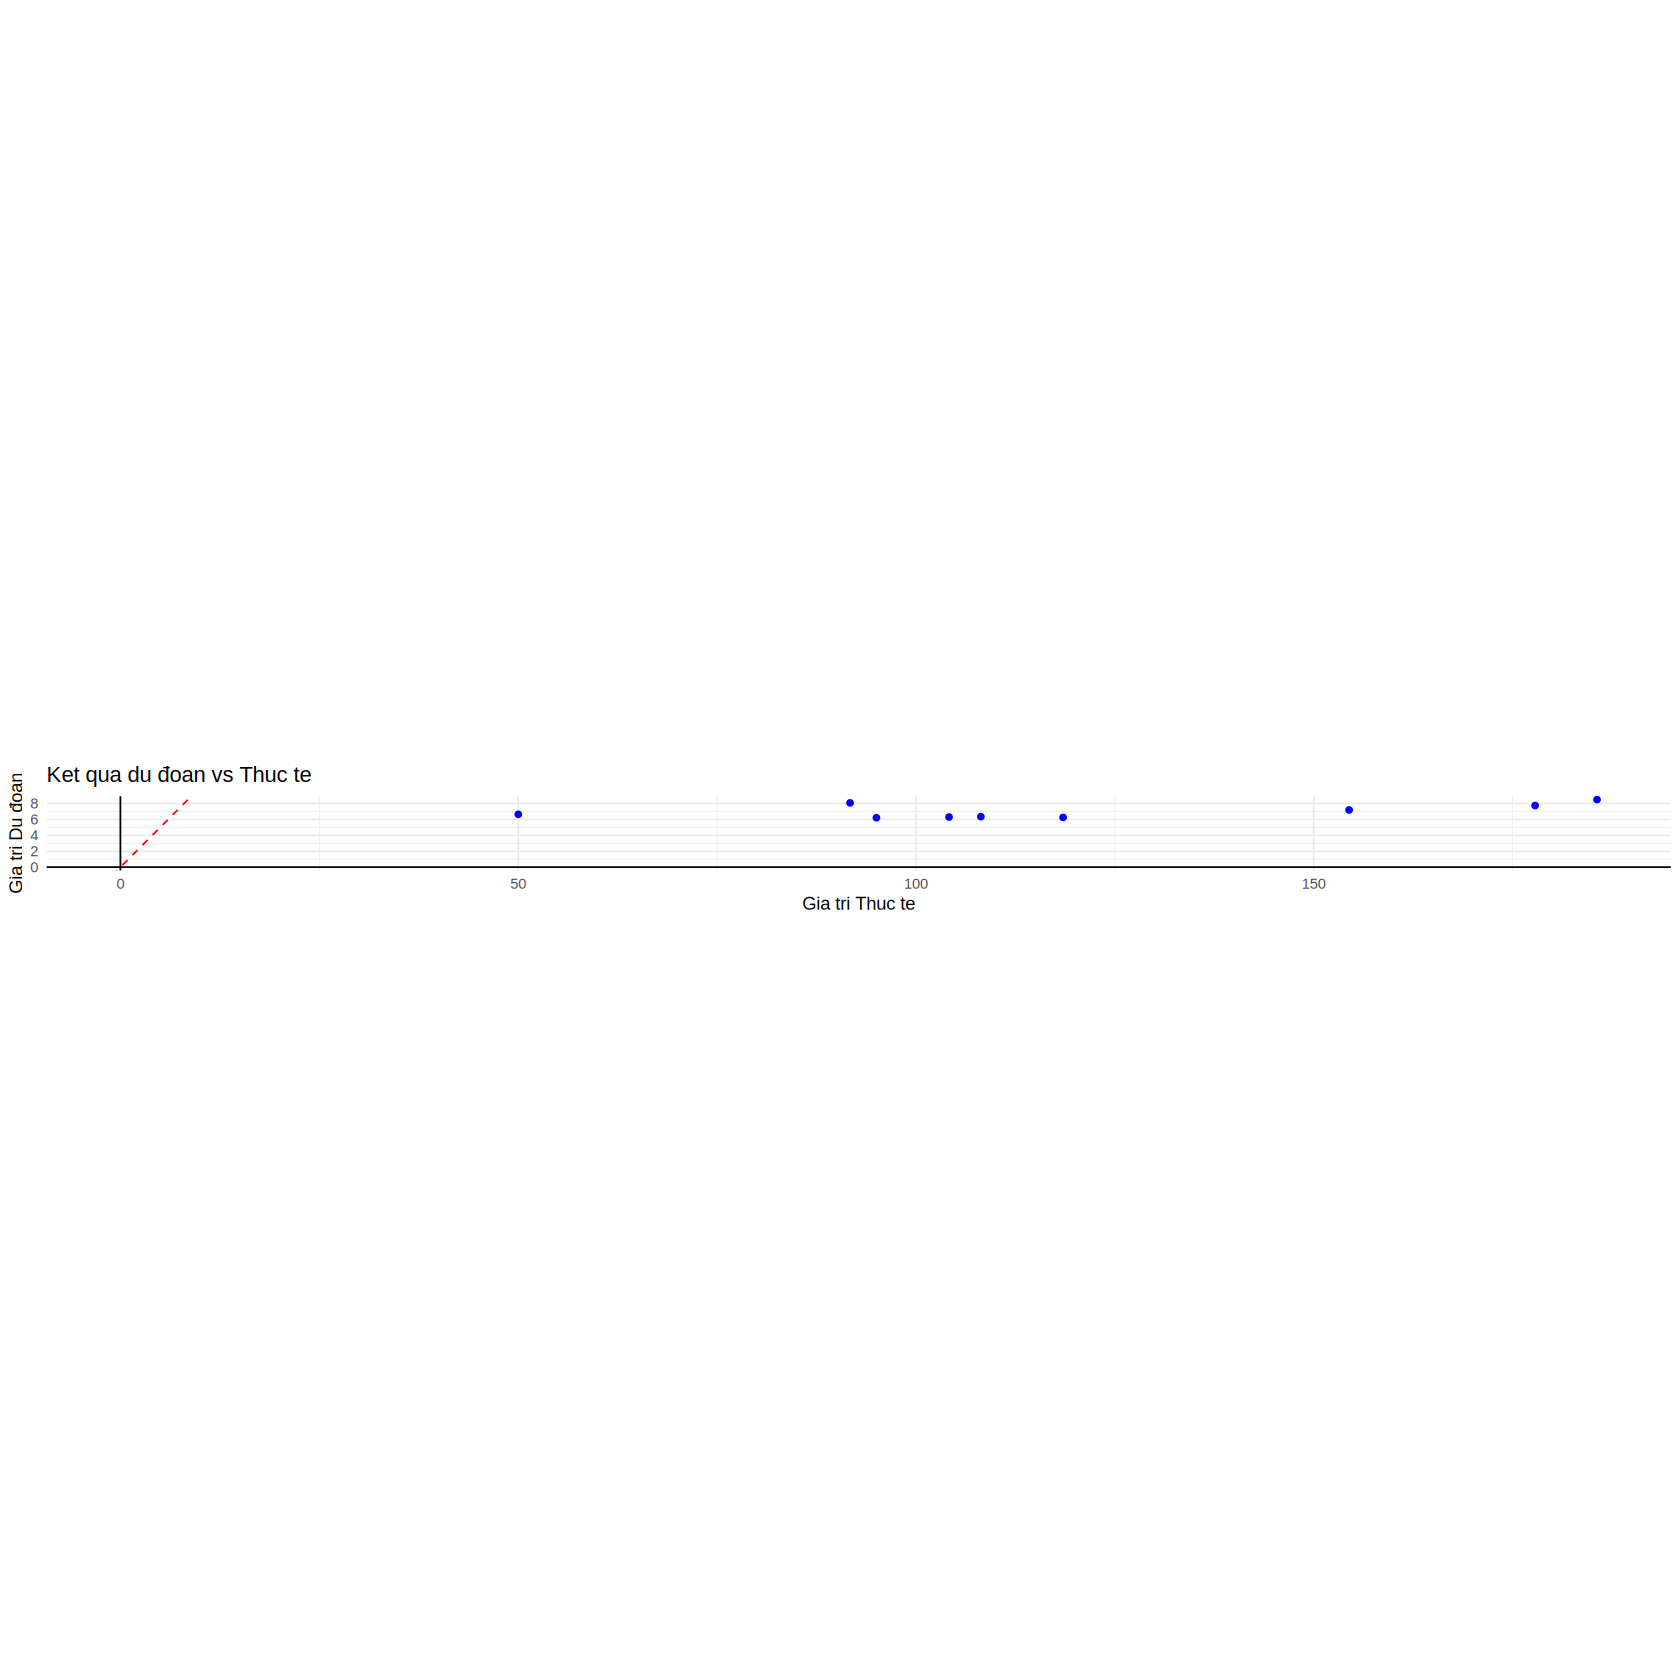

In [54]:
# Dư đoán
alpha = pca_model2$coefficients
gamma = pca_df$loadings[, 1:2] %*% alpha[-1]
gamma = c(alpha[1] - pca_df$center %*% gamma, gamma)
test_pca = scale(test, center = pca_df$center, scale = pca_df$scale) # Centered and scaled
test_pca = t(apply(test_pca, 1, function(x) t(pca_df$loadings[, 1:2]) %*% x))
test_pca <- data.frame("Comp" = test_pca)
# Kiểm định tập test

# predict
results = predict(pca_model2, test_pca)
vis_df = data.frame(
    du_doan = results,
    label = test$Price
)

library(ggplot2)
ggplot(vis_df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') + geom_abline(intercept = 0, slope = 1, color = 'red', linetype = "dashed") +
  geom_hline(yintercept = 0, color = "black") +  # Trục Ox
  geom_vline(xintercept = 0, color = "black") +  # Trục Oy
  labs(
    title = "Ket qua du đoan vs Thuc te",
    x = "Gia tri Thuc te",
    y = "Gia tri Du đoan"
  ) +
  theme_minimal() + coord_fixed(ratio = 1)
rmse(results, test$Price)